In [424]:
%reload_ext autoreload
%autoreload 0


import numpy as np
import scipy as sc
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import tqdm
from numba import jit
sns.set()
sns.set_style("darkgrid")
pd.set_option('display.max_columns', 200)


from scipy.stats import ks_2samp as ks2
from scipy.stats import mannwhitneyu as mwu
from scipy.stats import kruskal
from scipy.stats import wasserstein_distance as w1_dist
from scipy.stats import energy_distance as w2_dist
from scipy.stats import epps_singleton_2samp as epps
from scipy.spatial.distance import directed_hausdorff as hausdorff
from scipy.spatial.distance import correlation, euclidean, cosine, cityblock
#from category_encoders import *

#import SimpSOM as sps
#import minisom as msom
#import sompy
from umap import UMAP
from sklearn.manifold import TSNE

import random

import gc
import os
import sys
from collections import Counter
from collections import namedtuple
from collections import defaultdict
import inspect
import itertools
#from varname import varname
import inspect

from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.experimental import enable_iterative_imputer

from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import IsolationForest, RandomForestClassifier, VotingClassifier, BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.svm import OneClassSVM, NuSVC
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.linear_model import HuberRegressor, RANSACRegressor, BayesianRidge, LogisticRegression
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor, ExtraTreesRegressor
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, PowerTransformer, QuantileTransformer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA, NMF, KernelPCA
from sklearn.impute import KNNImputer, SimpleImputer, IterativeImputer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA, QuadraticDiscriminantAnalysis as QDA
from sklearn.cross_decomposition import PLSRegression as PLS
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split, StratifiedShuffleSplit
from sklearn import metrics
from sklearn.metrics import recall_score, make_scorer

from sklearn.cluster import SpectralClustering, AffinityPropagation, OPTICS, AgglomerativeClustering
import debacl as dcl
from hdbscan import HDBSCAN

from xgboost import XGBClassifier as XGB
from lightgbm import LGBMClassifier as LGBM
from catboost import CatBoostClassifier as CATB
from interpret.glassbox import ExplainableBoostingClassifier as EBM

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers import MaxPooling1D
from keras.callbacks import Callback
from keras.layers.convolutional import Conv1D
from keras.layers import Input 

from imblearn.over_sampling import SMOTE, BorderlineSMOTE, SVMSMOTE, ADASYN

from ngboost import NGBRegressor, NGBClassifier
from ngboost.distns import LogNormal, Normal, k_categorical, Bernoulli
from ngboost.learners import default_tree_learner
from rulefit import RuleFit

## Playground
This notebooks forms the playground for different methods:
* graph clustering for multicollinearity removal
* set distance for feature inclusion
* repeated quantile binning to create a privacy and overfitting robust dataset
* unsupervised model directives: use dimension reduction with density-based clustering techniques to define specific models. for each cluster.
    1. identify cluster
    2. apply appropriate model
* comparison of methods: 
    * **[RuleFit](https://statweb.stanford.edu/~jhf/ftp/RuleFit.pdf)**, XGboost, LGBM, CATboost, ExtraTrees, RandomForest 
    * GAM's
    * SVM's
    * NN's: 1D CNN's, DNN's
    * GCP, NB, LR
* comparison of clustering methods: HDBSCAN, OPTICS, spectral clustering
* multi-omic integration methods like: sparse CCA/ICA/PLS/SNF/JNMF 
* making the results [interpretable](https://christophm.github.io/interpretable-ml-book/)

In [425]:
scaler= {'ecg': QuantileTransformer(n_quantiles=100, output_distribution='uniform'), 
         'celldyn': QuantileTransformer(n_quantiles=100, output_distribution='uniform'), 
         'other': MinMaxScaler()} # StandardScaler(), MinMaxScaler(), RobustScaler() or None

scaling_apriori = False
scaling_aposteriori = True

# dict with column name and impute type: median, mean, remove, regressor, (nmf?), or None, or knnimputer, or iterative which uses a round-robin approach using BayesianRidge as the regressor
feature_expansion_intra = ['celldyn', 'ecg_cols_agg']
feature_expansion_inter = [('pheno', 'celldyn'), 
                           ('pheno', 'ecg_cols_agg'), 
                           ('history', 'celldyn'), 
                           ('history', 'ecg_cols_agg')]

#feature_weights = 'glm' # glm, tree, gam
#clustering = 'hdbscan' # hdbscan, SOM, spectral
remove_nan_patients = False
# NGBRegressor(), BayesianRidge(), MLPRegressor(hidden_layer_sizes=(70,70,30)), https://blog.stata.com/2011/08/22/use-poisson-rather-than-regress-tell-a-friend/
# P-features, P_RInterval_ECG/POnset_ECG/PAxis_ECG/POffset_ECG, if NaN, could mean absence of initial polar. which could mean atrium fibr.
imputance = {'BMI': 'median', 
             'P_RInterval_ECG': None, 
             'POnset_ECG': None, 
             'PAxis_ECG': None, 
             'POffset_ECG': None}
missing_dummy = True
remove_nan_cols = True # remove only those columns with no imputance
variance_remove = True
remove_multicoll = True
remove_outlying_samples_from_train = True
remove_outlying_samples_from_test = False
remove_weak_univariates = False
univariate_inclusive = False
keep_strongest_N = 1500 # keep strongest N features based on univariate scores
remove_low_diffEntropy = False
run_supervised_umap = False
experimental_supervisors = False
model_comparison = True
patient_clustering = True
make_simple_featureset_comparison = True
extensive_feature_importances = False

hausdorff_feature_builder = False
wasserstein_feature_builder = False
pairwisedistance_feature_builder = True
complete_dist_improvement = False
prune_cols = ['ecg', 'celldyn']
base_cols = ['pheno', 'history', 'troponine']
extratrees_feature_builder = True
top_n_all = 1000
top_n = {'ecg': 300, 'celldyn': 300, 
         'pheno_celldyn': 25, 
         'pheno_ecg_cols_agg': 25, 
         'history_celldyn': 100, 
         'history_ecg_cols_agg': 100}

In [426]:
def prep_accs(df):    
    set1 = df.loc[df.THRESHOLD>0.5].groupby(['featureset', 'with_celldyn']).mean()
    set1['threshold_minimum'] = 0.5

    set2 = df.loc[df.THRESHOLD>0.6].groupby(['featureset', 'with_celldyn']).mean()
    set2['threshold_minimum'] = 0.6

    set3 = df.loc[df.THRESHOLD>0.7].groupby(['featureset', 'with_celldyn']).mean()
    set3['threshold_minimum'] = 0.7

    set3 = df.loc[df.THRESHOLD>0.8].groupby(['featureset', 'with_celldyn']).mean()
    set3['threshold_minimum'] = 0.8

    set4 = df.loc[df.THRESHOLD>0.9].groupby(['featureset', 'with_celldyn']).mean()
    set4['threshold_minimum'] = 0.9

    set5 = df.loc[df.THRESHOLD>0.95].groupby(['featureset', 'with_celldyn']).mean()
    set5['threshold_minimum'] = 0.95

    acc_agg = pd.concat([set1,set2,set3,set4,set5])
    acc_agg.reset_index(inplace=True)
    acc_agg.sort_values(by=['threshold_minimum', 'featureset', 'with_celldyn'], inplace=True)
    return acc_agg

def retrieve_name(var):
    callers_local_vars = inspect.currentframe().f_back.f_locals.items()
    return [var_name for var_name, var_val in callers_local_vars if var_val is var]

@jit
def amean(X):
    return np.mean(X, axis=1)
    
@jit
def hmean(X):
    # only meaningful for positive real numbers
    return sc.stats.hmean(X, axis=1)

@jit
def gmean(X):
    return sc.stats.gmean(X, axis=1)

def process_cliques(X, agg_function='amean', cliques=None, cols=None, prefix='mcoll_'):
    '''
    X: array containing columns that we want to change
    agg_function: aggregation function for the clique, amean, hmean, gmean
    cliques: list of lists with column indices
    cols: column indices/names to ensure the indices in X are correct, if None, assumes that the column indices in cliques refer to X-cols directly
    prefix: prefix for the new columns
    
    returns: X with changed columns, list of column names/indices added to the array
    '''
    
    fun = amean if agg_function=='amean' else hmean if agg_function=='hmean'  else gmean
    
    _X = X[cols].values if cols is not None else X.values
    
    n_rows  = _X.shape[0]
    n_cols  = len(cliques)
    
    new_cols = []
    X_add = np.zeros((n_rows, n_cols))
    for j, _clique in enumerate(cliques):
        __X = _X[0:n_rows, _clique]
        X_add[:, j] = fun(__X)
        new_cols.append(prefix+"clique_"+str(j))
    return pd.DataFrame(data=X_add, columns=new_cols, index=X.index) 

# univariate outlier replacer
def featurewise_outlier_replacer(x, q=(0.01, 0.99), how='quantile'):
    if how=='quantile':
        # improvement..instead of blunt replacement with fixed number use sampler
        lv, rv = x.quantile(q[0]), x.quantile(q[1])
        t = x.copy()
        t[t>rv] = rv
        t[t<lv] = lv
        return t

def _condition_number(x, ignore_nan=True):
    return np.linalg.cond(x.dropna(), p=2)

def wass_sup_distance(x, y, merge=np.product, wass=w1_dist):
    return wass(merge(x, axis=1), merge(y, axis=1))

def get_pca_weights(reducer=None, cols=None, ncomp=10):
    pcweights = np.zeros((len(cols),))
    wt = 0
    for pc in range(0, ncomp):
        w = ncomp-pc
        wt = wt + w
        pcweights = w*np.abs(reducer.components_[pc]) + pcweights
    pcweights = pcweights/wt
    pcw = pcweights[np.argsort(pcweights)]
    _cols = np.array(cols)[np.argsort(pcweights)]
    return dict(zip(_cols,pcw))

def get_var_cols(d):
    assert isinstance(d, dict), 'input variables is not a dictionary'
    return list(set(list(itertools.chain.from_iterable(d.values()))))

def _rem_cols(cd, rem):
    assert isinstance(cd, dict), 'Input variable 1 should be a dictionary'
    assert isinstance(rem, list), 'Input variable 2 should be a list'
    for _key in cd.keys():
        cd[_key] = list(set(cd[_key]) - set(rem))
    return cd

def pairwise_distance(x, y, merge=np.mean, dist=correlation):
    return dist(merge(x, axis=0), merge(y, axis=0))

@jit
def _ssqrt(x, y):
    return np.sign(x*y)*np.sqrt(np.multiply(np.abs(x), np.abs(y)))
@jit
def _divisor(x, y, eps=1e-3):    
    return np.sign(x)*np.divide((x**2), (x**2+y**2+eps))
@jit
def _sum(x, y):
    return x+y
@jit
def expander2(x, y=None, fun=None):
    '''
        x : np array 
        fun : expansion function, assumes pairwise expansion
    '''
    if y is None:
        num_rows, num_cols = x.shape[0], x.shape[1]
        _num_cols = np.int((num_cols**2-num_cols)/2)
        xex = np.zeros(shape=(num_rows, _num_cols)) 
        k=0
        for jl in range(0, num_cols):
            for jr in range(jl+1, num_cols):                
                xex[:, k] =   fun(x[:,jl], x[:,jr])
                k +=1
    else:
        num_rows_l, num_rows_r, num_cols_l, num_cols_r = x.shape[0], y.shape[0], x.shape[1], y.shape[1]
        _num_cols = np.int(num_cols_l*num_cols_r)
        xex = np.zeros(shape=(num_rows_l, _num_cols))
        k=0
        for jl in range(0, num_cols_l):
            for jr in range(0, num_cols_r):               
                xex[:, k] =   fun(x[:,jl], y[:,jr])
                k +=1
    return xex

def _cols_(cols, cols_r=None, prefix=None):
    prefix = prefix+"_" if prefix is not None else ""
    ms = len(cols)+1 if cols_r==None else 0
    cols_r = cols if cols_r is None else cols_r
    return [prefix+cols[jl]+"_"+cols_r[jr] for jl in range(0, len(cols)) for jr in range(np.min([jl+1, ms]), len(cols_r))]

@jit
def _diff_entropy(x, eps=1e-6, bins=20):
    rhos, xs = np.histogram(x, density=True, bins=bins)
    xmean =  (xs[1:] + xs[:-1])/2
    xdiff = xs[1:] - xs[:-1]
    H = -np.sum(rhos*np.log(rhos+eps)*xdiff)
    Hr = H/np.sum(xdiff)
    return Hr

# add relative entropy  -np.sum(rhos*np.log(rhos/rhos_ref+eps)*xdiff) where rhos_ref is a reference distribution
# for the relative distribution we can use the average empirical distribution of the features

class fs_ws1():
    scores_ = None
    def __init__(self, pvalue = 0.01):
        self.pvalue = pvalue

    def apply_test(self, pos, neg, column):
        zscore = w1_dist(pos[:,column], neg[:,column])
        return zscore
    
    def fit(self, x, y):
        zero_idx = np.where(y == 0)[0]
        one_idx = np.where(y == 1)[0]
        pos_samples = x[one_idx]
        neg_samples = x[zero_idx]                
        results_ = np.array(list(map(lambda c: 
            self.apply_test(pos_samples, neg_samples, c), range(0,x.shape[1]))))
        self.scores_ = results_
        return self
    
class fs_ws2():
    scores_ = None
    def __init__(self, pvalue = 0.01):
        self.pvalue = pvalue

    def apply_test(self, pos, neg, column):
        zscore = w2_dist(pos[:,column], neg[:,column])
        return zscore
    
    def fit(self, x, y):
        zero_idx = np.where(y == 0)[0]
        one_idx = np.where(y == 1)[0]
        pos_samples = x[one_idx]
        neg_samples = x[zero_idx]                
        results_ = np.array(list(map(lambda c: 
            self.apply_test(pos_samples, neg_samples, c), range(0,x.shape[1]))))
        self.scores_ = results_
        return self
    
class fs_mannwhitney():
    pvalues_ = None
    scores_ = None
    results_ = None
    def __init__(self, pvalue = 0.01, mode='auto'):
        # mode : 'auto', 'exact', 'asymp'
        self.pvalue = pvalue
        self.mode = mode

    def apply_test(self, pos, neg, column):
        zscore, p_value = mwu(pos[:,column], neg[:,column], alternative="less") # mode=self.mode
        return zscore, p_value
    
    def fit(self, x, y):
        zero_idx = np.where(y == 0)[0]
        one_idx = np.where(y == 1)[0]
        pos_samples = x[one_idx]
        neg_samples = x[zero_idx]                
        self.results_ = np.array(list(map(lambda c: 
            self.apply_test(pos_samples, neg_samples, c), range(0,x.shape[1]))))
        self.scores_ = self.results_[:, 0]
        self.pvalues_ = self.results_[:, 1]
        return self

    def transform(self, x):
        not_signif = self.p_values<self.pvalue
        to_delete = [idx for idx, item in enumerate(not_signif) if item == False]
        return np.delete(x, to_delete, axis = 1), to_delete

class fs_ks():
    pvalues_ = None
    scores_ = None
    results_ = None
    def __init__(self, pvalue = 0.01):
        self.pvalue = pvalue

    def apply_test(self, pos, neg, column):
        zscore, p_value = ks2(pos[:,column], neg[:,column])
        return zscore, p_value
    
    def fit(self, x, y):
        zero_idx = np.where(y == 0)[0]
        one_idx = np.where(y == 1)[0]
        pos_samples = x[one_idx]
        neg_samples = x[zero_idx]                
        self.results_ = np.array(list(map(lambda c: 
            self.apply_test(pos_samples, neg_samples, c), range(0,x.shape[1]))))
        self.scores_ = self.results_[:, 0]
        self.pvalues_ = self.results_[:, 1]
        return self

    def transform(self, x):
        not_signif = self.p_values<self.pvalue
        to_delete = [idx for idx, item in enumerate(not_signif) if item == False]
        return np.delete(x, to_delete, axis = 1), to_delete

class fs_epps():
    pvalues_ = None
    scores_ = None
    results_ = None
    def __init__(self, pvalue = 0.01):
        self.pvalue = pvalue

    def apply_test(self, pos, neg, column):
        zscore, p_value = epps(pos[:,column], neg[:,column])
        return zscore, p_value
    
    def fit(self, x, y):
        zero_idx = np.where(y == 0)[0]
        one_idx = np.where(y == 1)[0]
        pos_samples = x[one_idx]
        neg_samples = x[zero_idx]                
        self.results_ = np.array(list(map(lambda c: 
            self.apply_test(pos_samples, neg_samples, c), range(0,x.shape[1]))))
        self.scores_ = self.results_[:, 0]
        self.pvalues_ = self.results_[:, 1]
        return self

    def transform(self, x):
        not_signif = self.p_values<self.pvalue
        to_delete = [idx for idx, item in enumerate(not_signif) if item == False]
        return np.delete(x, to_delete, axis = 1), to_delete

def mcc(y_true, y_prob, thresh=0.5, greedy='symmetric'):
    if greedy=='symmetric':
        TP = np.sum((y_prob>thresh) & (y_true==1))
        TN = np.sum((y_prob<(1-thresh)) & (y_true==0))
        FP = np.sum((y_prob>thresh) & (y_true==0))
        FN = np.sum((y_prob<(1-thresh)) & (y_true==1))
    elif greedy=='negative':
        TP = np.sum((y_prob>thresh) & (y_true==1))
        TN = np.sum((y_prob<(thresh)) & (y_true==0))
        FP = np.sum((y_prob>thresh) & (y_true==0))
        FN = np.sum((y_prob<(thresh)) & (y_true==1))        
    mcc = (TP*TN - FP*FN)/np.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN)) if (TP+FP)*(TP+FN)*(TN+FP)*(TN+FN)>0 else np.nan
    return mcc
    
def balanced_accuracy(y_true, y_prob, thresh=0.5, greedy='symmetric'):
    if greedy=='symmetric':
        TP = np.sum((y_prob>thresh) & (y_true==1))
        TN = np.sum((y_prob<(1-thresh)) & (y_true==0))
        FP = np.sum((y_prob>thresh) & (y_true==0))
        FN = np.sum((y_prob<(1-thresh)) & (y_true==1))
    elif greedy=='negative':
        TP = np.sum((y_prob>thresh) & (y_true==1))
        TN = np.sum((y_prob<(thresh)) & (y_true==0))
        FP = np.sum((y_prob>thresh) & (y_true==0))
        FN = np.sum((y_prob<(thresh)) & (y_true==1))
        
    recall = TP/(FN+TP) if (FN+TP)>0 else np.nan
    specificity = TN/(FP+TN) if (FP+TN)>0 else np.nan
    return 0.5*(recall+specificity)

def fb_score(y_true, y_prob, beta=1, thresh=0.5, greedy='symmetric'):
    if greedy=='symmetric':
        TP = np.sum((y_prob>thresh) & (y_true==1))
        TN = np.sum((y_prob<(1-thresh)) & (y_true==0))
        FP = np.sum((y_prob>thresh) & (y_true==0))
        FN = np.sum((y_prob<(1-thresh)) & (y_true==1)) 
    elif greedy=='negative':
        TP = np.sum((y_prob>thresh) & (y_true==1))
        TN = np.sum((y_prob<(thresh)) & (y_true==0))
        FP = np.sum((y_prob>thresh) & (y_true==0))
        FN = np.sum((y_prob<(thresh)) & (y_true==1))         
    prec = TP/(TP+FP) if (TP+FP)>0 else np.nan
    rec =  TP/(TP+FN) if (TP+FN)>0 else np.nan
    return (1+beta**2)*prec*rec/(beta**2*prec+rec)

def npv(y_true, y_prob, thresh=0.5, greedy='symmetric'): 
    if greedy=='symmetric':
        TN = np.sum((y_prob<(1-thresh)) & (y_true==0))
        FN = np.sum((y_prob<(1-thresh)) & (y_true==1))  
    elif greedy=='negative':
        TN = np.sum((y_prob<(thresh)) & (y_true==0))
        FN = np.sum((y_prob<(thresh)) & (y_true==1))          
    NPV = TN/(TN+FN) if (TN+FN)>0 else np.nan
    return NPV

def recall(y_true, y_prob, thresh=0.5, greedy='symmetric'):
    if greedy=='symmetric':
        TP = np.sum((y_prob>thresh) & (y_true==1))
        FN = np.sum((y_prob<(1-thresh)) & (y_true==1))
    elif greedy=='negative':
        TP = np.sum((y_prob>thresh) & (y_true==1))
        FN = np.sum((y_prob<(thresh)) & (y_true==1))        
    AP = np.sum(y_true)
    recall = TP/(TP+FN) if (TP+FN)>0 else np.nan
    return recall, TP/AP  

def prec(y_true, y_prob, thresh=0.5, greedy='symmetric'):
    TP = np.sum((y_prob>thresh) & (y_true==1))
    FP = np.sum((y_prob>thresh) & (y_true==0))
    prec  = TP/(TP+FP) if (TP+FP)>0 else np.nan
    return prec
    
def spec(y_true, y_prob, thresh=0.5, greedy='symmetric'):
    TN = np.sum((y_prob<(1-thresh)) & (y_true==0))
    FP = np.sum((y_prob>thresh) & (y_true==0))
    spec = TN/(TN+FP) if (TN+FP)>0 else np.nan 
    return spec 
    
        
def fpr(y_true, y_prob, thresh=0.5, greedy='symmetric'):
    if greedy=='symmetric':
        TN = np.sum((y_prob<(1-thresh)) & (y_true==0))
        FP = np.sum((y_prob>thresh) & (y_true==0))
    elif greedy=='negative':
        TN = np.sum((y_prob<(thresh)) & (y_true==0))
        FP = np.sum((y_prob>thresh) & (y_true==0))        
    FPR = FP/(FP+TN) if (FP+TN)>0 else np.nan
    return FPR

def roc(y_true, y_prob, thresh):
    roc_arr = []
    for _thresh in thresh:
        TP = np.sum((y_prob>thresh) & (y_true==1))
        TN = np.sum((y_prob<(1-thresh)) & (y_true==0))
        FP = np.sum((y_prob>thresh) & (y_true==0))
        FN = np.sum((y_prob<(1-thresh)) & (y_true==1)) 

        TPR = TP/(TP+FN) if (TP+FN)>0 else np.nan
        FPR = FP/(FP+TN) if (FP+TN)>0 else np.nan      
        roc_arr.append((TPR, FPR))
    return roc_arr
def get_accuracy_plots(y_test, y_pred, figax = None, make_plot=True):
    #
    threshold = np.arange(0.,1,0.025)
    _metrics = []
    for _thresh in threshold:    
        bal_acc = balanced_accuracy(y_test, y_pred, thresh=_thresh)
        f1_score = fb_score(y_test, y_pred, beta=1, thresh=_thresh)
        _npv = npv(y_test, y_pred, thresh=_thresh)
        _fpr = fpr(y_test, y_pred, thresh=_thresh)
        rec, true_rec = recall(y_test, y_pred, thresh=_thresh)
        _metrics.append({'BAL_ACC': bal_acc, 
                        'F1_SCORE': f1_score, 
                        'NPV': _npv, 
                        'REC': rec, 
                        'TRUE_REC': true_rec, 
                        'FPR': _fpr, 
                        'AUC': metrics.roc_auc_score(y_test, y_pred),
                        'THRESHOLD': _thresh})
    _metrics = pd.DataFrame(_metrics)
    
    if make_plot:
        if figax is None:
            fig, ax = plt.subplots(ncols=4, figsize=(28, 8))
        else:
            fig, ax = figax
        pd.DataFrame(y_pred).hist(bins=20, ax=ax[1], histtype='step')
        pd.DataFrame(y_test).hist(bins=2, ax=ax[1], color='black', histtype='step')
        ax[1].set_title('Proba histo')
        
        #sns.lineplot(data=_metrics, x='THRESHOLD', y='F1_SCORE', label='F1', ax=ax[1])
        sns.lineplot(data=_metrics, x='NPV', y='REC', color='green', ax=ax[0], ci=None)
        sns.lineplot(data=_metrics, x='NPV', y='TRUE_REC', color='red', ax=ax[0], ci=None)
        #sns.lineplot(data=_metrics, x='THRESHOLD', y='TRUE_REC', label='TRUE_REC', ax=ax[1])
        #sns.lineplot(data=_metrics, x='THRESHOLD', y='BAL_ACC', label='BAL_ACC', ax=ax[1])
        ax[0].set_title('NPV versus recall')   
        ax[0].set_ylabel("recall")

        # TPR / FPR -> sensitivity / 1-specifity
        roc_curve = pd.DataFrame(metrics.roc_curve(y_test, y_pred)[:2]).transpose()
        roc_curve.columns = ['FPR', 'TPR']
        sns.lineplot(data=roc_curve, x='FPR', y='TPR', ax=ax[2], ci=None)
        #sns.scatterplot(data=roc_curve, x='FPR', y='TPR', ax=ax[2],s=100)
        #ax[2].plot(np.arange(0,1,0.05),np.arange(0,1,0.05), color='black', )
        ax[2].plot(np.array([0,1]), np.array([0,1]), ls="--", c="black")
        ax[2].set_title("ROC")

        prec_recall =  pd.DataFrame(metrics.precision_recall_curve(y_test, y_pred)[:2]).transpose()
        prec_recall.columns=['precision', 'recall']
        sns.lineplot(data=prec_recall, x='precision', y='recall', ax=ax[3], ci=None)
        ax[3].set_title("precision - recall")
    else:
        fig, ax = None, None
    
    return _metrics, (fig, ax)

## add simple CNN 
import keras.backend as K

# keras
#def dice_coef(y_true, y_pred, smooth, thresh):
#    y_pred = K.cast((y_pred > thresh), dtype='float32')
#    y_true_f = K.flatten(y_true)
#    y_pred_f = K.flatten(y_pred)
#    intersection = K.sum(y_true_f * y_pred_f)
#    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef(y_true, y_pred, smooth):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return (2. * intersection + smooth) / (K.sum(K.square(y_true),-1) + K.sum(K.square(y_pred),-1) + smooth)    
    
    
# keras
def dice_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred, smooth=1e-5) #  thresh=0.5

#dice_loss_model = dice_loss()


def simple_1dcnn(dims=None, conv_layers=[(32,3,3,1), (32,3,3,1), (32,3,3,1), (32,3,3,1), (32,3,3,1)], init_dropout=0.55, final_dropout=0.55):
    num_feats = dims[1]
    model = Sequential()
    model.add(Dropout(init_dropout, input_shape=(num_feats, 1)))
    #model.add(Conv1D(conv_layers[0][0], conv_layers[0][1], input_shape=(num_feats, 1)))
    for _l in conv_layers:
        model.add(Conv1D(filters=_l[0], kernel_size=_l[1], strides=_l[3]))
        model.add(Activation('relu'))
        model.add(MaxPooling1D(pool_size=_l[2]))
    
    model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
    model.add(Dense(32))
    model.add(Activation('relu'))
    model.add(Dropout(final_dropout))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', dice_loss])
    
    return model

def simple_dnn(dims=None, conv_layers=[(128,0.05), (64,0.05), (48,0.05), (32,0.1)], init_dropout=0.25, final_dropout=0.5):
    num_feats = dims[1]
    model = Sequential()
    model.add(Dropout(init_dropout, input_shape=(num_feats, )))
    #model.add(Conv1D(conv_layers[0][0], conv_layers[0][1], input_shape=(num_feats, 1)))
    for _l in conv_layers:
        model.add(Dense(_l[0], activation='relu'))
        model.add(Dropout(_l[1]))
        
    model.add(Dropout(final_dropout))    
    model.add(Dense(1,  activation='sigmoid'))   
    model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy', dice_loss])     # 'binary_crossentropy'     
    return model

def _transform(x, trans='minmax', n_quantiles=250, distr='uniform', reducer='PCA', n_comp=128):
    if trans=='minmax':
        mm = MinMaxScaler()
        x = mm.fit_transform(x)
    elif trans=='quantile':
        mm = QuantileTransformer(n_quantiles=n_quantiles, output_distribution=distr)
        x = mm.fit_transform(x)  
    else:
        mm = None
    if reducer=='PCA':
        reducer = PCA(n_components=n_comp)
        x = reducer.fit_transform(x)
    return x, [mm , reducer]
    
def fit_nn(X, y, network='dnn', verbose=0, epochs=20, batch_size=100, class_weight=None, convs_cnn=[(32,3,3), (32,3,3), (24,3,3), (32,3,3), (32,3,3)], 
          convs_dnn=[(128,0.05), (64,0.05), (32, 0.1)]):
    if network == 'cnn':
        X = np.expand_dims(X, 2)
        clf = simple_1dcnn(dims=X.shape, conv_layers=convs_cnn)
    else:
        clf = simple_dnn(dims=X.shape, conv_layers=convs_dnn)
    clf.fit(X, y, batch_size = batch_size, epochs = epochs, verbose = verbose, class_weight = class_weight)
    return clf

In [427]:
os.chdir("T:\laupodteam\AIOS\Bram")
HS = pd.read_csv("data/HeartScore/Data/MATRIX_FULL_23jul2019_ECG.csv", sep=";")
FCD = pd.read_csv("data/HeartScore/Data/full_celldyn.csv", sep=";")

In [428]:
FCD_ignore = ['case', 'ID', 'Obs', 'AGE', 'HS_AGE', 'HN_TN', 'HS_History', 'HS_ECG', 
              'RF_Diab', 'RF_Smok', 'RF_HyperTens', 'RF_HyperChol', 'RF_CVDHist', 'RF_FamHist',
             'RF_obese30', 'BMI', 'hos_id', 'HIX_num', 'Seq2', 'Seq', 'RackNum', 'OpID', 'SpecID',
              'tn_admission', 'tn_slope2', 'time', 'HS_RiskFacts', 'HS_new2',
              'c_mode_cbc', 'c_mode_rtc', 'c_mode_cd61', 'CD348Test', 'c_mode_xLyse', 'c_mode_xCnt', 'CSFTest',
              'WBCFlowTest', 'RBCFlowTest', 'PLTFlowTest', 'c_mode', 'c_fixedCells', 'Clin', 'c_outBnds', 'c_OutR_cbc',
              'c_Cnt_wbc', 'c_cnt_plto', 'c_cnt_rbc', 'c_cnt_plti', 'c_cnt_plto', 'c_OutR_retc', 'c_DilLim_hb', 'c_DelLim_plt',
              'c_DelLim_rbc', 'rbcDilLim', 'c_DilLim_reti', 'c_DilLim_wbc', 'SmpA', 'SmpB', 'SmpC', 'DltaChkStat', 'MovAvgStatWBC','delay_Celldyn', 
              'setsrc', 'Door', 'casecontrol', 'casestatus2018', 'hos_start_dt', 'SEH_Arrival_dt', 'hos_stop_dt', 'casestatus2016', 'gender', 'bestanden',
              'fcs_id','bevat','Asp_dt', 'key', 'Analyzer', 'SWVer','BarCode', 'afname_dt', 'ontvangst_dt', 'min_hos_dt', 'Tn_first_dt', 'TubePos', 'HS_new']
FCD.drop(FCD_ignore, axis=1, inplace=True)
# voeg kolom toe met dt tussen Tn_first_dt en min_hos_dt?

In [429]:
index_cols = ['pathos_key', 'upod_id'] 
date_cols = ['AcquisitionDateTime_ECG'] 
meta_cols = ['setsrc', 'Analyzer']
pheno_cols = ['AGE', 'gender', 'BMI']
history_cols = ['RF_Diab', 'RF_Smok', 'RF_HyperTens', 'RF_HyperChol', 'RF_CVDHist', 'RF_FamHist', 'RF_obese30']
ign_cols = ['HS_AGE', 'HS_History', 'HS_ECG', 'HS_RiskFacts', 'HS_new2', 'HN_TN', 'tn_slope2']
tn_cols = ['tn_admission'] # moreve tn_slope2 and HN_TN
tn_slope_cols = ['tn_slope2', 'tn_peak', 'tn_peak24', 'Tn_SlopeMax', 'delay_Celldyn']

rem_cols = ['Door']+['delay_Celldyn', 'HS_new']+date_cols+meta_cols
HS.drop(rem_cols, axis=1, inplace=True)

In [430]:
HS.set_index(index_cols, inplace=True)
FCD.set_index(index_cols, inplace=True)

overlapping_cd_cols = list(set(HS.columns).intersection(set(FCD.columns)-set(index_cols)))
FCD.drop(overlapping_cd_cols, axis=1, inplace=True)

In [431]:
HS = HS.join(FCD, how='inner')

In [432]:
# convert bool in int64
for _col in HS.columns.tolist():
    if str(HS[_col].dtype)=='bool':
        HS[_col] = HS[_col].astype(int)
        
target = 'casecontrol'
HS.rename(index=str, columns={target: 'target'}, inplace=True)
tmap = {'Control': 0, 'NSTEMI': 1}
HS['target'] = HS.target.map(tmap)
#HS.drop(target, axis=1, inplace=True)

gmap = {'M': 0, 'F': 1}
HS['gender'] = HS.gender.map(gmap)



cols = HS.columns.tolist()
var_cols = list(set(cols) - set(meta_cols) - set(index_cols) -set(date_cols) - set(['target']) - set(ign_cols))

cell_dyn_cols =  ['PLT', 'Rtcfcv', 'Rtcfmn', 'c_b_HDW', 'c_b_Lacv', 'c_b_Lamn', 'c_b_Licv', 'c_b_Limn', 'c_b_MCHCr', 'c_b_MCHr', 'c_b_MCVr', 
                  'c_b_Picv', 'c_b_Pimn', 'c_b_Ppcv', 'c_b_Ppmn', 'c_b_bas', 'c_b_blst', 'c_b_bnd', 'c_b_eos', 'c_b_hb', 'c_b_hgb_usa', 'c_b_ht',
                  'c_b_ig', 'c_b_irf', 'c_b_lym', 'c_b_lyme', 'c_b_mch', 'c_b_mch_Usa', 'c_b_mchc', 'c_b_mchc_usa', 'c_b_mcv', 'c_b_mon', 'c_b_mone', 
                  'c_b_mpv', 'c_b_nacv', 'c_b_namn', 'c_b_ndcv', 'c_b_ndmn', 'c_b_neu', 'c_b_nfcv', 'c_b_nfmn', 'c_b_nicv', 'c_b_nimn', 'c_b_npcv', 
                  'c_b_npmn', 'c_b_nrbc', 'c_b_pHPO', 'c_b_pHPR', 'c_b_pMAC', 'c_b_pMIC', 'c_b_pbas', 'c_b_pblst', 'c_b_pbnd', 'c_b_pct', 'c_b_pdw', 
                  'c_b_peos', 'c_b_pig', 'c_b_plti', 'c_b_plto', 'c_b_plym', 'c_b_plyme', 'c_b_pmon', 'c_b_pmone', 'c_b_pneu', 'c_b_pnrbc', 'c_b_prP',
                  'c_b_pretc', 'c_b_pseg', 'c_b_pvlym', 'c_b_rbcfcv', 'c_b_rbcfmn', 'c_b_rbci', 'c_b_rbcicv', 'c_b_rbcimn', 'c_b_rbco', 'c_b_rdw',
                  'c_b_retc', 'c_b_seg', 'c_b_vlym', 'c_b_wbc', 'c_b_wvf', 'c_cnt_retc'] # delay_Celldyn: remove
ecg_cols_agg =  ["VentricularRate_ECG","AtrialRate_ECG","P_RInterval_ECG","QRS_Duration_ECG","Q_TInterval_ECG",
                 "QTCCalculation_ECG","PAxis_ECG","RAxis_ECG","TAxis_ECG","QRSCount_ECG","QOnset_ECG",
                 "QOffset_ECG","POnset_ECG","POffset_ECG","T_Onset_ECG","T_Offset_ECG","QRS_Onset_ECG",
                 "QRS_Offset_ECG","AvgRRInterval_ECG","QTcFredericia_ECG","QTcFramingham_ECG","QTc_Bazett_ECG"]

ecg_leads = ['Lead_I_', 'Lead_II_', 'Lead_III_', 'Lead_V1_', 'Lead_V2_', 'Lead_V3_', 'Lead_V4_', 'Lead_V5_', 'Lead_V6_', 'Lead_aVF_', 'Lead_aVL_', 'Lead_aVR_']
ecg_msrmnt = ['MaxST_ECG',  'Max_R_Ampl_ECG', 'Max_S_Ampl_ECG', 'MinST_ECG', 'PFull_Area_ECG', 'PP_Area_ECG', 'PP_Duration_ECG',
 'PP_PeakAmpl_ECG', 'PP_PeakTime_ECG', 'P_Area_ECG', 'P_Duration_ECG', 'P_PeakAmpl_ECG', 'P_PeakTime_ECG', 'QRS_Area_ECG', 'QRS_Balance_ECG',
 'QRS_Deflection_ECG', 'QRSint_ECG', 'Q_Area_ECG', 'Q_Duration_ECG', 'Q_PeakAmpl_ECG', 'Q_PeakTime_ECG', 'RP_Area_ECG', 'RP_Duration_ECG', 'RP_PeakAmpl_ECG',
 'RP_PeakTime_ECG', 'R_Area_ECG', 'R_Duration_ECG', 'R_PeakAmpl_ECG', 'R_PeakTime_ECG', 'SP_Area_ECG', 'SP_Duration_ECG', 'SP_PeakAmpl_ECG', 
 'SP_PeakTime_ECG', 'STE_ECG', 'STJ_ECG', 'STM_ECG', 'S_Area_ECG', 'S_Duration_ECG', 'S_PeakAmpl_ECG', 'S_PeakTime_ECG',
 'TFull_Area_ECG', 'TP_Area_ECG', 'TP_Duration_ECG', 'TP_PeakAmpl_ECG', 'TP_PeakTime_ECG', 'T_Area_ECG', 'T_Duration_ECG', 'T_End_ECG',
 'T_PeakAmpl_ECG', 'T_PeakTime_ECG', 'T_Special_ECG', 'P_OnsetAmpl_ECG']


ecg_cols_dyn = [_lead+_msrmnt for _lead in ecg_leads for _msrmnt in ecg_msrmnt]

ecg_cols_agg = list(set(ecg_cols_agg) & set(var_cols))
ecg_cols_dyn = list(set(ecg_cols_dyn) & set(var_cols))
cell_dyn_cols = list(set(cell_dyn_cols) & set(var_cols))

ecg_cols = list(set(ecg_cols_agg+ecg_cols_dyn))
other_cols = list(set(var_cols)-set(ecg_cols)-set(cell_dyn_cols))

col_dict = {'ecg': ecg_cols, 
            'celldyn': cell_dyn_cols,
            'ecg_cols_agg': ecg_cols_agg,
            'ecg_cols_dyn': ecg_cols_dyn,
            'history': history_cols,
            'pheno' : pheno_cols,
            'troponine': tn_cols,
            'hs' : ['HS_AGE', 'HS_History', 'HS_ECG', 'HS_RiskFacts', 'HS_new2', 'HN_TN', 'HS_p1', 'HS_p2'], 
            'slope': tn_slope_cols,
            'other': other_cols}
group_dict = {_v:k for k,v in col_dict.items() for _v in v}

print("ECG: {},{} cols, \t CELLDYN: {} cols, \t OTHER: {} cols".format(len(ecg_cols_dyn), len(ecg_cols_agg), len(cell_dyn_cols), len(other_cols)))

ECG: 624,22 cols, 	 CELLDYN: 82 cols, 	 OTHER: 16 cols


## Initial cleaning

Basically check for obviously outliers and more them, or cap the ranges.

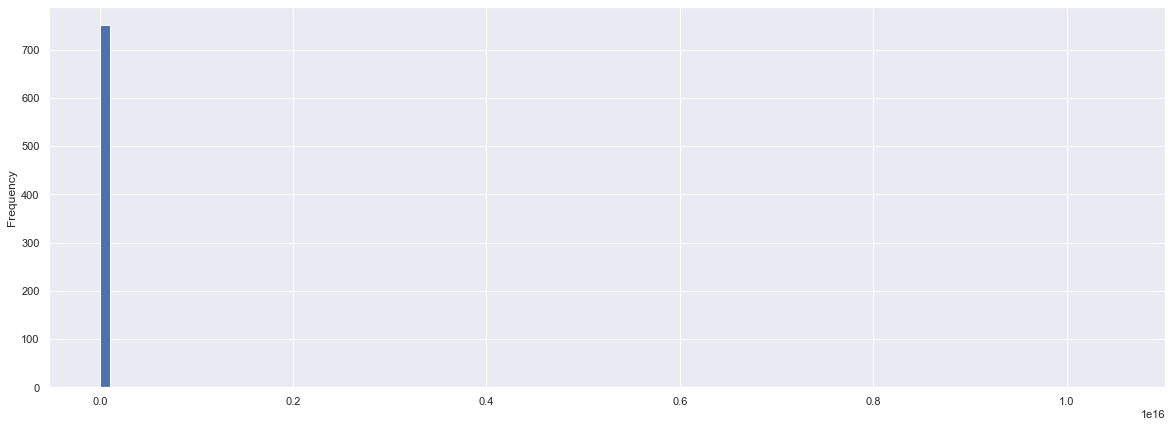

In [433]:
HS.mean().plot.hist(bins=100, figsize=(20,7))

Apparantly there are a few outlying flies in our ointment..

In [434]:
# step 1 trimming the edges
HS = HS.apply(featurewise_outlier_replacer, q=(0.01, 0.99))
# step 2 looking for remaining univariate outliers

# Categorical encoding

In [435]:
# https://github.com/scikit-learn-contrib/categorical-encoding
dummy_cols = ['HS_AGE', 'HS_History', 'HS_ECG', 'HS_new2', 'HS_RiskFacts', 'HN_TN']
HS[dummy_cols] = HS[dummy_cols].astype('category')
HS = pd.get_dummies(HS, prefix_sep={_dummy: "_dummy_" for _dummy in dummy_cols})
dummy_cols = [_col for _col in HS.columns if '_dummy_' in _col]

hs_cols = ['tn_admission']+dummy_cols

HS.loc[HS['tn_admission']>4000, 'tn_admission'] = 4000
HS.loc[HS['tn_slope2']<-100, 'tn_slope2'] = 100

HS['tn_diff_abs'] = HS[['tn_admission', 'tn_slope2']].apply(lambda x: np.sign(x[0]*x[1])*np.log10(np.abs(x[0]*x[1])+0.01), axis=1)
HS['tn_diff_rel'] = HS[['tn_admission', 'tn_slope2']].apply(lambda x: x[1]/(x[0]+1), axis=1)

tn_slope_cols= ['tn_slope2', 'tn_diff_abs', 'tn_diff_rel', 'tn_peak', 'tn_peak24']

col_dict['slope'] = tn_slope_cols
col_dict['hs'] = hs_cols

# Imputance

Do not impute, rather treat missingness as a feature

In [436]:
print("Num NaN columns : ECG {}\tCELLDYN {}\tOTHER {}".format((HS[ecg_cols].isna().sum(axis=0)>0).sum(),
                                                       (HS[cell_dyn_cols].isna().sum(axis=0)>0).sum(),
                                                       (HS[other_cols].isna().sum(axis=0)>0).sum()))
###
print("Num NaN samples : ECG {}\tCELLDYN {}\tOTHER {}\tALL {}".format((HS[ecg_cols].isna().sum(axis=1)>0).sum(),
                                                       (HS[cell_dyn_cols].isna().sum(axis=1)>0).sum(),
                                                       (HS[other_cols].isna().sum(axis=1)>0).sum(),
                                                       (HS.isna().sum(axis=1)>0).sum()))

Num NaN columns : ECG 4	CELLDYN 0	OTHER 1
Num NaN samples : ECG 75	CELLDYN 0	OTHER 64	ALL 135


In [437]:
if remove_nan_patients:
    nan_patients = HS[var_cols].isna().sum(axis=1)[HS[var_cols].isna().sum(axis=1)>0].index
    HS.drop(index=nan_patients, inplace=True)
    print("Num NaN samples : ECG {}\tCELLDYN {}\tOTHER {}".format((HS[ecg_cols].isna().sum(axis=1)>0).sum(),
                                                       (HS[cell_dyn_cols].isna().sum(axis=1)>0).sum(),
                                                       (HS[other_cols].isna().sum(axis=1)>0).sum()))
    
    print("Num NaN columns : ECG {}\tCELLDYN {}\tOTHER {}".format((HS[ecg_cols].isna().sum(axis=0)>0).sum(),
                                                           (HS[cell_dyn_cols].isna().sum(axis=0)>0).sum(),
                                                           (HS[other_cols].isna().sum(axis=0)>0).sum()))   

    # y = HS[['target']]

In [438]:
# imputance

# consider adding Gaussian noise on top of the prediction
# https://www.kaggle.com/shashankasubrahmanya/missing-data-imputation-using-regression
var_cols = get_var_cols(col_dict)
if missing_dummy:
    # for NaN cols, treat non-nan as 0, nan as 1
    _c = HS[var_cols].columns
    nan_cols = _c[(HS[var_cols].isna().sum()>0)==True].tolist()  
    print("---- There are {} columns to be imputed or removed, correct? \n \
          ---- the columns are: {}".format(len(nan_cols), nan_cols))
    dummy_list = []
    for _ncol in nan_cols:
        dummy_name = 'availdummy_'+_ncol
        dummy_list.append(dummy_name)
        HS[dummy_name] = (~pd.isna(HS[_ncol])).astype(int)
        var_cols.append(dummy_name)
        dummy_comb = "_".join(dummy_list)
        HS[dummy_comb] = HS[dummy_list].apply(lambda x: np.product(x), axis=1)
        col_dict[group_dict[_ncol]] = col_dict[group_dict[_ncol]] + [dummy_name, dummy_comb] # should be included in the relevant feature group (ecg, celldyn, other)
    if remove_nan_cols:
        # remove NaN cols
        nan_cols = list(set(nan_cols)-set(['BMI']))
        HS.drop(nan_cols, axis=1, inplace=True)
        var_cols = list(set(var_cols) - set(nan_cols))
        col_dict = _rem_cols(col_dict, nan_cols)

if HS[var_cols].isna().sum().sum()>0:
    nan_cols = list(HS[var_cols].isna().sum()[HS[var_cols].isna().sum()>0].index)
    dat = HS.copy()
    if imputance is not None:
        if isinstance(imputance, dict):
            for _imp_key, _imp_val in imputance.items():
                if type(_imp_val)==str:
                    if _imp_val == 'median': 
                        dat.loc[dat[_imp_key].isna(), _imp_key] = np.nanmedian(dat[_imp_key])
                    elif _imp_val == 'mean':
                        dat.loc[dat[_imp_key].isna(), _imp_key] = np.nanmean(dat[_imp_key])
                    elif _imp_val == 'remove':
                        dat = dat.dropna(subset=[_imp_key])
                elif 'sklearn' in str(type(_imp_val)):  
                    _sub_cols = list(set(var_cols)  - set(nan_cols))
                    _y = dat.loc[~dat[_imp_key].isna(), _imp_key]
                    _X_train = dat.loc[~dat[_imp_key].isna(), _sub_cols]
                    _X_test = dat.loc[dat[_imp_key].isna(), _sub_cols]
                    try:
                        dat.loc[dat[_imp_key].isna(), _imp_key] = _imp_val.fit(_X_train, _y).predict(_X_test)
                    except Exception as e:
                        print("Imputance failed for {}, shapes: {}, {}, {}".format(_imp_key, _X_train.shape, _y.shape, _X_test.shape))
                        if _X_test.shape[0]==0:
                            print("Hmm, you probably already ran the imputer, please reload the data...")
        else:
            if imputance=='iterative':
                imp = IterativeImputer(estimator=BayesianRidge(), max_iter=10)
            elif imputance=='knnimputer':
                imp= KNNImputer(n_neighbors=5)

            dat = pd.DataFrame(data=imp.fit_transform(dat[var_cols]), index=HS.index, columns=var_cols)
            dat = dat.join(dat[meta_cols])
else:
    dat = HS

---- There are 5 columns to be imputed or removed, correct? 
           ---- the columns are: ['P_RInterval_ECG', 'PAxis_ECG', 'BMI', 'POffset_ECG', 'POnset_ECG']


In [439]:
print(len(col_dict['ecg']), len(col_dict['celldyn']), len(col_dict['other']))

print("PRE: Condition numbers:\n\t\t ECG {}, \t CELLDYN {}, \t Other {}".format(_condition_number(dat[col_dict['ecg']]), 
                                                                        _condition_number(dat[col_dict['celldyn']]),
                                                                        _condition_number(dat[col_dict['other']])))

642 82 18
PRE: Condition numbers:
		 ECG 4.020509546496846e+19, 	 CELLDYN 6.219805243100422e+21, 	 Other 35592.647165919836


# Dimension reduction

## Cross-decomposition

**PLS, CCA, ICA, SNF** can be used to select informative combinations between feature sets, say between celldyn and ECG. 


## Scaling, a priori

In [440]:
if scaling_apriori:
    if scaler is not None:
        if isinstance(scaler, dict):        
            for _imp_key, _scaler in scaler.items():
                if _scaler is not None:
                    dat[col_dict[_imp_key]] = _scaler.fit_transform(dat[col_dict[_imp_key]]) 
        else:   
            _cols = col_dict['ecg']+col_dict['celldyn']
            dat[_cols] = pd.DataFrame(data=scaler.fit_transform(dat[_cols]), index=HS.index, columns=_cols)
    dat.apply(lambda x: sum(np.isinf(x))).sum(), dat.isna().sum().sum()

# Feature combiner

## Inter

By default 
* CELLDYN  - pheno: $\sqrt{A\cdot B}$ -> +200 features
* ECG AGG - pheno: $\sqrt{A\cdot B}$ 

In [441]:
feat_combo = dict()
feat_combo[('pheno', 'celldyn')] = ['SQRT']
feat_combo[('history', 'celldyn')] = ['SQRT']
feat_combo[('pheno', 'ecg_cols_agg')] = ['SQRT']
feat_combo[('history', 'ecg_cols_agg')] = ['SQRT']
inter_groups = []

for _tuple in feature_expansion_inter:
    inter_name = "_".join(_tuple)
    print("Combining {} and {}".format(_tuple[0], _tuple[1]))
    
    tcols_sqrt, tcols_div, tcols_sum = [], [], []
    
    _cols_l, _cols_r = col_dict[_tuple[0]], col_dict[_tuple[1]]
    
    if('SQRT' in feat_combo[_tuple]):        
        tcols_sqrt = _cols_(dat[_cols_l].columns.tolist(), cols_r = dat[_cols_r].columns.tolist(), prefix='inter_SQRT') 
        t = expander2(dat[_cols_l].values, y=dat[_cols_r].values, fun=_ssqrt)
        dat_sqrt = pd.DataFrame(data=t, index=dat.index, columns=tcols_sqrt)
        dat = dat.join(dat_sqrt)
        
    if('DIV' in feat_combo[_tuple]):
        tcols_div = _cols_(dat[_cols_l].columns.tolist(), cols_r = dat[_cols_r].columns.tolist(), prefix='inter_DIV') 
        t = expander2(dat[_cols_l].values, y=dat[_cols_r].values,fun=_divisor)
        dat_div = pd.DataFrame(data=t, index=dat.index, columns=tcols_div)  
        dat = dat.join(dat_div)
    
    if('SUM' in feat_combo[_tuple]):
        tcols_sum = _cols_(dat[_cols_l].columns.tolist(), cols_r = dat[_cols_r].columns.tolist(), prefix='inter_SUM') 
        t = expander2(dat[_cols_l].values, y=dat[_cols_r].values, fun=_sum)
        dat_sum = pd.DataFrame(data=t, index=dat.index, columns=tcols_sum)    
        dat = dat.join(dat_sum)    

    col_dict[inter_name] = list(set(tcols_sqrt + tcols_div + tcols_sum))    
    inter_groups.append(inter_name)

for inter in inter_groups:
    print("Added {} features for {}".format(len(col_dict[inter]), inter))

Combining pheno and celldyn
Combining pheno and ecg_cols_agg
Combining history and celldyn
Combining history and ecg_cols_agg
Added 246 features for pheno_celldyn
Added 75 features for pheno_ecg_cols_agg
Added 574 features for history_celldyn
Added 175 features for history_ecg_cols_agg


## Intra
By default 
* CELLDYN: $\frac{A}{A+B+\epsilon}$, $\sqrt{A\cdot B}$ -> +800 features
* ECG AGG: $A+B$, $\sqrt{A\cdot B}$

In [442]:
# history = ['SQRT']
# inter featureset : history * pheno

In [443]:
feat_combo = dict()
feat_combo['celldyn'] = ['SQRT', 'DIV']
feat_combo['ecg_cols_agg'] = ['SQRT', 'SUM']

for _key in feature_expansion_intra:
    print(_key)
    _cols = col_dict[_key]
    #dat[_cols] = dat[_cols].astype(np.float64)    
    tcols_sqrt, tcols_div, tcols_sum = [], [], []
    
    if('SQRT' in feat_combo[_key]):        
        tcols_sqrt = _cols_(dat[_cols].columns.tolist(), prefix='intra_SQRT')         
        t = expander2(dat[_cols].values, fun=_ssqrt)
        dat_sqrt = pd.DataFrame(data=t, index=dat.index, columns=tcols_sqrt)
        dat = dat.join(dat_sqrt)
        
    if('DIV' in feat_combo[_key]):
        tcols_div = _cols_(dat[_cols].columns.tolist(), prefix='intra_DIV') 
        t = expander2(dat[_cols].values, fun=_divisor)
        dat_div = pd.DataFrame(data=t, index=dat.index, columns=tcols_div)  
        dat = dat.join(dat_div)
    
    if('SUM' in feat_combo[_key]):
        tcols_sum = _cols_(dat[_cols].columns.tolist(), prefix='intra_SUM') 
        t = expander2(dat[_cols].values, fun=_sum)
        dat_sum = pd.DataFrame(data=t, index=dat.index, columns=tcols_sum)    
        dat = dat.join(dat_sum)    
    
    if _key in ['ecg_cols_agg', 'ecg_cols_dyn']:
        col_dict['ecg'] = list(set(col_dict['ecg']+_cols + tcols_sqrt + tcols_div + tcols_sum))
    else:
        col_dict[_key] = list(set(_cols + tcols_sqrt + tcols_div + tcols_sum))


SQRT_cols= [_col for _col in dat.columns.tolist() if 'SQRT_' in _col]
DIV_cols = [_col for _col in dat.columns.tolist() if 'DIV_' in _col]

print('SQRT cols:', dat[SQRT_cols].apply(lambda x: sum(np.isinf(x))).sum(), dat[SQRT_cols].isna().sum().sum())
print('DIV cols:', dat[DIV_cols].apply(lambda x: sum(np.isinf(x))).sum(), dat[DIV_cols].isna().sum().sum())
#
print('ECG cols:', dat[col_dict['ecg']].apply(lambda x: sum(np.isinf(x))).sum(), dat[col_dict['ecg']].isna().sum().sum())
print('CELLDYN cols:', dat[col_dict['celldyn']].apply(lambda x: sum(np.isinf(x))).sum(), dat[col_dict['celldyn']].isna().sum().sum())
#

gc.collect()

group_dict = {_v:k for k,v in col_dict.items() for _v in v}


celldyn
ecg_cols_agg
SQRT cols: 0 0
DIV cols: 0 0
ECG cols: 0 0
CELLDYN cols: 0 0


In [444]:
print("ECG: {} cols, \t CELLDYN: {} cols, \t OTHER: {} cols".format(len(col_dict['ecg']), len(col_dict['celldyn']), len(col_dict['other'])))

ECG: 1249 cols, 	 CELLDYN: 6724 cols, 	 OTHER: 18 cols


## Set distance between sample groups
See the [wiki](https://en.wikipedia.org/wiki/Hausdorff_distance) for the Hausdorff distance as an example set distance.

SciPy has a function readily available, see [directed Hausdorff](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.directed_hausdorff.html), 
and more optimised version like a [Fast Hausdorff distance](https://github.com/mavillan/py-hausdorff).

One way to find patient clusters is to maximize the Hausdoff distance between patient groups.

Feature selection through Hausdorff distance: **Given the target groups, iteratively add features if the feature increases the Hausdorff distance between the target groups**  

We use two types of set distance:
* Hausdorff distance
* Multidimensional Wasserstein distance

We iteratively add features based on their influence on the set-distance, 
to get an initial set-distance we start with the meta features **age**, **gender**, **BMI**.

In [445]:
prune_cols = inter_groups + prune_cols
prune_cols = list(set(prune_cols))
base_cols = [__column for _key in base_cols for __column in col_dict[_key]]

In [446]:
# for this step we use a scaled version of the dataset
qt = QuantileTransformer(n_quantiles=100, output_distribution='normal')
dat_tmp = pd.DataFrame(data=qt.fit_transform(dat), columns=dat.columns, index=dat.index)

In [447]:
tot = 0
print("We start with..")
for jdx, _group in enumerate(col_dict.keys()):
    print(" "*jdx, "For {} we have {} columns".format(_group, len(set(col_dict[_group]))))
    tot += len(set(col_dict[_group]))
print("We have a  total of {} columns".format(tot))

We start with..
 For ecg we have 1249 columns
  For celldyn we have 6724 columns
   For ecg_cols_agg we have 25 columns
    For ecg_cols_dyn we have 624 columns
     For history we have 7 columns
      For pheno we have 3 columns
       For troponine we have 1 columns
        For hs we have 25 columns
         For slope we have 5 columns
          For other we have 18 columns
           For pheno_celldyn we have 246 columns
            For pheno_ecg_cols_agg we have 75 columns
             For history_celldyn we have 574 columns
              For history_ecg_cols_agg we have 175 columns
We have a  total of 9751 columns


In [448]:
# Hausdorff
# we compare two groups, namely the groups defined by the targets, NSTEMI/Non-NSTEMI
# Simple variant: about 25 it/s
# Complete variant: about 

if hausdorff_feature_builder:
    extreme_samples = []
    keep_cols = defaultdict(list)
    added_cols = []
    set_distances = []
    old_dist = hausdorff(dat_tmp.loc[dat.target==0, base_cols].values, 
                         dat_tmp.loc[dat.target==1, base_cols].values)
    for _group in prune_cols:
        added_cols = [] 
        for idx, _col in tqdm(enumerate(col_dict[_group])):
            if complete_dist_improvement:
                _cols = base_cols + [_col] + added_cols
            else:
                _cols = base_cols + [_col]
                
            g1 = dat_tmp.loc[dat_tmp.target==0, _cols].values
            g2 = dat_tmp.loc[dat_tmp.target==1, _cols].values
            new_dist = hausdorff(g1, g2)
            set_distances.append({'idx': idx, 'sdist': new_dist[0]})

            # exclude these rows from the distance determination.
            extreme_samples.append(new_dist[1])
            extreme_samples.append(new_dist[2])

            if new_dist[0] > old_dist[0]:
                keep_cols[_group].append(_col)
                added_cols.append(_col)
            if complete_dist_improvement:
                old_dist = new_dist
                
    for _group in prune_cols:
        col_dict[_group]= keep_cols[_group]
    extreme_samples = list(set(extreme_samples))

    distdf = pd.DataFrame(set_distances)
    distdf['sdist'].plot.hist(bins=30)
    plt.axvline(old_dist[0], color='black')
    plt.title("Hausdorff distances")

    print("The Hausdorff distance is dominated by {} samples".format(len(extreme_samples)))
    print("{} ECG cols and {} CELLDYN cols add Hausdorff.distance".format(len(col_dict['ecg']), len(col_dict['celldyn'])))

In [449]:
# Wasserstein in multiple-dimensions, wasserstein of expanding product
# want to maximize wasserstein distance
# about 25 it/second
# ftilde = productsum(f+1), W(ftilde_1, ftilde_2)_new> _old
base_val = 0.5
if wasserstein_feature_builder:
    extreme_samples = []
    keep_cols = defaultdict(list)
    added_cols = []
    set_distances = []
    old_dist = wass_sup_distance(dat_tmp.loc[dat_tmp.target==0, base_cols].values+base_val, dat_tmp.loc[dat_tmp.target==1, base_cols].values+base_val)
    for _group in prune_cols:
        added_cols = []
        for idx, _col in tqdm(enumerate(col_dict[_group])):
            if complete_dist_improvement:
                _cols = base_cols + [_col] + added_cols
            else:
                _cols = base_cols + [_col]            
            _cols = base_cols + [_col]
            g1 = dat_tmp.loc[dat_tmp.target==0, _cols].values+base_val
            g2 = dat_tmp.loc[dat_tmp.target==1, _cols].values+base_val
            new_dist = wass_sup_distance(g1,g2)
            set_distances.append({'idx': idx, 'wdist': new_dist})
            
            if new_dist > old_dist:
                keep_cols[_group].append(_col)
                added_cols.append(_col)
            if complete_dist_improvement:
                old_dist = new_dist    
            
    for _group in prune_cols:
        col_dict[_group] = keep_cols[_group]

    distdf = pd.DataFrame(set_distances)
    distdf['wdist'].plot.hist(bins=30)
    plt.axvline(old_dist, color='black')
    plt.title("Wasserstein distances")

    print("{} ECG cols and {} CELLDYN cols add to the average Wasserstein distance".format(len(col_dict['ecg']), len(col_dict['celldyn'])))

In [450]:
# Pairwise distance: want to maximize average pairwise distance between sets, or as a proxy we can maximize the difference between the average feature vectors
# 
if pairwisedistance_feature_builder:
    extreme_samples = []
    keep_cols = defaultdict(list)
    added_cols = []
    set_distances = []
    old_dist = pairwise_distance(dat_tmp.loc[dat_tmp.target==0, base_cols].values, 
                                 dat_tmp.loc[dat_tmp.target==1, base_cols].values)
    for _group in prune_cols:
        added_cols = []
        for idx, _col in tqdm(enumerate(col_dict[_group])):
            if complete_dist_improvement:
                _cols = base_cols + [_col] + added_cols
            else:
                _cols = base_cols + [_col]            
            _cols = base_cols + [_col]
            g1 = dat_tmp.loc[dat_tmp.target==0, _cols].values
            g2 = dat_tmp.loc[dat_tmp.target==1, _cols].values
            new_dist = pairwise_distance(g1,g2)
            set_distances.append({'idx': idx, 'pdist': new_dist})
            
            if new_dist > old_dist:
                keep_cols[_group].append(_col)
                added_cols.append(_col)
            if complete_dist_improvement:
                old_dist = new_dist  
            
    for _group in prune_cols:
        col_dict[_group] = keep_cols[_group]

    distdf = pd.DataFrame(set_distances)
    distdf['pdist'].plot.hist(bins=30)
    plt.axvline(old_dist, color='black')
    plt.title("Pairwise distances")

    print("{} ECG cols and {} CELLDYN cols add to the average pairwise distance".format(len(col_dict['ecg']), 
                                                                                        len(col_dict['celldyn'])))

In [451]:
tot = 0
for jdx, _group in enumerate(col_dict.keys()):
    print(" "*jdx, "For {} we have {} columns".format(_group, len(set(col_dict[_group]))))
    tot += len(set(col_dict[_group]))
print("We still have a  total of {} columns".format(tot))

 For ecg we have 1249 columns
  For celldyn we have 6724 columns
   For ecg_cols_agg we have 25 columns
    For ecg_cols_dyn we have 624 columns
     For history we have 7 columns
      For pheno we have 3 columns
       For troponine we have 1 columns
        For hs we have 25 columns
         For slope we have 5 columns
          For other we have 18 columns
           For pheno_celldyn we have 246 columns
            For pheno_ecg_cols_agg we have 75 columns
             For history_celldyn we have 574 columns
              For history_ecg_cols_agg we have 175 columns
We still have a  total of 9751 columns



## Ensemble tree estimator feature contributions

In [452]:
keep_cols = dict()
if extratrees_feature_builder:
    base_cols = [__column for _key in prune_cols for __column in col_dict[_key]]
    ET = ExtraTreesClassifier(n_estimators=1000, n_jobs=8)
    ET.fit(X=dat[base_cols], y=dat['target'])
    importances = ET.feature_importances_
    all_groups = np.array(base_cols)[np.argsort(importances)[-top_n_all:]].tolist()
    
    for _group in prune_cols:
        _cols = col_dict[_group]
        ET = ExtraTreesClassifier(n_estimators=1000, n_jobs=8)
        ET.fit(X=dat[_cols], y=dat['target'])
        importances = ET.feature_importances_
        keep_cols[_group] = np.array(_cols)[np.argsort(importances)[-top_n[_group]:]].tolist()
        col_dict[_group] = list(set(keep_cols[_group] + [_col for _col in all_groups if group_dict[_col]==_group]))
        
    print("{} ECG cols and {} CELLDYN cols add to the average pairwise distance".format(len(col_dict['ecg']), 
                                                                                        len(col_dict['celldyn'])))

415 ECG cols and 575 CELLDYN cols add to the average pairwise distance


## PCA
Contribution to first principal components.


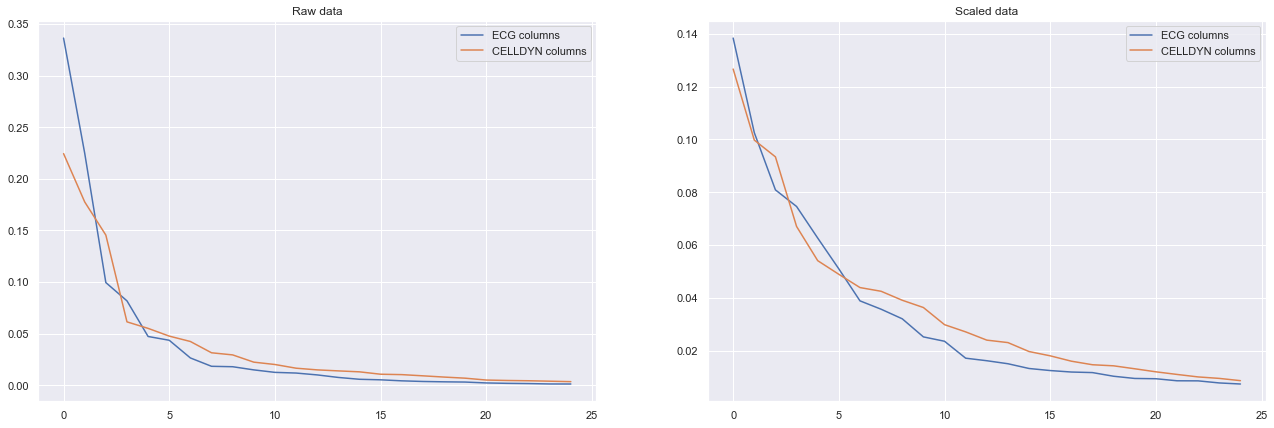

In [453]:
ncomp=25
fig, ax = plt.subplots(ncols=2, figsize=(22,7))
raw_pcre = PCA(n_components=ncomp)
raw_pcre.fit(dat[col_dict['ecg']])

raw_pcrd = PCA(n_components=ncomp)
raw_pcrd.fit(dat[col_dict['celldyn']])

ax[0].plot(raw_pcre.explained_variance_ratio_, label='ECG columns')
ax[0].plot(raw_pcrd.explained_variance_ratio_, label='CELLDYN columns')
ax[0].set_title("Raw data")
###########
scaled_pcre = PCA(n_components=ncomp)
scaled_pcre.fit(dat_tmp[col_dict['ecg']])

scaled_pcrd = PCA(n_components=ncomp)
scaled_pcrd.fit(dat_tmp[col_dict['celldyn']])

ax[1].plot(scaled_pcre.explained_variance_ratio_, label='ECG columns')
ax[1].plot(scaled_pcrd.explained_variance_ratio_, label='CELLDYN columns')
ax[1].set_title("Scaled data")

ax[0].legend()
ax[1].legend()

In [454]:
raw_pcweights = get_pca_weights(reducer=raw_pcrd, cols=col_dict['celldyn'], ncomp=10)
raw_pcweightsE = get_pca_weights(reducer=raw_pcre, cols=col_dict['ecg'], ncomp=10)

scaled_pcweights = get_pca_weights(reducer=scaled_pcrd, cols=col_dict['celldyn'], ncomp=10)
scaled_pcweightsE = get_pca_weights(reducer=scaled_pcre, cols=col_dict['ecg'], ncomp=10)


Text(0.5, 1.0, 'Scaled data')

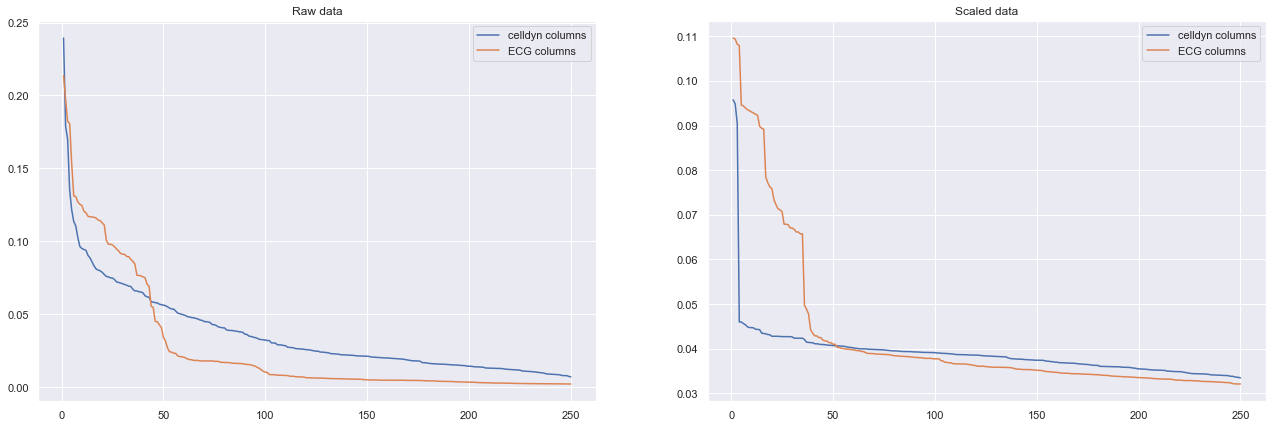

In [455]:
fig, ax = plt.subplots(ncols=2, figsize=(22,7))
ncomp = 250
x = ncomp-np.arange(0,ncomp)
ax[0].plot(x, list(raw_pcweights.values())[-ncomp:], label='celldyn columns')
ax[0].plot(x, list(raw_pcweightsE.values())[-ncomp:], label='ECG columns')
ax[0].legend()
ax[0].set_title("Raw data")

ax[1].plot(x, list(scaled_pcweights.values())[-ncomp:], label='celldyn columns')
ax[1].plot(x, list(scaled_pcweightsE.values())[-ncomp:], label='ECG columns')
ax[1].legend()
ax[1].set_title("Scaled data")

## Power indices

If we view the features as "players" in a game that compete with other features to score points (i.e. predict the targets) we
can apply game theoretical power indices to assess the strenght or power of a particular feature.
Power indices are : Penrose-Banzhaf, Shapley-Shubik, Coleman-Shapley.

## WE ARE NOW DONE WITH ADDING COLUMNS

In [456]:
inter_ecgs = [_group for _group in inter_groups if 'ecg' in _group]
inter_celldyn = [_group for _group in inter_groups if 'celldyn' in _group]

inter_ecg_cols = [_col for _g in inter_ecgs for _col in col_dict[_g]]
inter_celldyn_cols = [_col for _g in inter_celldyn for _col in col_dict[_g]]

### Relative variance

Removing 0 columns due to lack of variance
POST: Condition numbers:
		 ECG 1.0739323438976842e+21, 	 CELLDYN 5.107186183204896e+21, 	 Other 35592.647165919836


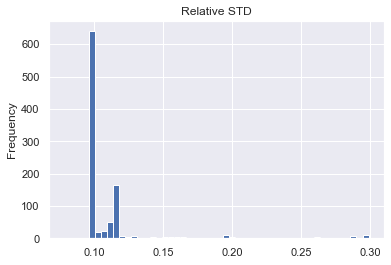

In [457]:
if variance_remove:
    eps=1e-6
    def remove_min_variance(x, threshold=0.001):
        eps=1e-6
        cols_to_keep = x.columns[(((x.var()+eps**2)/(x.max()-x.min()+eps))>threshold)]   
        drop_cols = list(set(x.columns)-set(cols_to_keep))
        return x[cols_to_keep], drop_cols
    _cols = col_dict['ecg']+col_dict['celldyn']
    tmp_keep, drop_cols = remove_min_variance(dat_tmp[_cols], threshold=0.05)
    print("Removing {} columns due to lack of variance".format(dat_tmp[_cols].shape[1] - tmp_keep.shape[1]))

    col_dict['ecg'] = list(set(col_dict['ecg']).difference(set(drop_cols)))
    col_dict['celldyn'] = list(set(col_dict['celldyn']).difference(set(drop_cols)))

    ((tmp_keep.std()+eps)/(tmp_keep.max() - tmp_keep.min()+eps)).plot.hist(bins=50)
    plt.title('Relative STD')

    print("POST: Condition numbers:\n\t\t ECG {}, \t CELLDYN {}, \t Other {}".format(_condition_number(dat[col_dict['ecg']]), 
                                                                            _condition_number(dat[col_dict['celldyn']]),
                                                                            _condition_number(dat[col_dict['other']])))

We also want to deal with the very large variance features as they may contain little information, yet 

In [458]:
_cols = col_dict['ecg']+col_dict['celldyn']
large_variance_features = dat_tmp[_cols].columns[dat[_cols].std()>0.3]

To remove low-variant features is actually to remove low entropy features. As the idea of low variance is completely dependent on the scaling of the feature low entropy will give a 
more robust feature filter. For continuous variables we have to use *differential entropy*, described as; 
$$H = - \int \rho(x) \ln \rho(x) dx $$

The best we can do is to approximate this using the histograms of the features;

$$H \approx - \sum \rho(b_i) \ln \rho(b_i) \Delta x_i$$

where $b_i$ represent the bins. To bound it between zero and one we should write

$$H \approx - \frac{\sum \rho(b_i) \ln \rho(b_i) \Delta x_i}{\sum \Delta x_i}$$

Note that the correct differential entropy is actually written as 
$$H = - \int \rho(x) \ln \frac{\rho(x)}{m(x)} dx $$

where $m(x)$ is the invariant measure.

In [459]:
_cols = col_dict['ecg']+col_dict['celldyn']
feat_entropy = pd.DataFrame(data=dat_tmp[_cols].apply(func=_diff_entropy, axis=0).apply(pd.Series))
feat_entropy.columns = ['Hr']

<ipython-input-426-22a891b9df8c>:123: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "_diff_entropy" failed type inference due to: non-precise type pyobject
[1] During: typing of argument at <ipython-input-426-22a891b9df8c> (125)

File "<ipython-input-426-22a891b9df8c>", line 125:
def _diff_entropy(x, eps=1e-6, bins=20):
    rhos, xs = np.histogram(x, density=True, bins=bins)
    ^

  @jit
INFO (2020-02-12 06:20:20): finding looplift candidates
H:\PythonVENV\Envs\base\lib\site-packages\numba\object_mode_passes.py:178: NumbaWarning: Function "_diff_entropy" was compiled in object mode without forceobj=True.

File "<ipython-input-426-22a891b9df8c>", line 124:
@jit
def _diff_entropy(x, eps=1e-6, bins=20):
^

  state.func_ir.loc))
H:\PythonVENV\Envs\base\lib\site-packages\numba\object_mode_passes.py:188: NumbaDeprecationWarning: 
Fall-back from the nopython compilation path to the object mode compilation path has been detected, this is d

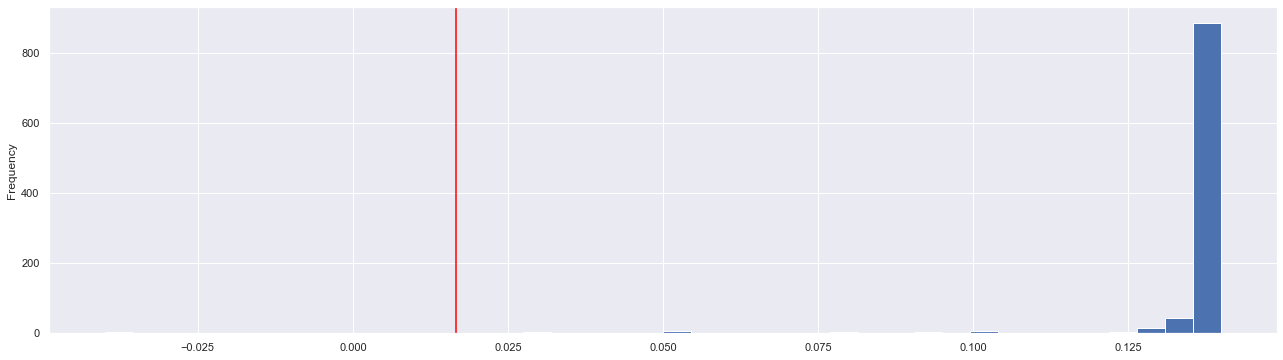

In [460]:
fig, ax = plt.subplots(figsize=(22,6))
feat_entropy.Hr.plot.hist(bins=40, ax=ax)
ax.axvline(feat_entropy.Hr.quantile(0.01), color='red')

HIGH 990 LOW 0


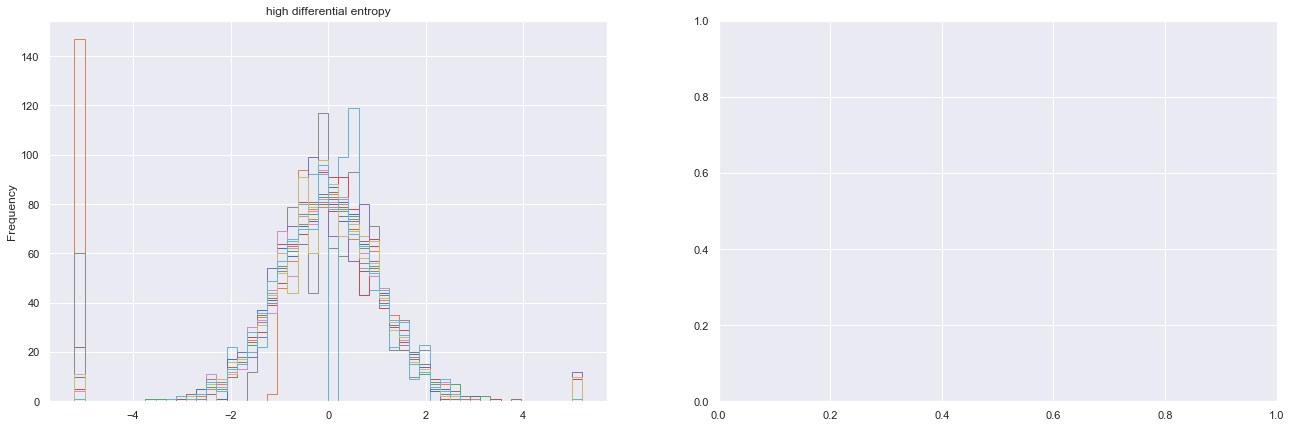

In [461]:
high_hr = feat_entropy.loc[(feat_entropy.Hr>-2)].index
low_hr = feat_entropy.loc[(feat_entropy.Hr<-2)].index
print("HIGH", len(high_hr), "LOW", len(low_hr))

fig, ax = plt.subplots(ncols=2, figsize=(22,7))
n = 20 
N = len(high_hr)
for i in range(0, n):
    j = np.random.randint(0, N)
    dat_tmp[high_hr[j]].plot.hist(bins=50, histtype='step', ax=ax[0])
ax[0].set_title('high differential entropy')
N = len(low_hr)    
if N>0:
    for i in range(0, n):
        j = np.random.randint(0, N)
        dat_tmp[low_hr[j]].plot.hist(bins=50, histtype='step', ax=ax[1])
    ax[1].set_title('low differential entropy')


In [462]:
# remove low HR cols
if remove_low_diffEntropy:
    #dat_tmp.drop(list(low_hr), axis=1, inplace=True)
    col_dict = _rem_cols(col_dict, list(low_hr))

## feature selection

We use the union of featuresets obtained by applying 
* ANOVA 
* KS
* mutual information value

with visually determined cut-off values. Of course there is a range of alternatives such as recursive feature elimination but that is beyond the scope of this work.

In [463]:
from sklearn.feature_selection import f_classif, chi2, mutual_info_classif

y = dat['target']

if remove_weak_univariates:
    anov = dict()
    anov['celldyn'] = pd.DataFrame(data=f_classif(dat_tmp[col_dict['celldyn']], y), columns=col_dict['celldyn'], index=['F', 'pval']).T
    anov['ecg'] = pd.DataFrame(data=f_classif(dat_tmp[col_dict['ecg']], y), columns=col_dict['ecg'], index=['F', 'pval']).T
    anov['other'] = pd.DataFrame(data=f_classif(dat_tmp[col_dict['other']], y), columns=col_dict['other'], index=['F', 'pval']).T

    chisq = dict()
    chisq['celldyn'] = pd.DataFrame(data=chi2(dat_tmp[col_dict['celldyn']].abs(), y), columns=col_dict['celldyn'], index=['Chi', 'pval']).T
    chisq['ecg'] = pd.DataFrame(data=chi2(dat_tmp[col_dict['ecg']].abs(), y), columns=col_dict['ecg'], index=['Chi', 'pval']).T
    chisq['other'] = pd.DataFrame(data=chi2(dat_tmp[col_dict['other']].abs(), y), columns=col_dict['other'], index=['Chi', 'pval']).T

    mi = dict()
    mi['celldyn'] = pd.DataFrame(data=mutual_info_classif(dat_tmp[col_dict['celldyn']].abs(), y), index=col_dict['celldyn'], columns=['mi'])
    mi['ecg'] = pd.DataFrame(data=mutual_info_classif(dat_tmp[col_dict['ecg']].abs(), y), index=col_dict['ecg'], columns=['mi'])
    mi['other'] = pd.DataFrame(data=mutual_info_classif(dat_tmp[col_dict['other']].abs(), y), index=col_dict['other'], columns=['mi'])


    ks_dist = dict()
    KS = fs_ks()
    KS.fit(dat[col_dict['other']].values, y)
    ks_dist['other'] = pd.DataFrame(KS.results_, columns=['KS', 'pval'], index=col_dict['other'])

    KS.fit(dat[col_dict['celldyn']].values, y)
    ks_dist['celldyn'] = pd.DataFrame(KS.results_, columns=['KS', 'pval'], index=col_dict['celldyn'])

    KS.fit(dat[col_dict['ecg']].values, y)
    ks_dist['ecg'] = pd.DataFrame(KS.results_, columns=['KS', 'pval'], index=col_dict['ecg'])

    try:
        mwu_dist = dict()
        MW = fs_mannwhitney()
        MW.fit(dat[col_dict['other']].values, y)
        mwu_dist['other'] = pd.DataFrame(MW.results_, columns=['MWS', 'pval'], index=col_dict['other'])

        MW.fit(dat[col_dict['celldyn']].values, y)
        mwu_dist['celldyn'] = pd.DataFrame(MW.results_, columns=['MWS', 'pval'], index=col_dict['celldyn'])

        MW.fit(dat[col_dict['ecg']].values, y)
        mwu_dist['ecg'] = pd.DataFrame(MW.results_, columns=['MWS', 'pval'], index=col_dict['ecg'])

        mwu_dist['celldyn']['MWS'] = 4*(mwu_dist['celldyn']['MWS'])/(dat.shape[0]*(dat.shape[0]+1))
        mwu_dist['ecg']['MWS'] = 4*(mwu_dist['ecg']['MWS'])/(dat.shape[0]*(dat.shape[0]+1))
        mwu_dist['other']['MWS'] = 4*(mwu_dist['other']['MWS'])/(dat.shape[0]*(dat.shape[0]+1))
    except Exception as e:
        print("Perhaps there is something wrong with your scaling?")

    try:
        epps_dist = dict()
        EPPS = fs_epps()
        EPPS.fit(dat[col_dict['other']].values, y)
        epps_dist['other'] = pd.DataFrame(EPPS.results_, columns=['EPPS', 'pval'], index=col_dict['other'])

        EPPS.fit(dat[col_dict['ecg']].values, y)
        epps_dist['ecg'] = pd.DataFrame(EPPS.results_, columns=['EPPS', 'pval'], index=col_dict['ecg'])

        EPPS.fit(dat[col_dict['celldyn']].values, y)
        epps_dist['celldyn'] = pd.DataFrame(EPPS.results_, columns=['EPPS', 'pval'], index=col_dict['celldyn'])
    except Exception as e:
        if str(e)=='SVD did not converge':
            print("!! \t Remove the multicollinearity of the input matrix \t!!")
        else:
            print("Oooeps: {}".format(e))

    # w1
    wass1_dist = dict()
    W1D = fs_ws1()
    W1D.fit(dat[col_dict['other']].values, y)
    wass1_dist['other'] = pd.DataFrame(W1D.scores_, columns=['W1'], index=col_dict['other'])

    W1D.fit(dat[col_dict['celldyn']].values, y)
    wass1_dist['celldyn'] = pd.DataFrame(W1D.scores_, columns=['W1'], index=col_dict['celldyn'])

    W1D.fit(dat[col_dict['ecg']].values, y)
    wass1_dist['ecg'] = pd.DataFrame(W1D.scores_, columns=['W1'], index=col_dict['ecg'])

    # w2
    wass2_dist = dict()
    W2D = fs_ws2()
    W2D.fit(dat[col_dict['other']].values, y)
    wass2_dist['other'] = pd.DataFrame(W2D.scores_, columns=['W2'], index=col_dict['other'])

    W2D.fit(dat[col_dict['celldyn']].values, y)
    wass2_dist['celldyn'] = pd.DataFrame(W2D.scores_, columns=['W2'], index=col_dict['celldyn'])

    W2D.fit(dat[col_dict['ecg']].values, y)
    wass2_dist['ecg'] = pd.DataFrame(W2D.scores_, columns=['W2'], index=col_dict['ecg'])

    ##############
    ### FILTER ###
    ##############
#if remove_weak_univariates:
    fig, ax = plt.subplots(ncols=5, figsize=(20, 8))
    anov['ecg'].F.plot.kde(label='ecg', ax=ax[0])
    anov['celldyn'].F.plot.kde(label='celldyn', ax=ax[0])
    ax[0].set_title("ANOVA F-score")
    ax[0].axvline(1, color='black')
    ax[0].legend()
    
    ks_dist['ecg'].KS.plot.kde(label='ecg', ax=ax[1])
    ks_dist['celldyn'].KS.plot.kde(label='celldyn', ax=ax[1])
    ax[1].set_title("KS score")    
    ax[1].axvline(0.08, color='black')
    ax[1].legend()
    
    mi['ecg'].mi.plot.kde(label='ecg', ax=ax[2])
    mi['celldyn'].mi.plot.kde(label='celldyn', ax=ax[2])
    ax[2].set_title("MI value")
    ax[2].axvline(0.001, color='black')
    ax[2].legend()
    
    wass1_dist['ecg'].W1.plot.kde(label='ecg', ax=ax[3])
    wass1_dist['celldyn'].W1.plot.kde(label='celldyn', ax=ax[3])
    ax[3].set_title("EMD distance")
    ax[3].axvline(0.03, color='black')
    ax[3].legend()
    
    wass2_dist['ecg'].W2.plot.kde(label='ecg', ax=ax[4])
    wass2_dist['celldyn'].W2.plot.kde(label='celldyn', ax=ax[4])
    ax[4].set_title("Energy distance")
    ax[4].axvline(0.06, color='black')
    ax[4].legend()

In [464]:
if remove_weak_univariates:
    ecg_inc_ks = ks_dist['ecg'][ks_dist['ecg'].KS>0.08].index.tolist()
    celldyn_inc_ks = ks_dist['celldyn'][ks_dist['celldyn'].KS>0.08].index.tolist()
    
    ecg_inc_anova = anov['ecg'][anov['ecg'].F>1].index.tolist()
    celldyn_inc_anova = anov['celldyn'][anov['celldyn'].F>1].index.tolist()

    ecg_inc_mi = mi['ecg'][mi['ecg'].mi>0.001].index.tolist()
    celldyn_inc_mi = mi['celldyn'][mi['celldyn'].mi>0.001].index.tolist()

    
    ecg_inc_wass = wass1_dist['ecg'][wass1_dist['ecg'].W1>0.15].index.tolist()
    celldyn_inc_wass = wass1_dist['celldyn'][wass1_dist['celldyn'].W1>0.15].index.tolist()

    ecg_inc_wass2 = wass2_dist['ecg'][wass2_dist['ecg'].W2>0.025].index.tolist()
    celldyn_inc_wass2 = wass2_dist['celldyn'][wass2_dist['celldyn'].W2>0.025].index.tolist()
    
    tot_scores_ecg = pd.concat([ks_dist['ecg'], anov['ecg'], wass1_dist['ecg'], wass2_dist['ecg'], mi['ecg'], chisq['ecg']], axis=1)
    tot_scores_celldyn = pd.concat([ks_dist['celldyn'], anov['celldyn'], wass1_dist['celldyn'], wass2_dist['celldyn'], mi['celldyn'], chisq['celldyn']], axis=1)

    tot_scores_ecg.drop('pval', axis=1, inplace=True)
    tot_scores_celldyn.drop('pval', axis=1, inplace=True)

    mmscaler = MinMaxScaler()
    X=mmscaler.fit_transform(tot_scores_ecg)
    _cols=tot_scores_ecg.columns.tolist()
    ecg_scores = pd.DataFrame(data=X, index=tot_scores_ecg.index, columns=_cols)

    X=mmscaler.fit_transform(tot_scores_celldyn)
    _cols=tot_scores_celldyn.columns.tolist()
    celldyn_scores = pd.DataFrame(data=X, index=tot_scores_celldyn.index, columns=_cols)

    ecg_scores['AVG'] =ecg_scores.apply(lambda x: x.mean(), axis=1)
    celldyn_scores['AVG'] = celldyn_scores.apply(lambda x: x.mean(), axis=1)    
    
    print("PRE: ECG cols {}, CELLDYN cols {}".format(len(col_dict['ecg']), len(col_dict['celldyn'])))
    
    if isinstance(keep_strongest_N, int):
        print("Keeping strongest {}".format(keep_strongest_N))
        assert keep_strongest_N>50, 'Sorry, we want a minimum of 50 features'
        # we have keep_strongest_N features to keep
        # we want to prune the ecg, celldyn features
        Ntot = keep_strongest_N #- (dat.shape[1]-len(col_dict['ecg'])-len(col_dict['celldyn']))
        # we use the number of the current ecg/celldyn cols as the weights
        Necg, Ncelldyn = len(col_dict['ecg']), len(col_dict['celldyn'])
        w_ecg, w_celldyn = Necg/(Necg+Ncelldyn), Ncelldyn/(Necg+Ncelldyn)
        Necg = int(w_ecg*Ntot)
        Ncelldyn = int(w_celldyn*Ntot)
        # we want to keep only the top features
        ecg_cols_to_keep = ecg_scores.sort_values('AVG', ascending=False)[:Necg].index.tolist()
        celldyn_cols_to_keep = celldyn_scores.sort_values('AVG', ascending=False)[:Ncelldyn].index.tolist()
        
        col_dict['ecg'] = list(set(ecg_cols_to_keep))
        col_dict['celldyn'] = list(set(celldyn_cols_to_keep))
    else:
        if univariate_inclusive:
            col_dict['ecg'] = list(set(ecg_inc_anova+ecg_inc_mi+ecg_inc_ks+ecg_inc_wass+ecg_inc_wass2))
            col_dict['celldyn'] = list(set(celldyn_inc_anova+celldyn_inc_mi+celldyn_inc_ks+celldyn_inc_wass+celldyn_inc_wass2))
        else:
            col_dict['ecg'] = list(set(ecg_inc_anova).intersection(set(ecg_inc_mi), set(ecg_inc_ks), set(ecg_inc_wass), set(ecg_inc_wass2)))
            col_dict['celldyn'] = list(set(celldyn_inc_anova).intersection(set(celldyn_inc_mi), set(celldyn_inc_ks), set(celldyn_inc_wass), set(celldyn_inc_wass2)))            
        
    print("POST: ECG cols {}, CELLDYN cols {}".format(len(col_dict['ecg']), len(col_dict['celldyn'])))
        

## Multi-collinearity

I.e. **the problem of removing all correlated pairs as efficiently as possible, meaning by removing a minimum number of nodes at the lowest computational cost.**

The efficient removal of multicollinearity can be cast in graph optimisation problem.

* Maximal Clique Enumeration (MCE): from all the maximal non-overlapping cliques, keep only the node with the lowest mean similarity. This is iterative; 
    * start with the largest cliques, exclude, redetermine cliques, exclude, etc. Until only pairs are left
    * Remove all nodes with occurrence > 1, then randomly remove nodes   
* Recursively remove 50% of the pairs until no pairs are left
* Instead of removing the collinear pairs multiply them. 

Clique finders:
* Walktrap community
* Infomap
* Sparse Affinity propagation
* igraph.leading.eigenvector.community
* igraph.edge.betweenness.community
* label propagation: networkx.algorithms.community.label_propagation_communities
* Louvain method (fast community unfolding), multilevel community
* link clustering
* Markov clustering
* clique percolation method
* networkx.algorithms.clique.find_cliques


In [465]:
from sklearn.metrics.pairwise import cosine_similarity as cosim

In [466]:
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from statsmodels.tools.tools import add_constant
from sklearn.metrics.pairwise import cosine_similarity as cosim
import networkx as nx

def coll_cols(x, threshold=0.99, how='corr_aff', ignore_nan=True):
    '''
     x : df
     threshold : maximum correlation or maximum VIF
     how : correlation (corr_aff, corr_pair) of VIF-based (vif)
    '''
    cols = x.columns.tolist()
    cols_to_remove = None
    coll_cliques = []
    if ignore_nan:
        x=x.dropna() # x.fillna(x.median())   
    if how=='vif':
        cols_to_remove = []
        x = add_constant(x)
        x[cols] = StandardScaler().fit_transform(x[cols]) 
        vifs = []
        for idx, col in tqdm(enumerate(cols)):
            _vif = vif(x.values, idx)
            if _vif != np.inf:                
                vifs.append(_vif)
            if vif(x.values, idx)>threshold:
                cols_to_remove.append(col)
        vifs = np.array(vifs)
        print("VIF:\t max {}, \t min {}, \t mean {}, \t median {}".format(vifs.max(), vifs.min(), vifs.mean(), np.median(vifs)))
        plt.hist(np.log10(vifs), bins=50, density=True)
    elif how=='corr_aff':
        corrcoefs = np.abs(cosim(x.T)) # x.corr().values  # np.corrcoef(tmp[var_cols]) , tmp[var_cols].corr().values       
        #corrcoefs[np.abs(corrcoefs)>threshold] = 0
        #corrcoefs[np.abs(corrcoefs)<=threshold] = 1
        AF = AffinityPropagation(damping=0.75, max_iter=400, convergence_iter=50, preference=None, affinity='precomputed')
        AF.fit_predict(-corrcoefs)
        _coll_cliques = AF.labels_
        coll_cliques = defaultdict(list)
        for idx, _lab in enumerate(_coll_cliques):
            coll_cliques[_lab] = coll_cliques[_lab]+[idx]
        new_list = []
        for k,v in coll_cliques.items():
            new_list.append(list(set([k]+v)))
        coll_cliques = new_list
        exemplars = AF.cluster_centers_indices_
        cols_to_remove = [cols[i] for i in exemplars]
    elif how =='corr_clique':
        corrcoefs = np.abs(cosim(x.T)) #x.corr().values  # np.corrcoef(tmp[var_cols]) , tmp[var_cols].corr().values         
        corrcoefs[np.abs(corrcoefs)>threshold] = 1
        corrcoefs[np.abs(corrcoefs)<=threshold] = 0
        corrcoefs = corrcoefs.astype(np.int32)
        G = nx.Graph(corrcoefs)
        coll_cliques = list(nx.algorithms.clique.find_cliques(G))
        coll_cliques = [_clique for _clique in coll_cliques if len(_clique)>1]
        cols_to_remove = list(set([_node for _clique in coll_cliques for _node in _clique if len(_clique)>1]))
        cols_to_remove = [cols[i] for i in cols_to_remove]
    elif how=='corr_pair':
        # simplistic 
        corrcoefs = np.abs(cosim(x.T)) #x.corr().values # cosim(x) # x.corr().values # np.abs(np.corrcoef(x, rowvar=False)), cosim(x)
        print(corrcoefs.shape, x.shape)
        conn_count = { k: 0 for k in cols}
        _coll_cliques = defaultdict(list)
        for idx, _colx in enumerate(cols):
            for jdx, _coly in enumerate(cols):
                if jdx<idx:
                    if corrcoefs[idx, jdx]>threshold:
                        conn_count[_colx]  += 1
                        conn_count[_coly]  += 1
                        _coll_cliques[idx]  += [jdx]
                        _coll_cliques[jdx]  += [idx]         
        cols_to_remove = [cols[_v[0]] for _v in _coll_cliques.values()]
        for k,v in _coll_cliques.items():
            coll_cliques.append([k]+v)            
        coll_cliques=[sorted(_clique) for _clique in coll_cliques]
        coll_cliques.sort()
        coll_cliques = list(coll_cliques for coll_cliques,_ in itertools.groupby(coll_cliques))
    #print("{} columns should be removed due to collinearity.".format(len(cols_to_remove)))  
    return cols_to_remove, coll_cliques

In [468]:
cols_prior = dict()
col_dict['inter_celldyn'] = col_dict['history_celldyn'] + col_dict['pheno_celldyn']
col_dict['inter_ecg'] = col_dict['history_ecg_cols_agg'] + col_dict['pheno_ecg_cols_agg']

cols_prior['ecg'] = col_dict['ecg']
cols_prior['celldyn'] = col_dict['celldyn']
cols_prior['inter_celldyn'] = col_dict['inter_celldyn']
cols_prior['inter_ecg'] = col_dict['inter_ecg']

dat_tmp_old = dat_tmp
dat_old = dat

In [469]:
#################
col_dict['ecg'], col_dict['celldyn'], cols_prior['inter_celldyn'], cols_prior['inter_ecg'] = cols_prior['ecg'], cols_prior['celldyn'], cols_prior['inter_celldyn'], cols_prior['inter_ecg']
dat_tmp = dat_tmp_old
dat = dat_old
#################

In [470]:
print("PRE: Condition numbers for RAW set:\n\t\t ECG {}, \t CELLDYN {}, \t inter CELLDYN {} and \t inter ECG {}".format(_condition_number(dat[col_dict['ecg']]), 
                                                                            _condition_number(dat[col_dict['celldyn']]),
                                                                            _condition_number(dat[col_dict['inter_celldyn']]),
                                                                            _condition_number(dat[col_dict['inter_ecg']])))
print("PRE: Condition numbers for scaled set:\n\t\t ECG {}, \t CELLDYN {}, \t inter CELLDYN {} and \t inter ECG {}".format(_condition_number(dat_tmp[col_dict['ecg']]), 
                                                                            _condition_number(dat_tmp[col_dict['celldyn']]),
                                                                            _condition_number(dat_tmp[col_dict['inter_celldyn']]),
                                                                            _condition_number(dat_tmp[col_dict['inter_ecg']])))

if remove_multicoll:
    print("We start with {} ECG, {} CELLDYN, {} inter ECG and {} inter CELLDYN columns".format(len(col_dict['ecg']), len(col_dict['celldyn']), len(col_dict['inter_ecg']), len(col_dict['inter_celldyn'])))
    gc.collect()
    drop_cols_ecg, cliques_ecg = coll_cols(dat_tmp[col_dict['ecg']], how='corr_clique', threshold=0.99, ignore_nan=False)
    drop_cols_celldyn, cliques_celldyn = coll_cols(dat_tmp[col_dict['celldyn']], how='corr_clique', threshold=0.99, ignore_nan=False)
    drop_cols_intercell, cliques_intercell = coll_cols(dat_tmp[col_dict['inter_celldyn']], how='corr_clique', threshold=0.99, ignore_nan=False)
    drop_cols_interecg, cliques_interecg = coll_cols(dat_tmp[col_dict['inter_ecg']], how='corr_clique', threshold=0.99, ignore_nan=False)
    
    print("There are {} ECG cliques, {} CELLDYN cliques, {} intercelldyn cliques, {} interecg cliques".format(len(cliques_ecg), len(cliques_celldyn), len(cliques_intercell), len(cliques_interecg)))
    print("We remove {} ECG columns, {} CELLDYN columns, {} intercelldyn columns, {} interecg cliques".format(len(set(drop_cols_ecg)), len(set(drop_cols_celldyn)), len(cliques_intercell), len(cliques_interecg)))
    
    # replace the multicoll-columns
    dat_ecg_mcoll = process_cliques(dat, agg_function='amean', cliques=cliques_ecg, cols=col_dict['ecg'], prefix='mcoll_ecg_')
    dat_celldyn_mcoll = process_cliques(dat, agg_function='amean', cliques=cliques_celldyn, cols=col_dict['celldyn'], prefix='mcoll_celldyn')
    dat_interecg_mcoll = process_cliques(dat, agg_function='amean', cliques=cliques_interecg, cols=col_dict['inter_ecg'], prefix='mcoll_interecg_')
    dat_intercelldyn_mcoll = process_cliques(dat, agg_function='amean', cliques=cliques_intercell, cols=col_dict['inter_celldyn'], prefix='mcoll_intercelldyn')
    
    dat_ecg_mcoll_tmp = process_cliques(dat_tmp, agg_function='amean', cliques=cliques_ecg, cols=col_dict['ecg'], prefix='mcoll_ecg_')
    dat_celldyn_mcoll_tmp = process_cliques(dat_tmp, agg_function='amean', cliques=cliques_celldyn, cols=col_dict['celldyn'], prefix='mcoll_celldyn')
    dat_interecg_mcoll_tmp = process_cliques(dat_tmp, agg_function='amean', cliques=cliques_interecg, cols=col_dict['inter_ecg'], prefix='mcoll_interecg_')
    dat_intercelldyn_mcoll_tmp = process_cliques(dat_tmp, agg_function='amean', cliques=cliques_intercell, cols=col_dict['inter_celldyn'], prefix='mcoll_intercelldyn')
    
    # remove the original columns
    col_dict['ecg'] = list(set(col_dict['ecg']) - set(drop_cols_ecg)) + dat_ecg_mcoll.columns.tolist()
    col_dict['celldyn'] = list(set(col_dict['celldyn']) - set(drop_cols_celldyn)) + dat_celldyn_mcoll.columns.tolist()
    col_dict['inter_ecg'] = list(set(col_dict['inter_ecg']) - set(drop_cols_interecg)) + dat_interecg_mcoll_tmp.columns.tolist()
    col_dict['inter_celldyn'] = list(set(col_dict['inter_celldyn']) - set(drop_cols_intercell)) + dat_intercelldyn_mcoll_tmp.columns.tolist()
    
    print("We now have {} ECG, {} CELLDYN, {} inter ECG and {} inter CELLDYN columns".format(len(col_dict['ecg']), len(col_dict['celldyn']), len(col_dict['inter_ecg']), len(col_dict['inter_celldyn'])))
    
    dat=pd.concat([dat, dat_ecg_mcoll, dat_celldyn_mcoll, dat_interecg_mcoll, dat_intercelldyn_mcoll], axis=1)
    dat_tmp=pd.concat([dat_tmp, dat_ecg_mcoll_tmp, dat_celldyn_mcoll_tmp, dat_interecg_mcoll_tmp, dat_intercelldyn_mcoll_tmp], axis=1)
    
    print("POST: Condition numbers for RAW set:\n\t\t ECG {}, \t CELLDYN {}, \t inter CELLDYN {} and \t inter ECG {}".format(_condition_number(dat[col_dict['ecg']]), 
                                                                            _condition_number(dat[col_dict['celldyn']]),
                                                                            _condition_number(dat[col_dict['inter_celldyn']]),
                                                                            _condition_number(dat[col_dict['inter_ecg']])))
    print("POST: Condition numbers for scaled set:\n\t\t ECG {}, \t CELLDYN {}, \t inter CELLDYN {} and \t inter ECG {}".format(_condition_number(dat_tmp[col_dict['ecg']]), 
                                                                            _condition_number(dat_tmp[col_dict['celldyn']]),
                                                                            _condition_number(dat_tmp[col_dict['inter_celldyn']]),
                                                                            _condition_number(dat_tmp[col_dict['inter_ecg']])))

PRE: Condition numbers for RAW set:
		 ECG 1.0739323438976842e+21, 	 CELLDYN 5.107186183204896e+21, 	 inter CELLDYN 2.659017148963976e+18 and 	 inter ECG 1.6999305888256272e+20
PRE: Condition numbers for scaled set:
		 ECG 7.134432278047448e+19, 	 CELLDYN 8.77590286866335e+17, 	 inter CELLDYN 3.1836999885248796e+16 and 	 inter ECG 1.2088088255187566e+18
We start with 415 ECG, 575 CELLDYN, 136 inter ECG and 167 inter CELLDYN columns


<ipython-input-426-22a891b9df8c>:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "amean" failed type inference due to: Invalid use of Function(<function mean at 0x0000000005407048>) with argument(s) of type(s): (array(float64, 2d, F), axis=Literal[int](1))
 * parameterized
In definition 0:
    TypingError: numba doesn't support kwarg for mean
    raised from H:\PythonVENV\Envs\base\lib\site-packages\numba\typing\npydecl.py:402
In definition 1:
    TypingError: numba doesn't support kwarg for mean
    raised from H:\PythonVENV\Envs\base\lib\site-packages\numba\typing\npydecl.py:402
This error is usually caused by passing an argument of a type that is unsupported by the named function.
[1] During: resolving callee type: Function(<function mean at 0x0000000005407048>)
[2] During: typing of call at <ipython-input-426-22a891b9df8c> (3)


File "<ipython-input-426-22a891b9df8c>", line 3:
def amean(X):
    return np.mean(X, axis=1)
    ^



There are 65 ECG cliques, 45 CELLDYN cliques, 45 intercelldyn cliques, 36 interecg cliques
We remove 155 ECG columns, 107 CELLDYN columns, 45 intercelldyn columns, 36 interecg cliques
We now have 325 ECG, 513 CELLDYN, 72 inter ECG and 134 inter CELLDYN columns


H:\PythonVENV\Envs\base\lib\site-packages\numba\object_mode_passes.py:178: NumbaWarning: Function "amean" was compiled in object mode without forceobj=True.

File "<ipython-input-426-22a891b9df8c>", line 2:
@jit
def amean(X):
^

  state.func_ir.loc))
H:\PythonVENV\Envs\base\lib\site-packages\numba\object_mode_passes.py:188: NumbaDeprecationWarning: 
Fall-back from the nopython compilation path to the object mode compilation path has been detected, this is deprecated behaviour.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit

File "<ipython-input-426-22a891b9df8c>", line 2:
@jit
def amean(X):
^

  state.func_ir.loc))


POST: Condition numbers for RAW set:
		 ECG 6.66015674553066e+17, 	 CELLDYN 186821454352.89523, 	 inter CELLDYN 2.7885391318160934e+17 and 	 inter ECG 1.9458551398396765e+17
POST: Condition numbers for scaled set:
		 ECG 7307.671389217471, 	 CELLDYN 2401.1037955185643, 	 inter CELLDYN 1.773589450311681e+16 and 	 inter ECG 1.3677282462291034e+16


### Scaling, a posteriori

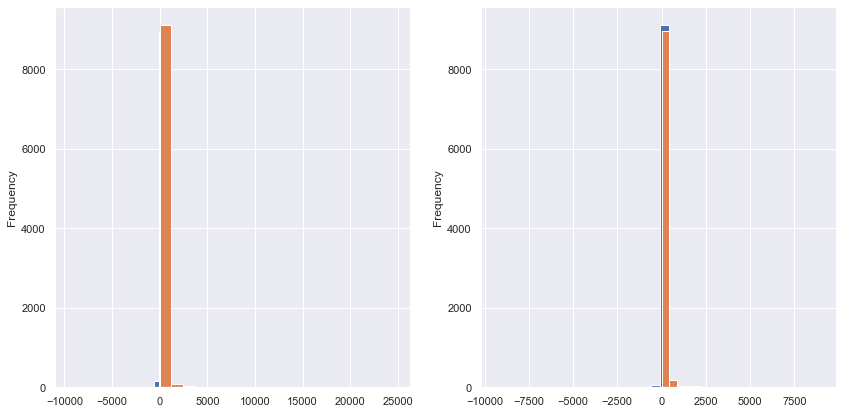

In [471]:
# Scaling 
dat_unscaled = dat.copy()

if scaling_aposteriori:
    if scaler is not None:
        if isinstance(scaler, dict):        
            for _imp_key, _scaler in scaler.items():
                if _scaler is not None:
                    dat[col_dict[_imp_key]] = _scaler.fit_transform(dat[col_dict[_imp_key]]) 
        else:   
            _cols = col_dict['ecg']+col_dict['celldyn']
            dat[_cols] = pd.DataFrame(data=scaler.fit_transform(dat[_cols]), index=HS.index, columns=_cols)
    dat.apply(lambda x: sum(np.isinf(x))).sum(), dat.isna().sum().sum()
    
fig, ax = plt.subplots(ncols=2, figsize=(14,7))
dat_unscaled.min().plot.hist(bins=20, ax=ax[0])
dat_unscaled.max().plot.hist(bins=20, ax=ax[0])
                      
dat.min().plot.hist(bins=20, ax=ax[1])
dat.max().plot.hist(bins=20, ax=ax[1])

## Outliers

We have already treated the univariate outliers, which revolves around the normality of the feature values 
from the perspective of the specific feature alone. Univariate outlier treatment was important to regularize 
any data transformation and feature augmentation. We will now treat the multivariate case where samples 
can have an outlying combination of feature values. Python libraries to treat outliers are:
* [sklearn](https://scikit-learn.org/stable/modules/outlier_detection.html)
* [pyod](https://pyod.readthedocs.io/en/latest/install.html)

We have three ways of applying multivariate outlier detection:
1. a priori removal or replacement of all outlying samples
2. detection and tagging of outlying test samples prior to prediction for a posteriori segmentation 
3. treat the outlier/inlier label as a feature
Of course, all can be applied together. Typical methods are:
* LOF
* isoForest
* density-based clustering 
* AutoEncoder, or any encoder-decoder method, could also be a more conventional matrix factorisation method.

Interesting would be to invert the idea of Affinity Propagation (as is done by Janssens' Stochastic Outlier Selection).

When we apply an outlier detector on **unseen** data we refer to it as **novelty detection**, the latter also assumes that **no** outliers 
are present in the training data.

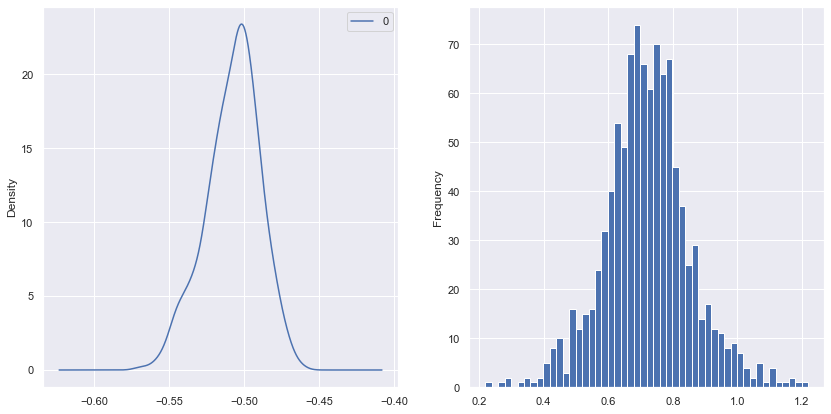

In [473]:
# Mahalanobis distance for outliers
def mahalanobis(x=None, cov=None):
    # source: https://www.machinelearningplus.com/statistics/mahalanobis-distance/
    """Compute the Mahalanobis Distance between each row of x and the data  
    x    : vector or matrix of data with, say, p columns.
    data : ndarray of the distribution from which Mahalanobis distance of each observation of x is to be computed.
    cov  : covariance matrix (p x p) of the distribution. If None, will be computed from data.
    """
    x_minus_mu = x - np.mean(x)
    if not cov:
        cov = np.cov(x.values.T)
    inv_covmat = sc.linalg.inv(cov)
    left_term = np.dot(x_minus_mu, inv_covmat)
    mahal = np.dot(left_term, x_minus_mu.T)
    return mahal.diagonal()

if remove_outlying_samples_from_train:
    var_cols = col_dict['ecg']+col_dict['celldyn']+col_dict['inter_celldyn']+col_dict['inter_ecg']

    out_idx_dict= {}

    iso = IsolationForest(n_estimators=600, n_jobs=4)
    out_in = iso.fit_predict(dat[var_cols])
    out_idx_dict['iso'] = np.where(out_in==-1)
    in_idx = np.where(out_in==1)
    
    fig, ax = plt.subplots(ncols=2, figsize=(14,7))
    pd.DataFrame(iso.score_samples(dat[var_cols])).plot.kde(ax=ax[0])

    ocs = OneClassSVM(kernel='rbf', gamma='scale', max_iter=1000)
    out_in = ocs.fit_predict(dat[var_cols])
    out_idx_dict['svm'] = np.where(out_in==-1)

    try:
        mah = mahalanobis(dat[var_cols])
        dat['_maha'] = mah/(np.max(mah)-np.min(mah))
        # isolation forest
        dat._maha.plot.hist(bins=50, ax=ax[1])
    except:
        print("matrix is singular..you did not remove the collinearity did you ;)")

## Reduced dimensionality visualisation

In [474]:
history_features = ['RF_FamHist', 'RF_Smok', 'RF_HyperTens','RF_obese30', 'RF_HyperChol','RF_Diab', 'RF_CVDHist']
col_dict['tn_admission'] = ['tn_admission']
feature_set = defaultdict(dict)
feature_set['0']['_withoutCelldyn'] = ['pheno'] 
feature_set['0']['_withCelldyn'] = ['pheno', 'celldyn']
feature_set['1']['_withoutCelldyn'] =  ['pheno', 'ecg']
feature_set['1']['_withCelldyn'] =  ['pheno', 'ecg', 'celldyn']
feature_set['2']['_withoutCelldyn'] =  ['pheno', 'ecg', 'tn_admission']
feature_set['2']['_withCelldyn'] =  ['pheno', 'ecg', 'tn_admission', 'celldyn']
feature_set['3']['_withoutCelldyn'] =  ['pheno', 'ecg', 'history', 'tn_admission']
feature_set['3']['_withCelldyn'] = ['pheno', 'ecg', 'history', 'tn_admission', 'celldyn']
feature_set['4']['_withoutCelldyn'] =  ['pheno', 'ecg', 'history', 'tn_admission', 'inter_ecg'] 
feature_set['4']['_withCelldyn'] = ['pheno', 'ecg', 'history', 'tn_admission', 'celldyn', 'inter_ecg', 'inter_celldyn']
feature_set['5']['_withoutCelldyn'] =  ['pheno', 'ecg', 'history', 'tn_admission', 'hs', 'inter_ecg']
feature_set['5']['_withCelldyn'] = ['pheno', 'ecg', 'history', 'tn_admission', 'hs', 'celldyn', 'inter_ecg', 'inter_celldyn']
feature_set['6']['_withoutCelldyn'] =  ['pheno', 'ecg', 'history', 'tn_admission', 'hs', 'slope', 'inter_ecg']
feature_set['6']['_withCelldyn'] = ['pheno', 'ecg', 'history', 'tn_admission', 'hs', 'slope', 'celldyn', 'inter_ecg', 'inter_celldyn'] 

### PCA

In [475]:
print("ECG: {} cols, \t CELLDYN: {} cols, \t OTHER:{} cols".format(len(col_dict['ecg']), len(col_dict['celldyn']), len(col_dict['other'])))

ECG: 325 cols, 	 CELLDYN: 513 cols, 	 OTHER:18 cols


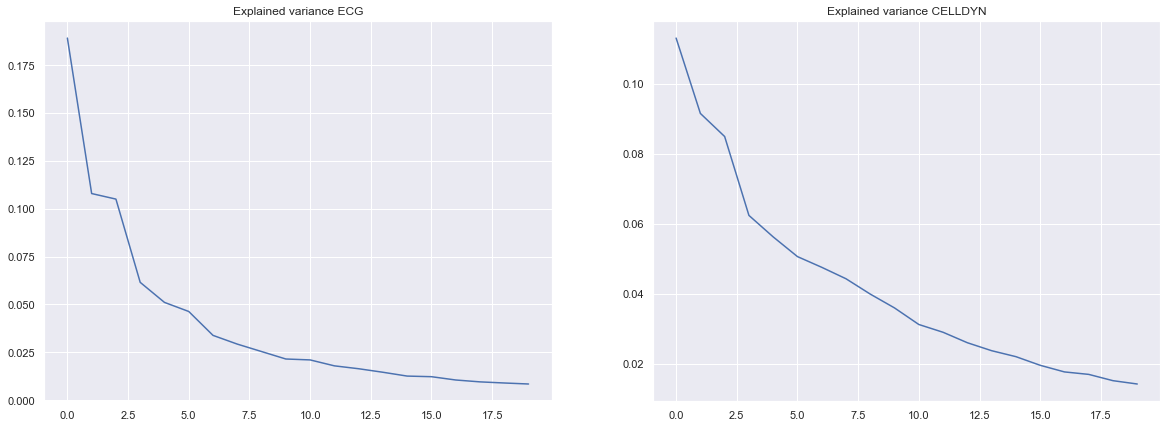

In [476]:
dat_viz={}
nc = 20
red_cols = ['pc_'+str(i) for i in range(0, nc)]
pc = {}
fig, ax = plt.subplots(ncols=2, figsize=(20,7))

pc['ecg'] = PCA(n_components=nc, svd_solver='full')
tred = pc['ecg'].fit_transform(dat[col_dict['ecg']])
ax[0].plot(pc['ecg'].explained_variance_ratio_)
ax[0].set_title('Explained variance ECG')
dat_viz['pca_celldyn']  = pd.DataFrame(data=tred, index=dat.index, columns=red_cols)

pc['celldyn'] = PCA(n_components=nc, svd_solver='full')
tred = pc['celldyn'].fit_transform(dat[col_dict['celldyn']])
ax[1].plot(pc['celldyn'].explained_variance_ratio_)
ax[1].set_title('Explained variance CELLDYN')
dat_viz['pca_ecg']  = pd.DataFrame(data=tred, index=dat.index, columns=red_cols)



The explained variance of the first component is huge, this suggests that there is a leaking feature.

Text(0.5, 1.0, 'celldyn PC 2')

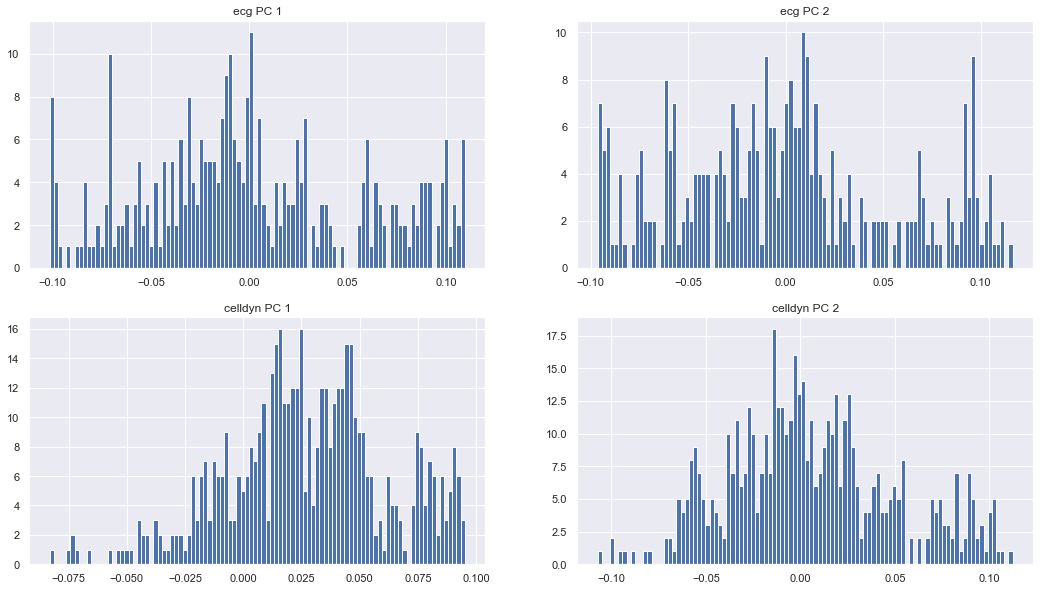

In [477]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(18,10))
ax[0,0].hist(pc['ecg'].components_[0], bins=100); ax[0,0].set_title('ecg PC 1')
ax[0,1].hist(pc['ecg'].components_[1], bins=100); ax[0,1].set_title('ecg PC 2')
ax[1,0].hist(pc['celldyn'].components_[0], bins=100); ax[1,0].set_title('celldyn PC 1')
ax[1,1].hist(pc['celldyn'].components_[1], bins=100); ax[1,1].set_title('celldyn PC 2')

Text(0.5, 1.0, 'PCA CELLDYN')

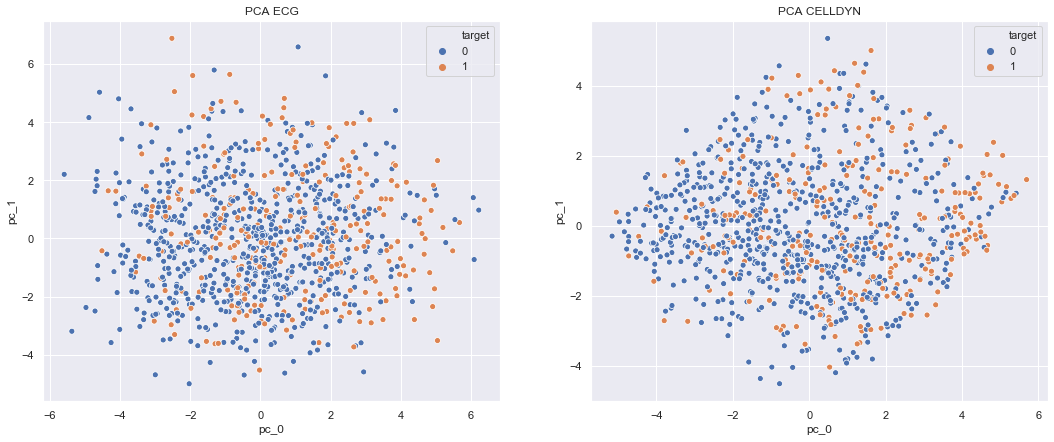

In [478]:
fig, ax = plt.subplots(ncols=2, figsize=(18,7))
sns.scatterplot(data=dat_viz['pca_ecg'], x='pc_0', y='pc_1', hue=y, ax=ax[0])
sns.scatterplot(data=dat_viz['pca_celldyn'], x='pc_0', y='pc_1', hue=y, ax=ax[1])
ax[0].set_title('PCA ECG')
ax[1].set_title('PCA CELLDYN')

## NMF

In [480]:
nc = 20
red_cols = ['pc_'+str(i) for i in range(0, nc)]

nnmf = {}
nnmf['ecg'] = NMF(n_components=nc)
tred = nnmf['ecg'].fit_transform(dat[col_dict['ecg']]+dat[col_dict['ecg']].min().abs())
dat_viz['nmnf_ecg']  = pd.DataFrame(data=tred, index=dat.index, columns=red_cols)

nnmf['celldyn'] = NMF(n_components=nc)
tred = nnmf['celldyn'].fit_transform(dat[col_dict['celldyn']]+dat[col_dict['celldyn']].min().abs())
dat_viz['nmnf_celldyn']  = pd.DataFrame(data=tred, index=dat.index, columns=red_cols)

print("Reconstruction errors: ECG {}, \t CELLDYN {}".format(nnmf['ecg'].reconstruction_err_, 
                                                                         nnmf['celldyn'].reconstruction_err_))

Reconstruction errors: ECG 86.44462082109335, 	 CELLDYN 110.51406880805455


Text(0.5, 1.0, 'NMF CELLDYN')

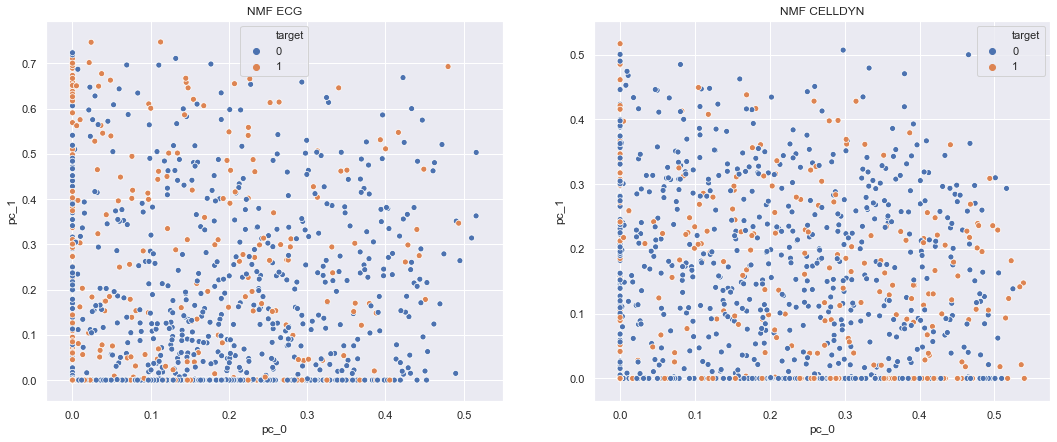

In [481]:
fig, ax = plt.subplots(ncols=2, figsize=(18,7))
sns.scatterplot(data=dat_viz['nmnf_ecg'], x='pc_0', y='pc_1', hue=y, ax=ax[0])
sns.scatterplot(data=dat_viz['nmnf_celldyn'], x='pc_0', y='pc_1', hue=y, ax=ax[1])
ax[0].set_title('NMF ECG')
ax[1].set_title('NMF CELLDYN')


### UMAP

By simple inspection of the embedded data we expect that the meta features and the HS features are well able to seperate the NSTEMI's from the control group.

This suggests that CELLDYN and ECG data (without the aggregation labels provided by the manufacturer, see Mark) alone are not enough to separate the NSTEMI's from the control group.

Starting with CELLDYN we add, (age, gender, BMI), (history features) and the initial troponine level.



Interestingly, including HS to the features hardly increases the visual separability of the targets.

In [484]:
um_red = UMAP(n_components=2)
tsne_red = TSNE(n_components=2)

set0 = col_dict['pheno']+col_dict['celldyn']
set1 = col_dict['pheno']+col_dict['celldyn']+col_dict['ecg']
set2 = col_dict['pheno']+col_dict['celldyn']+col_dict['ecg']+col_dict['history']
set3 = col_dict['pheno']+col_dict['celldyn']+col_dict['ecg']+col_dict['history']+col_dict['troponine']
set4 = col_dict['pheno']+col_dict['celldyn']+col_dict['ecg']+col_dict['history']+col_dict['troponine']+inter_ecg_cols+inter_celldyn_cols
set5 = col_dict['pheno']+col_dict['celldyn']+col_dict['ecg']+col_dict['history']+col_dict['troponine']+col_dict['hs']+inter_ecg_cols+inter_celldyn_cols
set6 = col_dict['pheno']+col_dict['celldyn']+col_dict['ecg']+col_dict['history']+col_dict['troponine']+col_dict['hs']+col_dict['slope']+inter_ecg_cols+inter_celldyn_cols

dat_viz['umap_fs0'] = pd.DataFrame(data=um_red.fit_transform(dat[set0]), index=dat.index, columns=['pc_1', 'pc_2'])
dat_viz['umap_fs1'] = pd.DataFrame(data=um_red.fit_transform(dat[set1]), index=dat.index, columns=['pc_1', 'pc_2'])
dat_viz['umap_fs2'] =  pd.DataFrame(data=um_red.fit_transform(dat[set2]), index=dat.index, columns=['pc_1', 'pc_2'])
dat_viz['umap_fs3'] = pd.DataFrame(data=um_red.fit_transform(dat[set3]), index=dat.index, columns=['pc_1', 'pc_2'])
dat_viz['umap_fs4'] = pd.DataFrame(data=um_red.fit_transform(dat[set4]), index=dat.index, columns=['pc_1', 'pc_2'])
dat_viz['umap_fs5'] = pd.DataFrame(data=um_red.fit_transform(dat[set5]), index=dat.index, columns=['pc_1', 'pc_2'])
dat_viz['umap_fs6'] = pd.DataFrame(data=um_red.fit_transform(dat[set6]), index=dat.index, columns=['pc_1', 'pc_2'])

dat_viz['tsne_fs0'] = pd.DataFrame(data=tsne_red.fit_transform(dat[set0]), index=dat.index, columns=['pc_1', 'pc_2'])
dat_viz['tsne_fs1'] = pd.DataFrame(data=tsne_red.fit_transform(dat[set1]), index=dat.index, columns=['pc_1', 'pc_2'])
dat_viz['tsne_fs2'] =  pd.DataFrame(data=tsne_red.fit_transform(dat[set2]), index=dat.index, columns=['pc_1', 'pc_2'])
dat_viz['tsne_fs3'] = pd.DataFrame(data=tsne_red.fit_transform(dat[set3]), index=dat.index, columns=['pc_1', 'pc_2'])
dat_viz['tsne_fs4'] = pd.DataFrame(data=tsne_red.fit_transform(dat[set4]), index=dat.index, columns=['pc_1', 'pc_2'])
dat_viz['tsne_fs5'] = pd.DataFrame(data=tsne_red.fit_transform(dat[set5]), index=dat.index, columns=['pc_1', 'pc_2'])
dat_viz['tsne_fs6'] = pd.DataFrame(data=tsne_red.fit_transform(dat[set6]), index=dat.index, columns=['pc_1', 'pc_2'])



Text(0.5, 1.0, 'TSNE featureset 6')

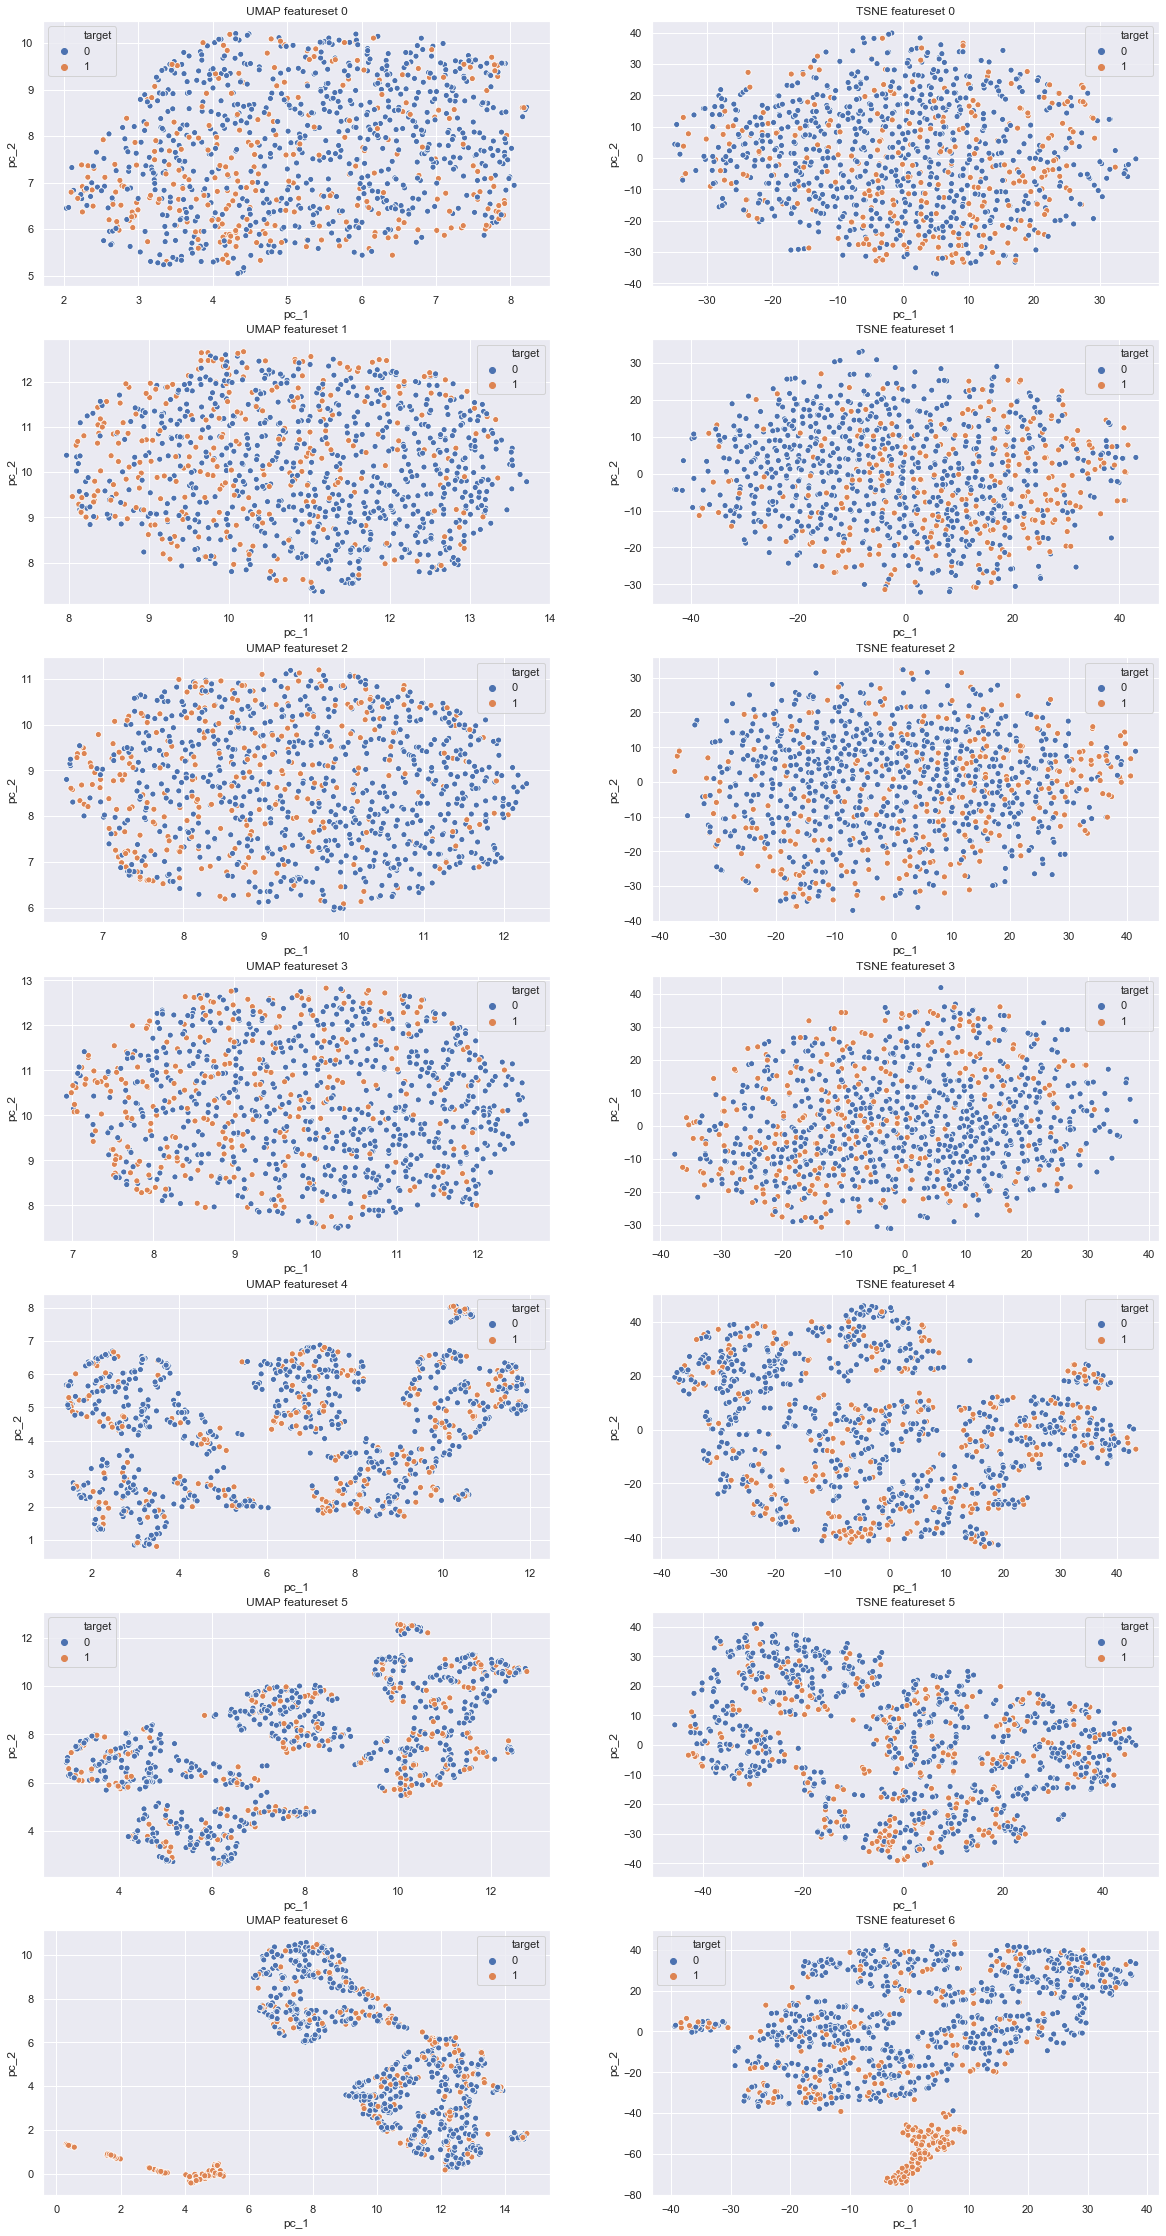

In [485]:
fig, ax = plt.subplots(ncols=2, nrows=7, figsize=(20,40))
sns.scatterplot(data=dat_viz['umap_fs0'], x='pc_1', y='pc_2', hue=y, ax=ax[0,0])
sns.scatterplot(data=dat_viz['umap_fs1'], x='pc_1', y='pc_2', hue=y, ax=ax[1,0])
sns.scatterplot(data=dat_viz['umap_fs2'], x='pc_1', y='pc_2', hue=y, ax=ax[2,0])
sns.scatterplot(data=dat_viz['umap_fs3'], x='pc_1', y='pc_2', hue=y, ax=ax[3,0])
sns.scatterplot(data=dat_viz['umap_fs4'], x='pc_1', y='pc_2', hue=y, ax=ax[4,0])
sns.scatterplot(data=dat_viz['umap_fs5'], x='pc_1', y='pc_2', hue=y, ax=ax[5,0])
sns.scatterplot(data=dat_viz['umap_fs6'], x='pc_1', y='pc_2', hue=y, ax=ax[6,0])

ax[0,0].set_title('UMAP featureset 0')
ax[1,0].set_title('UMAP featureset 1')
ax[2,0].set_title('UMAP featureset 2')
ax[3,0].set_title('UMAP featureset 3')
ax[4,0].set_title('UMAP featureset 4')
ax[5,0].set_title('UMAP featureset 5')
ax[6,0].set_title('UMAP featureset 6')

sns.scatterplot(data=dat_viz['tsne_fs0'], x='pc_1', y='pc_2', hue=y, ax=ax[0,1])
sns.scatterplot(data=dat_viz['tsne_fs1'], x='pc_1', y='pc_2', hue=y, ax=ax[1,1])
sns.scatterplot(data=dat_viz['tsne_fs2'], x='pc_1', y='pc_2', hue=y, ax=ax[2,1])
sns.scatterplot(data=dat_viz['tsne_fs3'], x='pc_1', y='pc_2', hue=y, ax=ax[3,1])
sns.scatterplot(data=dat_viz['tsne_fs4'], x='pc_1', y='pc_2', hue=y, ax=ax[4,1])
sns.scatterplot(data=dat_viz['tsne_fs5'], x='pc_1', y='pc_2', hue=y, ax=ax[5,1])
sns.scatterplot(data=dat_viz['tsne_fs6'], x='pc_1', y='pc_2', hue=y, ax=ax[6,1])
ax[0,1].set_title('TSNE featureset 0')
ax[1,1].set_title('TSNE featureset 1')
ax[2,1].set_title('TSNE featureset 2')
ax[3,1].set_title('TSNE featureset 3')
ax[4,1].set_title('TSNE featureset 4')
ax[5,1].set_title('TSNE featureset 5')
ax[6,1].set_title('TSNE featureset 6')

# Supervised clustering

## UMAP

In [486]:
all_cols = get_var_cols(col_dict)

if run_supervised_umap:
    um_all_sup = UMAP(n_components=3, n_neighbors=10, min_dist=0.1)
    dat_viz['umap_all_sup'] = pd.DataFrame(data=um_all_sup.fit_transform(dat[all_cols], 
                                                                 y=y), 
                                       index=dat.index, columns=['pcu_1', 'pcu_2', 'pcu_3'])

    um_ecg_sup = UMAP(n_components=3, n_neighbors=10, min_dist=0.1)
    dat_viz['umap_ecg_sup'] = pd.DataFrame(data=um_ecg_sup.fit_transform(dat[col_dict['ecg']], 
                                                                 y=y), 
                                       index=dat.index, columns=['pcu_1', 'pcu_2', 'pcu_3'])

    um_celldyn_sup = UMAP(n_components=3, n_neighbors=10, min_dist=0.1)
    dat_viz['umap_celldyn_sup'] = pd.DataFrame(data=um_celldyn_sup.fit_transform(dat[col_dict['celldyn']], 
                                                                 y=y), 
                                       index=dat.index, columns=['pcu_1', 'pcu_2', 'pcu_3'])
    
    fig, ax = plt.subplots(ncols=3, nrows=3, figsize=(26,18))
    sns.scatterplot(data=dat_viz['umap_all_sup'], x='pcu_1', y='pcu_2', hue=y, ax=ax[0,0])
    sns.scatterplot(data=dat_viz['umap_all_sup'], x='pcu_1', y='pcu_3', hue=y, ax=ax[0,1])
    sns.scatterplot(data=dat_viz['umap_all_sup'], x='pcu_2', y='pcu_3', hue=y, ax=ax[0,2])

    sns.scatterplot(data=dat_viz['umap_ecg_sup'], x='pcu_1', y='pcu_2', hue=y, ax=ax[1,0])
    sns.scatterplot(data=dat_viz['umap_ecg_sup'], x='pcu_1', y='pcu_3', hue=y, ax=ax[1,1])
    sns.scatterplot(data=dat_viz['umap_ecg_sup'], x='pcu_2', y='pcu_3', hue=y, ax=ax[1,2])

    sns.scatterplot(data=dat_viz['umap_celldyn_sup'], x='pcu_1', y='pcu_2', hue=y, ax=ax[2,0])
    sns.scatterplot(data=dat_viz['umap_celldyn_sup'], x='pcu_1', y='pcu_3', hue=y, ax=ax[2,1])
    sns.scatterplot(data=dat_viz['umap_celldyn_sup'], x='pcu_2', y='pcu_3', hue=y, ax=ax[2,2])

    ax[0,0].set_title('All features')
    ax[0,1].set_title('All features')
    ax[0,2].set_title('All features')

    ax[1,0].set_title('ECG features')
    ax[1,1].set_title('ECG features')
    ax[1,2].set_title('ECG features')

    ax[2,0].set_title('Celldyn features')
    ax[2,1].set_title('Celldyn features')
    ax[2,2].set_title('Celldyn features')

Supervised UMAP clustering seems to be well able to separate the targets. 

# Linear separability using LDA

## ECG

H:\PythonVENV\Envs\base\lib\site-packages\sklearn\discriminant_analysis.py:463: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(325, 2 - 1) = 1 components.
  ChangedBehaviorWarning)
H:\PythonVENV\Envs\base\lib\site-packages\sklearn\discriminant_analysis.py:469: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)


Linear ECG. 	 negative accuracy:0.9294532627865961, positive accuracy:0.5612009237875288


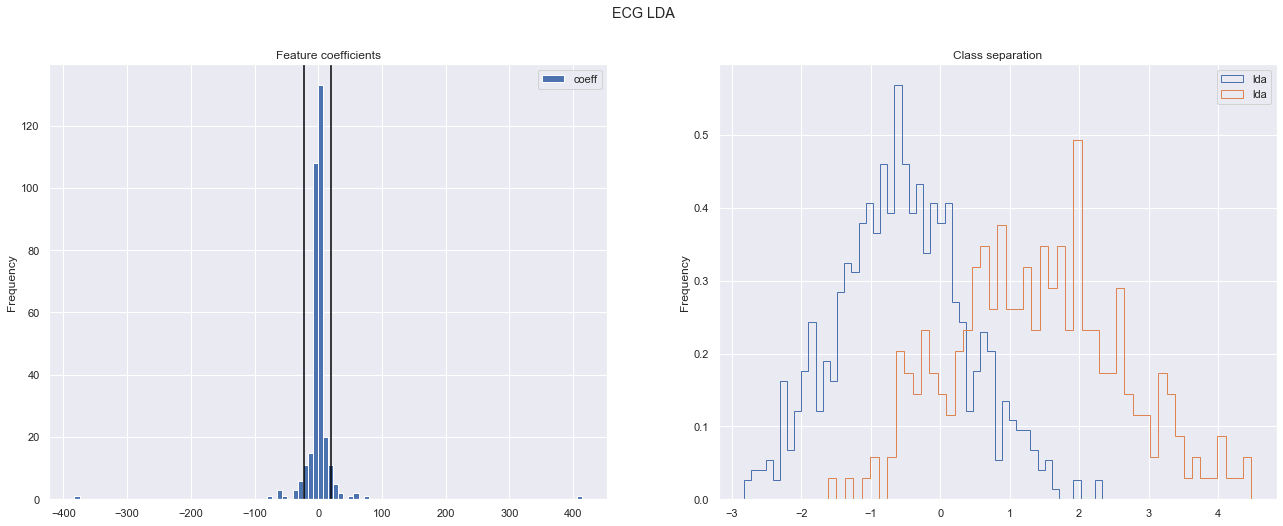

In [487]:
LDA_ecg = LDA(n_components=2)
lin_sep = pd.DataFrame(data=LDA_ecg.fit_transform(dat[col_dict['ecg']], y=y), index=dat.index, columns=['lda'])
coeff = pd.DataFrame(data=LDA_ecg.coef_[0], columns=['coeff'], index=col_dict['ecg'])

q95 = coeff.quantile(0.95)[0]
q05 = coeff.quantile(0.05)[0]

fig, ax = plt.subplots(ncols=2, figsize=(22,8))
coeff.plot.hist(bins=100, ax=ax[0])
ax[0].axvline(q95, color='black')
ax[0].axvline(q05, color='black')
lin_sep.loc[y==0].plot.hist(bins=50, histtype='step', density=True, ax=ax[1], label='0')
lin_sep.loc[y==1].plot.hist(bins=50, histtype='step', density=True, ax=ax[1], label='1')
ax[1].legend()
ax[0].set_title('Feature coefficients')
ax[1].set_title('Class separation')
plt.suptitle('ECG LDA')

# strong linear separators
strong_separators_lda = dict()
strong_separators_lda['ecg'] = pd.concat([coeff.loc[coeff.coeff>q95], coeff.loc[coeff.coeff<q05]])

t = pd.DataFrame(lin_sep.lda)
t['target'] = y
thres=0

neg, pos = 1-t.loc[t.lda<thres].target.mean(), t.loc[t.lda>thres].target.mean()
print('Linear ECG. \t negative accuracy:{}, positive accuracy:{}'.format(neg, pos))

## Celldyn

H:\PythonVENV\Envs\base\lib\site-packages\sklearn\discriminant_analysis.py:463: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(816, 2 - 1) = 1 components.
  ChangedBehaviorWarning)
H:\PythonVENV\Envs\base\lib\site-packages\sklearn\discriminant_analysis.py:469: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)


Linear CELLDYN. 	 negative accuracy:0.9985096870342772, positive accuracy:0.8571428571428571


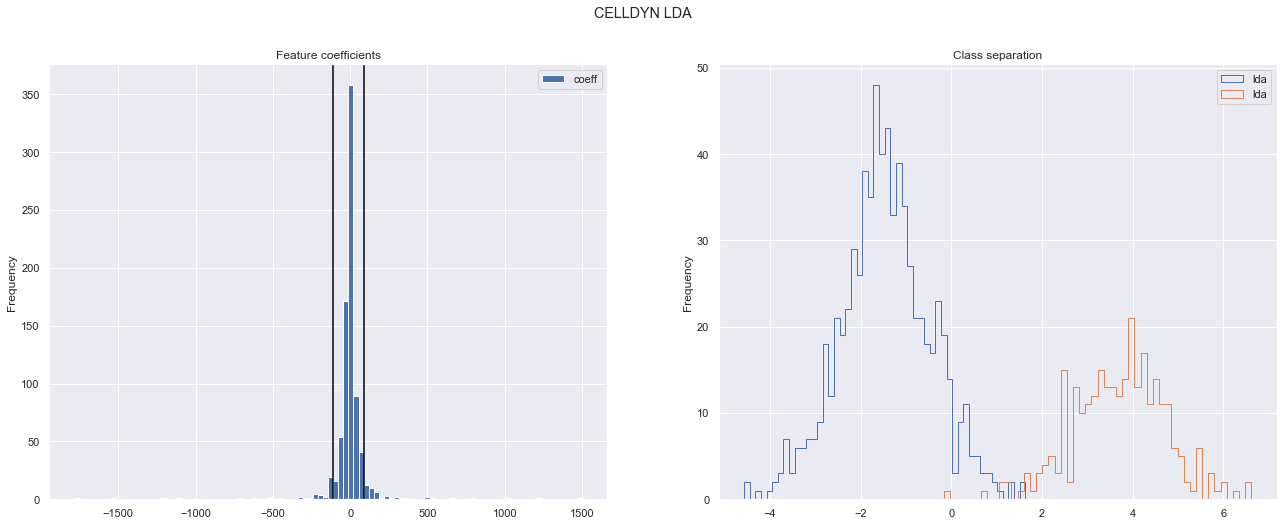

In [488]:
LDA_celldyn = LDA(n_components=2)
cols = col_dict['celldyn']+inter_ecg_cols+inter_celldyn_cols
_dat = dat
lin_sep = pd.DataFrame(data=LDA_celldyn.fit_transform(_dat[cols], y=y), index=_dat.index, columns=['lda'])
coeff = pd.DataFrame(data=LDA_celldyn.coef_[0], columns=['coeff'], index=cols)

q95 = coeff.quantile(0.95)[0]
q05 = coeff.quantile(0.05)[0]

fig, ax = plt.subplots(ncols=2, figsize=(22,8))
coeff.plot.hist(bins=100, ax=ax[0])
ax[0].axvline(q95, color='black')
ax[0].axvline(q05, color='black')
lin_sep.loc[y==0].plot.hist(bins=50, histtype='step', density=False, label='0', ax=ax[1])
lin_sep.loc[y==1].plot.hist(bins=50, histtype='step', density=False, label='1', ax=ax[1])
ax[1].legend()
ax[0].set_title('Feature coefficients')
ax[1].set_title('Class separation')
plt.suptitle('CELLDYN LDA')

# strong linear separators
strong_separators_lda['celldyn'] = pd.concat([coeff.loc[coeff.coeff>q95], coeff.loc[coeff.coeff<q05]])

t = pd.DataFrame(lin_sep.lda)
t['target'] = y
thres=0.
neg, pos = 1-t.loc[t.lda<thres].target.mean(), t.loc[t.lda>thres].target.mean()
print('Linear CELLDYN. \t negative accuracy:{}, positive accuracy:{}'.format( neg , pos ))

There is a very clear separation between the two classes for the celldyn data which suggests that this data can be used to predict NSTEMI accurately. 

To verify this statement we have to split the data in a training set and a test set.

H:\PythonVENV\Envs\base\lib\site-packages\sklearn\discriminant_analysis.py:463: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(680, 2 - 1) = 1 components.
  ChangedBehaviorWarning)
H:\PythonVENV\Envs\base\lib\site-packages\sklearn\discriminant_analysis.py:469: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)


F1:0.3939393939393939, NPV:0.7580645161290323, ACC:0.558531746031746, REC:(0.4642857142857143, 0.4642857142857143), AUC:0.5431547619047619


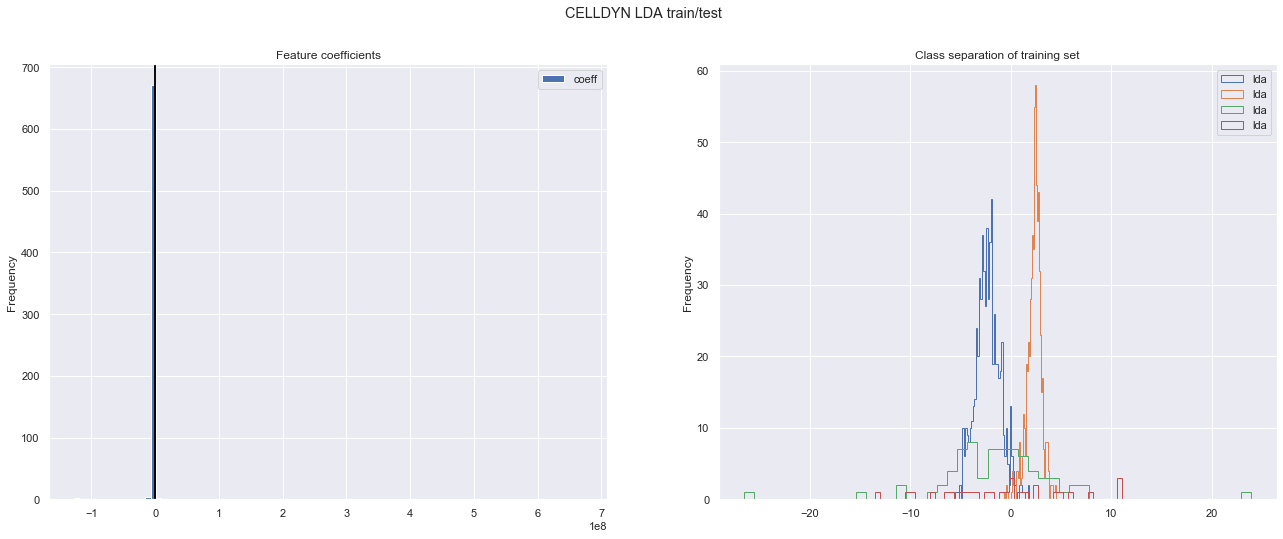

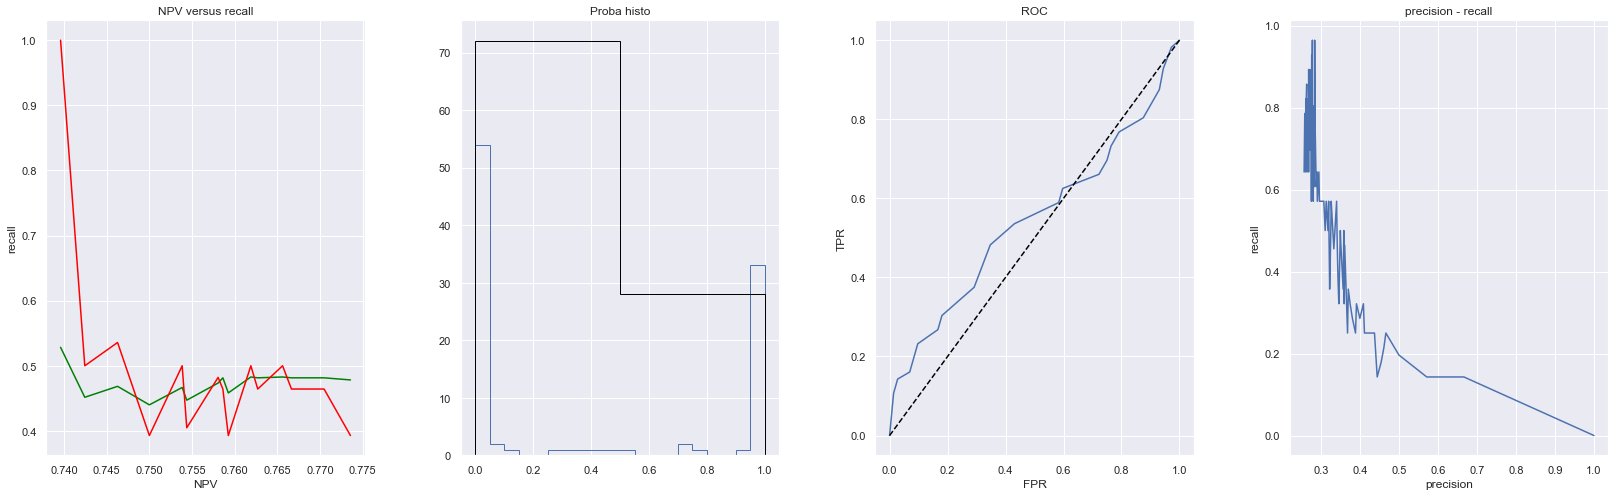

In [489]:
cols =  col_dict['celldyn']+inter_celldyn_cols #get_var_cols(col_dict)
LDA_celldyn = LDA(n_components=2, priors=[0.5, 0.5])
_dat = dat_unscaled
X_train, X_test, y_train, y_test = train_test_split(_dat[cols], y, test_size=0.1, random_state=322, stratify=y)

X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

sm = SMOTE(sampling_strategy='minority', random_state=321, k_neighbors=50)
X_train, y_train = sm.fit_sample(X_train, y_train)
LDA_celldyn.fit(X_train, y=y_train)

lin_sep_train = pd.DataFrame(data=LDA_celldyn.transform(X_train), columns=['lda'])
lin_sep_test = pd.DataFrame(data=LDA_celldyn.transform(X_test), columns=['lda'])

coeff = pd.DataFrame(data=LDA_celldyn.coef_[0], columns=['coeff'], index=cols)

q95 = coeff.quantile(0.95)[0]
q05 = coeff.quantile(0.05)[0]

fig, ax = plt.subplots(ncols=2, figsize=(22,8))
coeff.plot.hist(bins=100, ax=ax[0])
ax[0].axvline(q95, color='black')
ax[0].axvline(q05, color='black')
lin_sep_train.loc[y_train==0].plot.hist(bins=50, histtype='step', density=False, label='0', ax=ax[1])
lin_sep_train.loc[y_train==1].plot.hist(bins=50, histtype='step', density=False, label='1', ax=ax[1])
lin_sep_test.loc[y_test==0].plot.hist(bins=50, histtype='step', density=False, label='0', ax=ax[1])
lin_sep_test.loc[y_test==1].plot.hist(bins=50, histtype='step', density=False, label='1', ax=ax[1])
#ax[1].set_xlim(-20,20)
ax[1].legend()
ax[0].set_title('Feature coefficients')
ax[1].set_title('Class separation of training set')
plt.suptitle('CELLDYN LDA train/test')

y_pred = LDA_celldyn.predict_proba(X_test)[:,1]

_metrics = get_accuracy_plots(y_test, y_pred.copy());
print("F1:{}, NPV:{}, ACC:{}, REC:{}, AUC:{}".format(fb_score(y_test, y_pred), 
                                             npv(y_test, y_pred), 
                                             balanced_accuracy(y_test, y_pred), 
                                             recall(y_test, y_pred),
                                             metrics.roc_auc_score(y_test, y_pred)))

The LDA separator generalises very poorly. According to literature (Friedman1989, Howland2003, Chen2000, etc.) the dimensionality of the LDA-processed data should be lower than the sample count to prevent singular scatter-matrices. To enforce this we can apply PCA to limit the number of dimensions to 90\% of the row-count.

Other aspects are:
* sensitivity of data to outliers (should be taken care of with quantile transformations)
* co-variance shift
* non-linearity 

## Patient clustering

Using weighted correlation between the patient, where the weights are obtained from prior determined feature importances, say from LDA or PCA.

We can apply a pair-wise distance metric:
* KL-divergence
* cosine, euclidean etc.

Where it makes sense to include factor weights based on the separability.

Clustering options 
* Spectral clustering
* Hierchical clustering
* Louvain method (Fast community unfolding)
* Label propagation
* Walktrap community
* Edge betweenness community
* Leading eigenvector community
* Affinity propagation

In [490]:
var_cols = col_dict['pheno']+col_dict['celldyn']+col_dict['ecg']+col_dict['history']+col_dict['hs']+['tn_admission'] + inter_celldyn_cols + inter_ecg_cols
_dat = dat

H:\PythonVENV\Envs\base\lib\site-packages\sklearn\manifold\_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


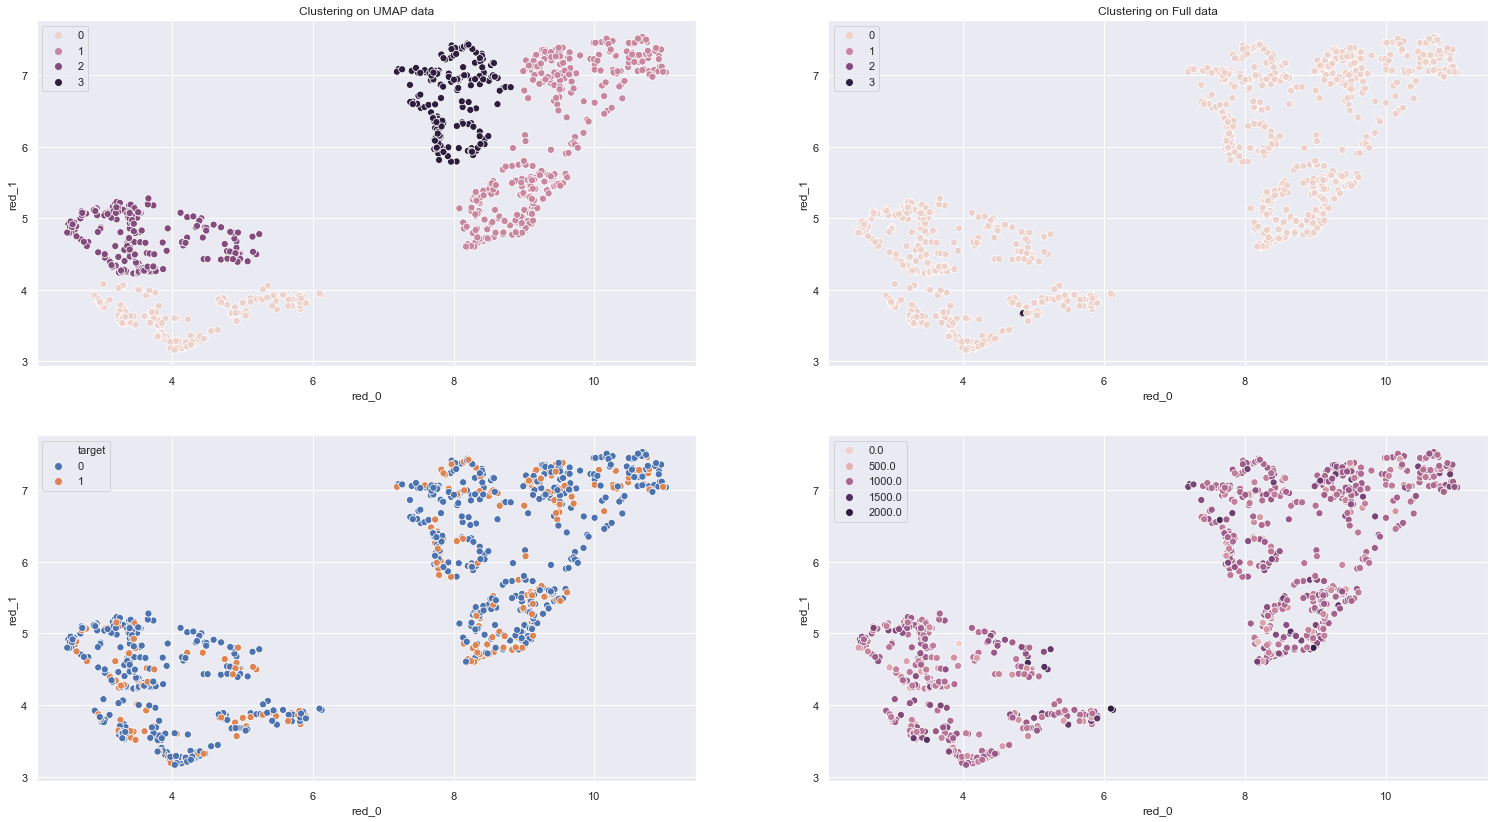

In [491]:
# Spectral clustering
if patient_clustering:
    n_comps = 8
    nclust= 4
    um_all = UMAP(n_components=n_comps, n_neighbors=15, min_dist=0.02)
    red_data = pd.DataFrame(data=um_all.fit_transform(_dat[var_cols]), columns=['red_'+str(k) for k in range(0, n_comps)], index=dat.index)

    cluster_spectral = SpectralClustering(n_clusters=nclust, eigen_solver=None, n_components=nclust)
    cluster_spectral.fit(red_data)
    labs = cluster_spectral.labels_

    cluster_spectral = SpectralClustering(n_clusters=nclust, eigen_solver=None, n_components=nclust)
    cluster_spectral.fit(_dat[var_cols])
    labs_full = cluster_spectral.labels_

    red_data['spectral_cluster_from_umap'] = labs
    red_data['spectral_cluster_from_full'] = labs_full

    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(26,14))
    sns.scatterplot(data=red_data, x='red_0', y='red_1', hue=labs, s=50, ax=ax[0,0])
    sns.scatterplot(data=red_data, x='red_0', y='red_1', hue=labs_full, s=50, ax=ax[0,1])

    sns.scatterplot(data=red_data, x='red_0', y='red_1', hue=y, s=50, ax=ax[1,0])
    try:
        sns.scatterplot(data=red_data, x='red_0', y='red_1', hue=mah, s=50, ax=ax[1,1])
    except Exception as e:
        print("Mahalanobis values are not available")

    ax[0, 0].set_title('Clustering on UMAP data')
    ax[0, 1].set_title('Clustering on Full data')

    red_data = red_data.join(y)

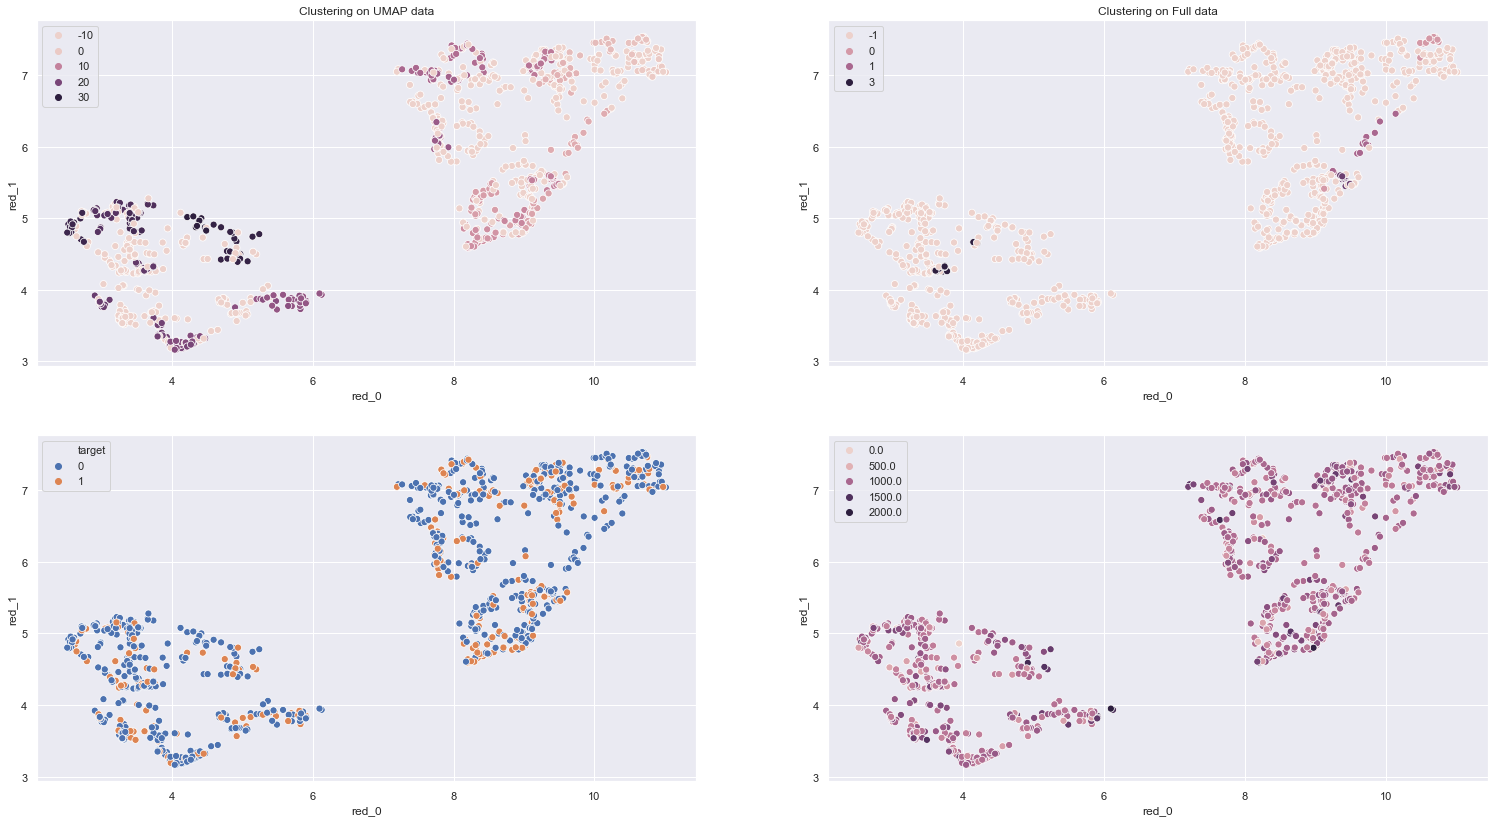

In [492]:
# OPTICS clustering
if patient_clustering:
    cluster_optics = OPTICS(min_samples=10, metric='minkowski', p=1)
    cluster_optics.fit(red_data)
    labs = cluster_optics.labels_

    cluster_optics.fit(_dat[var_cols])
    labs_full = cluster_optics.labels_

    red_data['optics_cluster_from_umap'] = labs
    red_data['optics_cluster_from_full'] = labs_full

    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(26,14))
    sns.scatterplot(data=red_data, x='red_0', y='red_1', hue=labs, s=50, ax=ax[0,0])
    sns.scatterplot(data=red_data, x='red_0', y='red_1', hue=labs_full, s=50, ax=ax[0,1])
    sns.scatterplot(data=red_data, x='red_0', y='red_1', hue=y, s=50, ax=ax[1,0])
    try:
        sns.scatterplot(data=red_data, x='red_0', y='red_1', hue=mah, s=50, ax=ax[1,1])
    except Exception as e:
        print("Mahalanobis values are not available")

    ax[0, 0].set_title('Clustering on UMAP data')
    ax[0, 1].set_title('Clustering on Full data')


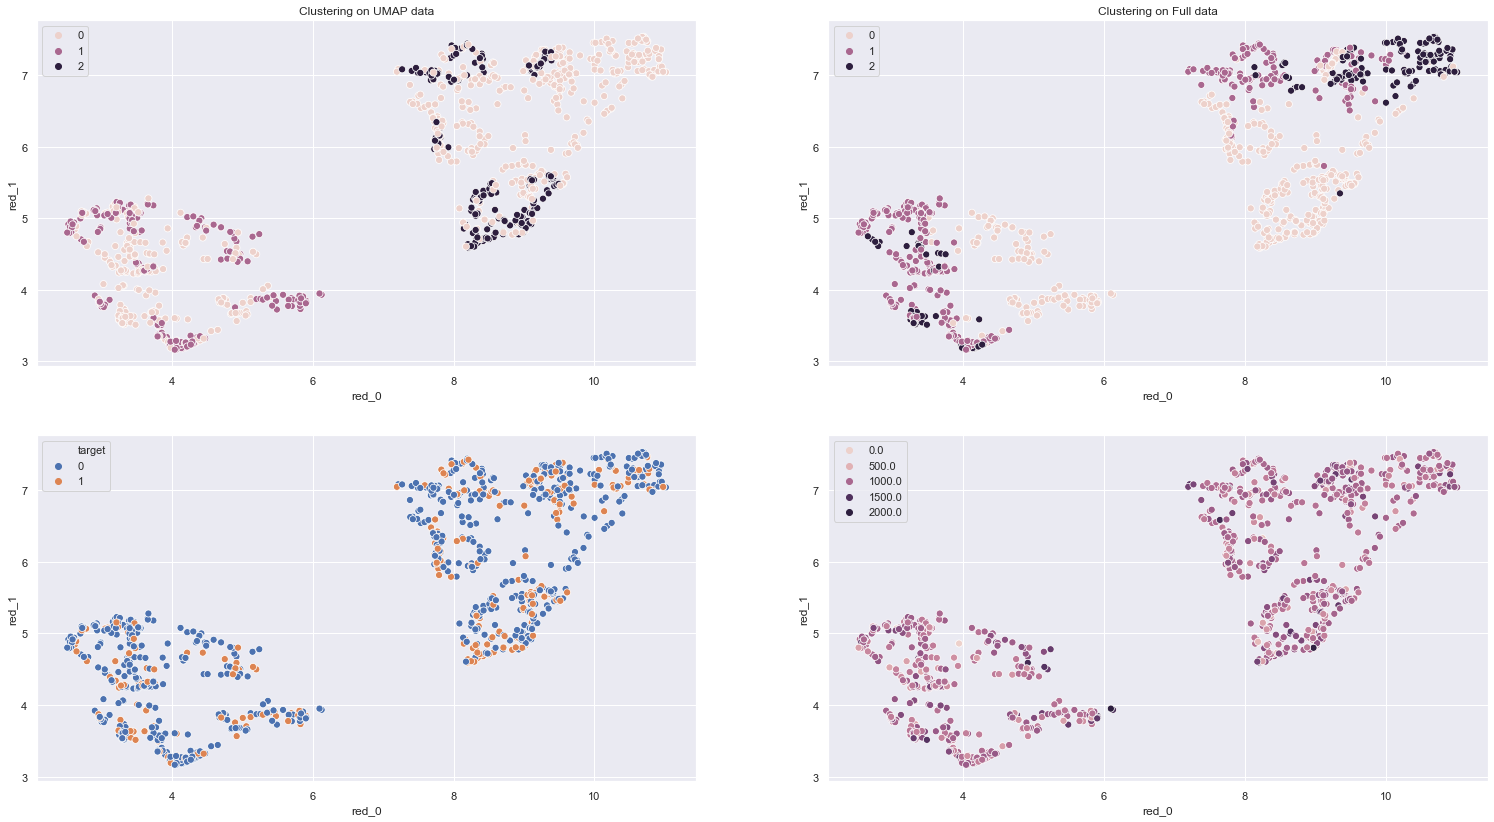

In [493]:
# Agglomerative clustering
if patient_clustering:
    cluster_agglo = AgglomerativeClustering(n_clusters=3, distance_threshold=None, affinity='euclidean')
    cluster_agglo.fit(red_data)
    labs = cluster_agglo.labels_

    cluster_agglo.fit(_dat[var_cols])
    labs_full = cluster_agglo.labels_

    red_data['agg_cluster_from_umap'] = labs
    red_data['agg_cluster_from_full'] = labs_full

    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(26,14))
    sns.scatterplot(data=red_data, x='red_0', y='red_1', hue=labs, s=50, ax=ax[0,0])
    sns.scatterplot(data=red_data, x='red_0', y='red_1', hue=labs_full, s=50, ax=ax[0,1])

    sns.scatterplot(data=red_data, x='red_0', y='red_1', hue=y, s=50, ax=ax[1,0])
    try:
        sns.scatterplot(data=red_data, x='red_0', y='red_1', hue=mah, s=50, ax=ax[1,1])
    except Exception as e:
        print("Mahalanobis values are not available")
    ax[0, 0].set_title('Clustering on UMAP data')
    ax[0, 1].set_title('Clustering on Full data')


## Affinity propagation

H:\PythonVENV\Envs\base\lib\site-packages\sklearn\cluster\_affinity_propagation.py:226: ConvergenceWarning: Affinity propagation did not converge, this model will not have any cluster centers.
  "will not have any cluster centers.", ConvergenceWarning)


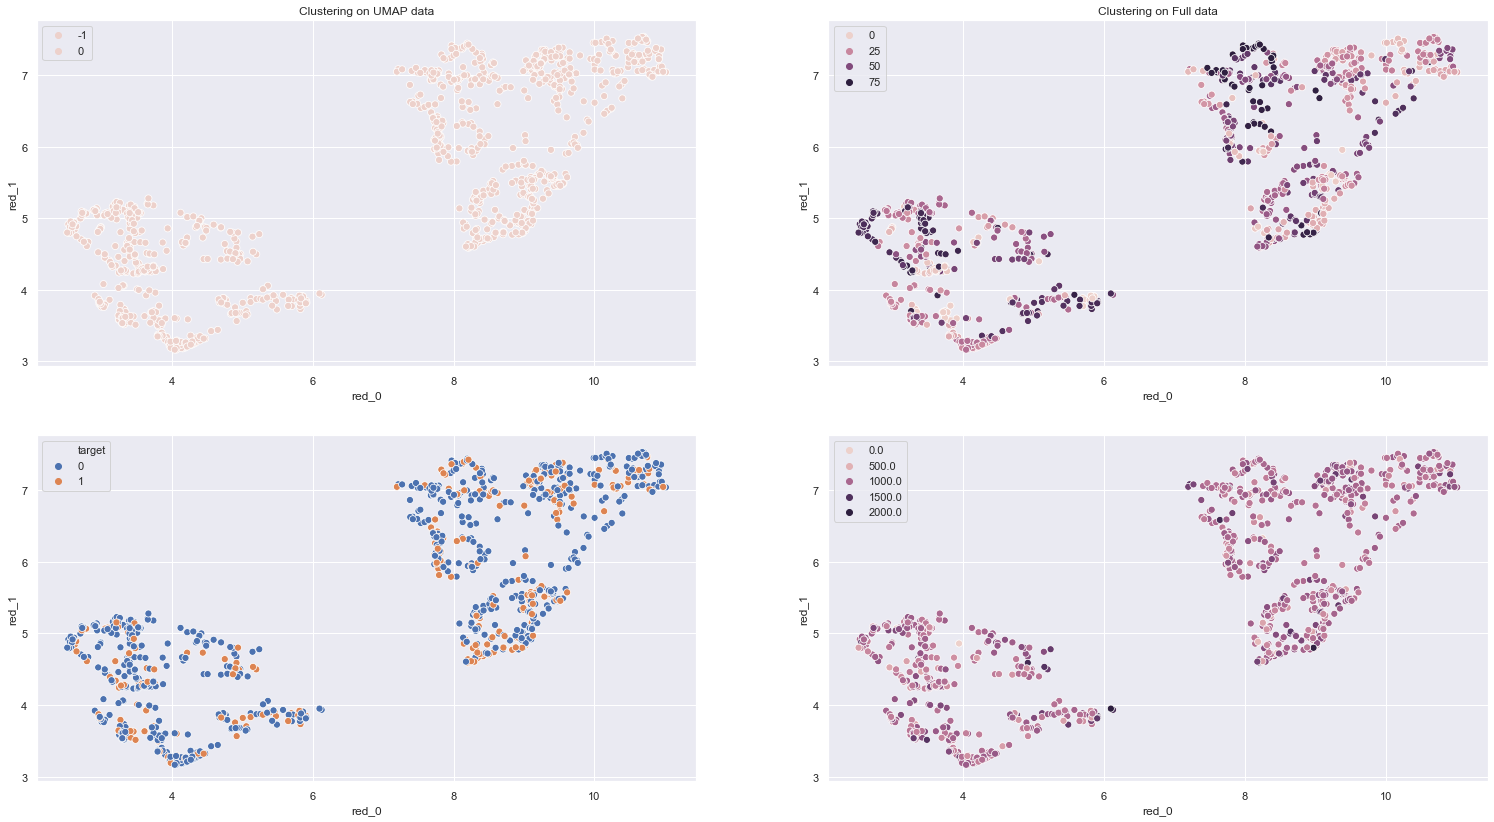

In [494]:
if patient_clustering:
    cluster_aff = AffinityPropagation(damping=0.5, max_iter=200, convergence_iter=20)
    cluster_aff.fit(red_data)
    labs = cluster_aff.labels_

    cluster_aff.fit(_dat[var_cols])
    labs_full = cluster_aff.labels_

    red_data['aff_cluster_from_umap'] = labs
    red_data['aff_cluster_from_full'] = labs_full

    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(26,14))
    sns.scatterplot(data=red_data, x='red_0', y='red_1', hue=labs, s=50, ax=ax[0,0])
    sns.scatterplot(data=red_data, x='red_0', y='red_1', hue=labs_full, s=50, ax=ax[0,1])

    sns.scatterplot(data=red_data, x='red_0', y='red_1', hue=y, s=50, ax=ax[1,0])
    try:
        sns.scatterplot(data=red_data, x='red_0', y='red_1', hue=mah, s=50, ax=ax[1,1])
    except Exception as e:
        print("Mahalanobis values are not available")
    ax[0, 0].set_title('Clustering on UMAP data')
    ax[0, 1].set_title('Clustering on Full data')

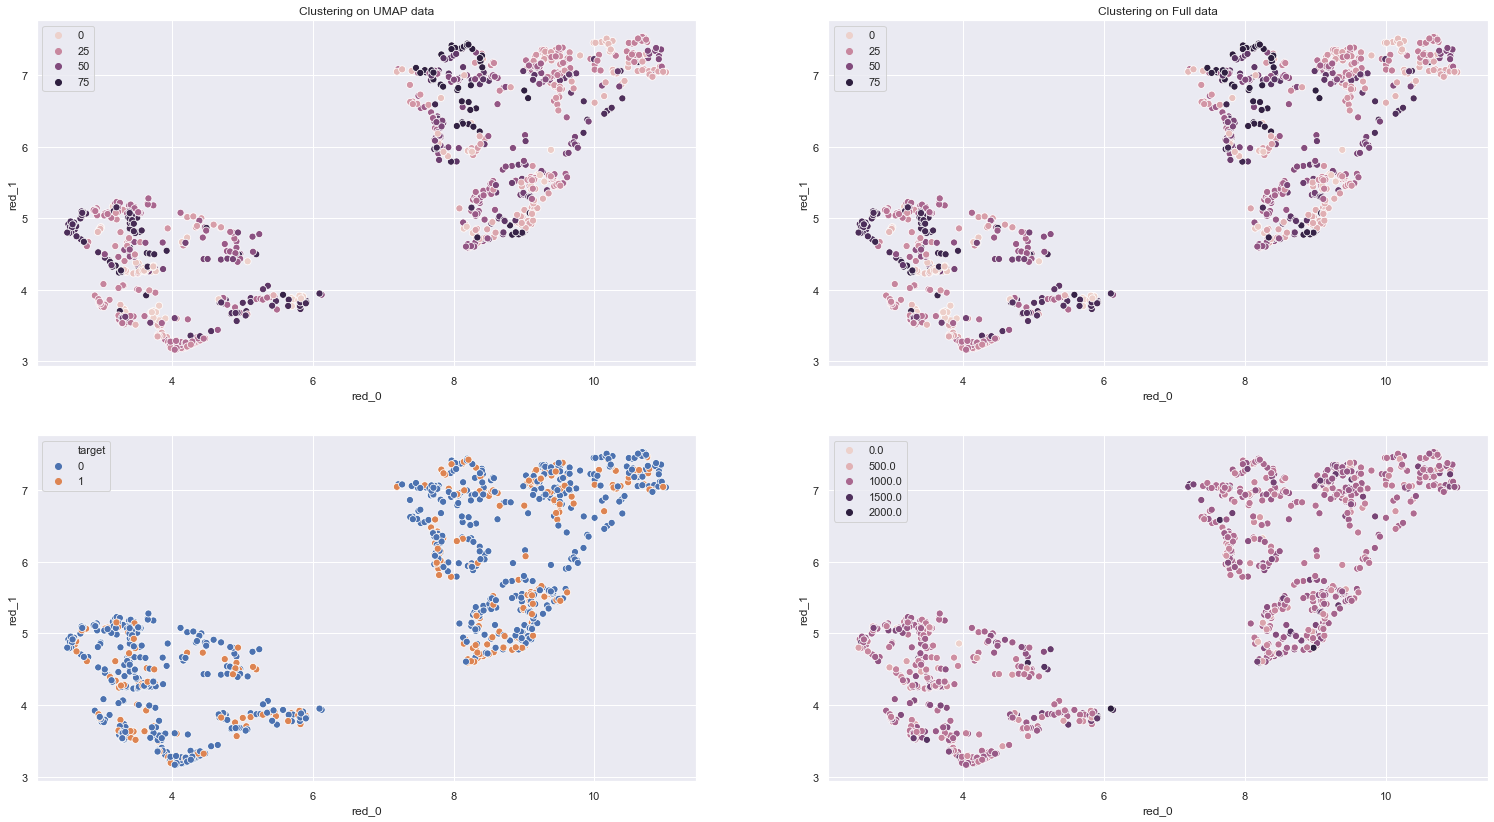

In [495]:
if patient_clustering:
    cluster_hdbscan = HDBSCAN()
    cluster_hdbscan.fit(red_data)
    labs = cluster_aff.labels_

    cluster_aff.fit(_dat[var_cols])
    labs_full = cluster_aff.labels_

    red_data['hdb_cluster_from_umap'] = labs
    red_data['hdb_cluster_from_full'] = labs_full

    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(26,14))
    sns.scatterplot(data=red_data, x='red_0', y='red_1', hue=labs, s=50, ax=ax[0,0])
    sns.scatterplot(data=red_data, x='red_0', y='red_1', hue=labs_full, s=50, ax=ax[0,1])

    sns.scatterplot(data=red_data, x='red_0', y='red_1', hue=y, s=50, ax=ax[1,0])
    try:
        sns.scatterplot(data=red_data, x='red_0', y='red_1', hue=mah, s=50, ax=ax[1,1])
    except Exception as e:
        print("Mahalanobis values are not available")
    ax[0, 0].set_title('Clustering on UMAP data')
    ax[0, 1].set_title('Clustering on Full data')

## Statistical test for significant difference between clusters

Patients with 95% certainty for N-NSTEMI for AP/OPTICS/Spectral/HDB = 55/376/4/55
Patients with 75% certainty for NSTEMI for AP/OPTICS/Spectral/HDB = 8/46/08
OPTICS could not cluster 527.0 patients


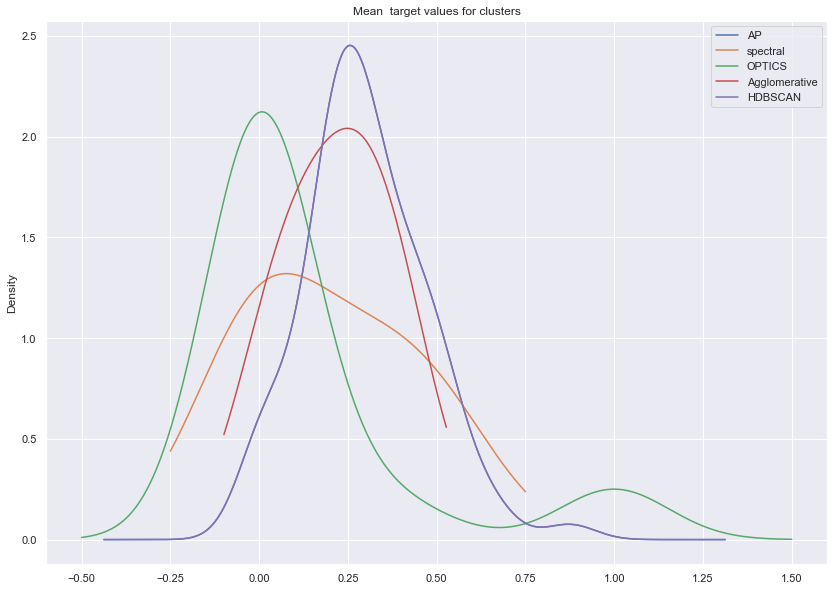

In [502]:
## Spectral, Agglomerative, Affinity, OPTICS
if patient_clustering:
    try:
        aff_prop = red_data.groupby('aff_cluster_from_full')['target'].agg(['mean', 'count'])
        aff_prop['mean'].plot.kde(label='AP', figsize=(14,10))
    except Exception as e:
        print(e)

    spec_prop = red_data.groupby('spectral_cluster_from_full')['target'].agg(['mean', 'count'])
    spec_prop['mean'].plot.kde(label='spectral')

    opt_prop = red_data.groupby('optics_cluster_from_umap')['target'].agg(['mean', 'count'])
    opt_prop['mean'].plot.kde(label='OPTICS')

    agg_prop = red_data.groupby('agg_cluster_from_umap')['target'].agg(['mean', 'count'])
    agg_prop['mean'].plot.kde(label='Agglomerative')
    
    hdb_prop = red_data.groupby('hdb_cluster_from_umap')['target'].agg(['mean', 'count'])
    hdb_prop['mean'].plot.kde(label='HDBSCAN')

    plt.legend()
    plt.title("Mean  target values for clusters")
    
    print("Patients with 95% certainty for N-NSTEMI for AP/OPTICS/Spectral/HDB = {}/{}/{}/{}".format(
            aff_prop.loc[aff_prop['mean']<0.05]['count'].sum(), 
            opt_prop.loc[opt_prop['mean']<0.05]['count'].sum(),
            spec_prop.loc[spec_prop['mean']<0.05]['count'].sum(),
            hdb_prop.loc[hdb_prop['mean']<0.05]['count'].sum()))

    print("Patients with 75% certainty for NSTEMI for AP/OPTICS/Spectral/HDB = {}/{}/{}{}".format(
                aff_prop.loc[aff_prop['mean']>0.75]['count'].sum(), 
                opt_prop.loc[opt_prop['mean']>0.75]['count'].sum(),
                spec_prop.loc[spec_prop['mean']>0.75]['count'].sum(),
                hdb_prop.loc[hdb_prop['mean']>.75]['count'].sum()))
    
    print("OPTICS could not cluster {} patients".format(opt_prop.loc[-1]['count']))

# Supervised performance of mappers

In [503]:
len(col_dict['history']), len(col_dict['pheno']), len(col_dict['hs']), len(col_dict['slope']), len(col_dict['ecg']), len(col_dict['celldyn'])

(7, 3, 25, 5, 325, 513)

In [505]:
cols = col_dict['pheno']+col_dict['celldyn']+col_dict['ecg']+col_dict['history']+col_dict['troponine']+col_dict['inter_celldyn']+col_dict['inter_ecg']

## UMAP

0.65 0.36363636363636365 0.5619629127091813


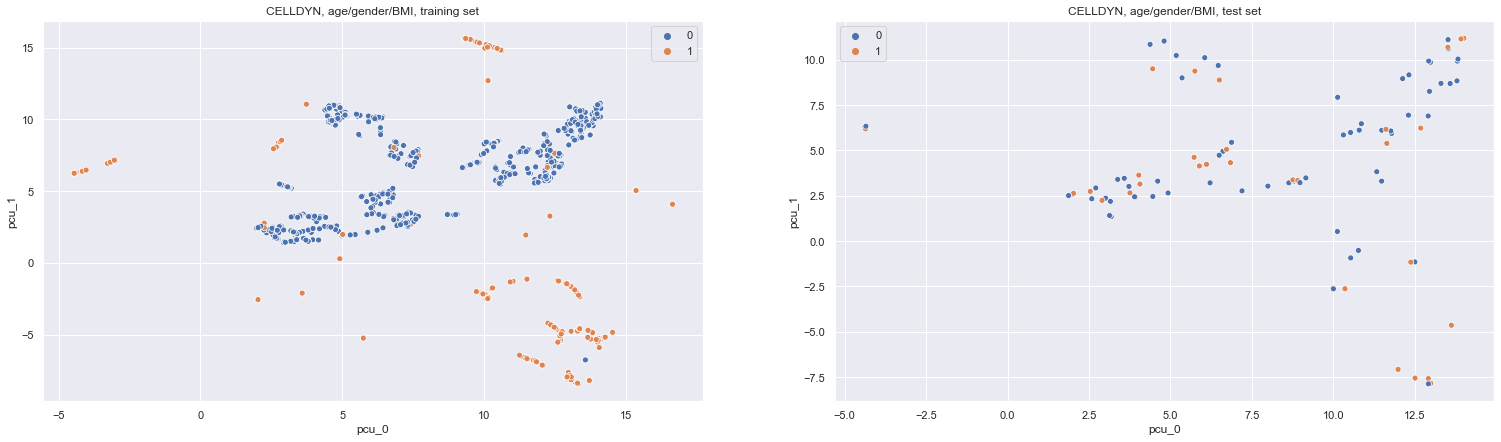

In [506]:
run_supervised_umap = True
remove_outlying_samples_from_test = False
n_comps_viz = 2
n_comps_class = 2
if run_supervised_umap:
    X_train, X_test, y_train, y_test = train_test_split(dat[cols], y, test_size=0.1, random_state=89)
    if remove_outlying_samples_from_test:
        iso = IsolationForest(n_estimators=400, n_jobs=4)
        iso.fit(X_train)
        out_in = iso.predict(X_test)
        X_test = X_test.values[np.where(out_in==1)[0].tolist(),:]
        y_test = y_test[np.where(out_in==1)[0].tolist()]


    umap = UMAP(n_components=n_comps_viz, n_neighbors=7, min_dist=0.05, random_state=323)
    umap.fit(X_train, y_train)

    red_cols = ['pcu_'+str(k) for k in range(0,n_comps_viz)]
    train_transform = pd.DataFrame(data=umap.transform(X_train), columns=red_cols)
    test_transform = pd.DataFrame(data=umap.transform(X_test), columns=red_cols)

    fig, ax = plt.subplots(ncols=2, figsize=(26,7))
    sns.scatterplot(data=train_transform, x='pcu_0', y='pcu_1', hue=y_train.values, ax=ax[0])
    sns.scatterplot(data=test_transform, x='pcu_0', y='pcu_1', hue=y_test.values, ax=ax[1])
    ax[0].set_title('CELLDYN, age/gender/BMI, training set')
    ax[1].set_title('CELLDYN, age/gender/BMI, test set')
    
     # get_var_cols(col_dict)
    #cols = col_dict['celldyn']+['AGE', 'gender', 'BMI']+['RF_Smok', 'RF_HyperTens', 'RF_Diab', 'RF_FamHist', 'RF_CVDHist', 'RF_HyperChol', 'tn_admission']#+hs_cols+col_dict['ecg'];
    clf = RandomForestClassifier() # KNeighborsClassifier(n_neighbors=20, metric='minkowski', p=1)
    X_train, X_test, y_train, y_test = train_test_split(dat[cols], y, test_size=0.1, random_state=None)
    umap = UMAP(n_components=n_comps_class, n_neighbors=7, min_dist=0.07)
    umap.fit(X_train, y_train)

    train_transform = umap.transform(X_train)
    test_transform = umap.transform(X_test)

    clf.fit(train_transform, y_train)
    y_pred = clf.predict(test_transform)

    print(metrics.accuracy_score(y_test, y_pred), metrics.f1_score(y_test, y_pred), metrics.roc_auc_score(y_test, y_pred))

Using CELLDYN data plus meta information and clinically available information we see that the supervised embedding generalises rather poorly. We expect that with more data this generalisation improves.

## SOM

SuSi: [paper](https://arxiv.org/abs/1903.11114), [code](https://github.com/felixriese/susi)

In [507]:
if experimental_supervisors:
    import susi

    X_train, X_test, y_train, y_test = train_test_split(dat[cols], y, test_size=0.1, random_state=89)

    cclf = susi.SOMClustering(n_rows=31, n_columns=31)
    cclf.fit(dat[cols].values)
    print("-- SOM fitted --")

    u_matrix = cclf.get_u_matrix()
    plt.imshow(np.squeeze(u_matrix), cmap="inferno_r")
    plt.colorbar()
    plt.show()

    clf = susi.SOMClassifier(n_rows=61,
                             n_columns=61,
                             n_iter_unsupervised=5000,
                             n_iter_supervised=5000,
                             random_state=0)
    clf.fit(X_train, y_train.astype(np.int32))

    y_pred = clf.predict(X_test)
    print(metrics.accuracy_score(y_test, y_pred), metrics.f1_score(y_test, y_pred), metrics.roc_auc_score(y_test, y_pred))

## LVQ

In [508]:
if experimental_supervisors:
    from neupy import algorithms

    # reduce
    red = UMAP(n_components=40, n_neighbors=30, min_dist=0.01)
    #red = PCA(n_components=30)
    red.fit(X_train)
    X_train = red.transform(X_train)
    X_test = red.transform(X_test)


    clf = algorithms.LVQ(n_inputs=X_train.shape[1], n_classes=2, n_subclasses=11, shuffle_data=False)
    clf.train(X_train, y_train, epochs=500)
    y_pred = clf.predict(X_test)
    print(metrics.accuracy_score(y_test, y_pred), metrics.f1_score(y_test, y_pred), metrics.roc_auc_score(y_test, y_pred))

    clf = algorithms.LVQ21(n_inputs=X_train.shape[1], n_classes=2, n_subclasses=11, shuffle_data=False)
    clf.train(X_train, y_train, epochs=500)
    y_pred = clf.predict(X_test)
    print(metrics.accuracy_score(y_test, y_pred), metrics.f1_score(y_test, y_pred), metrics.roc_auc_score(y_test, y_pred))

    clf = algorithms.LVQ3(n_inputs=X_train.shape[1], n_classes=2, n_subclasses=11, shuffle_data=False)
    clf.train(X_train, y_train, epochs=500)
    y_pred = clf.predict(X_test)
    print(metrics.accuracy_score(y_test, y_pred), metrics.f1_score(y_test, y_pred), metrics.roc_auc_score(y_test, y_pred))

Learning vector quantisation is clearly not able to separate the classses, we can possibly improve this model using parameter tuning but that is beyond the scope of this work.

# Supervised classifiers

In [509]:
scores = dict()
model = dict()
cols = col_dict['pheno']+col_dict['celldyn']+col_dict['ecg']+col_dict['history']+['tn_admission']+inter_celldyn_cols+inter_ecg_cols
scoring = {'auc': 'roc_auc', 
           'balanced_accuracy': 'balanced_accuracy',
           'f1_macro': 'f1_macro', 
           'f1_micro': 'f1_micro',
           'prec_macro': 'precision_macro', 
           'prec_micro': 'precision_micro',
           'mcc': make_scorer(mcc, thresh=0.5, greedy='symmetric'),
           'spec': make_scorer(spec, thresh=0.5, greedy='symmetric'),
           'prec': make_scorer(prec, thresh=0.5, greedy='symmetric'),
           'npv': make_scorer(metrics.precision_score, pos_label=0),
           'rec_macro': make_scorer(recall_score, average='macro'),
           'rec_micro': make_scorer(recall_score, average='micro')}

## model comparison

H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\

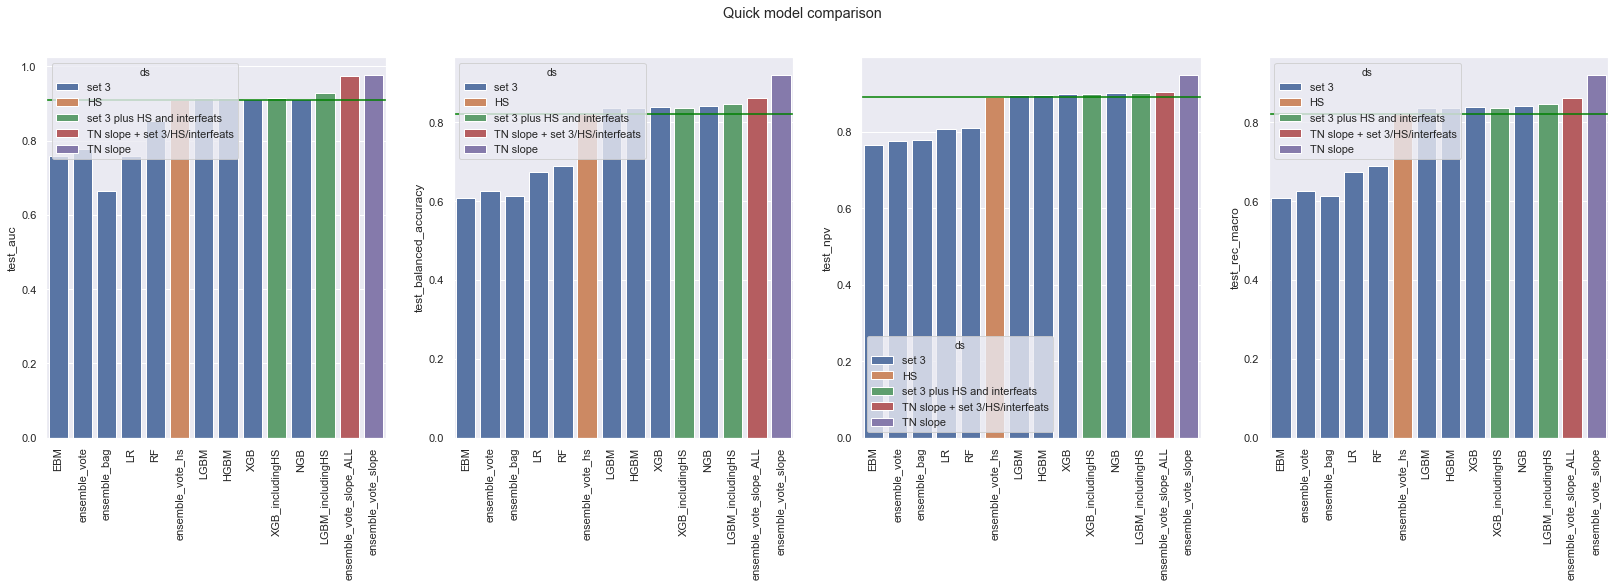

In [510]:
if model_comparison:    
    model['HGBM'] = HistGradientBoostingClassifier(max_iter=500)
    scores['HGBM'] = pd.DataFrame(cross_validate(model['HGBM'], dat[cols].values, y.values, scoring=scoring, cv=10, return_train_score=True))

    model['NGB'] = NGBClassifier(n_estimators=300, verbose=0, Dist=Bernoulli) # k_categorical(2)
    scores['NGB'] = pd.DataFrame(cross_validate(model['NGB'], dat[cols].values, y.values, scoring=scoring, cv=10, return_train_score=True))
    
    #model['LDA'] = LDA()
    #scores['LDA'] = pd.DataFrame(cross_validate(model['LDA'], dat[cols].values, y.values, scoring=scoring, cv=10, return_train_score=True))
    
    model['LR'] = LogisticRegression(max_iter=500, penalty='l1', solver='liblinear')
    scores['LR'] = pd.DataFrame(cross_validate(model['LR'], dat[cols].values, y.values, scoring=scoring, cv=10, return_train_score=True))
    
    model['RF'] = RandomForestClassifier(n_estimators=500)
    scores['RF'] = pd.DataFrame(cross_validate(model['RF'], dat[cols].values, y.values, scoring=scoring, cv=10, return_train_score=True))
    
    #model['SVC'] = NuSVC(nu=0.5)
    #scores['SVC'] = pd.DataFrame(cross_validate(model['SVC'], dat[cols].values, y.values, scoring=scoring, cv=10, return_train_score=True))
    
    #model['MLP'] = MLPClassifier(hidden_layer_sizes=(100,50,25), max_iter=200, learning_rate_init=0.005, learning_rate='adaptive')
    #scores['MLP'] = pd.DataFrame(cross_validate(model['MLP'], dat[cols].values, y.values, scoring=scoring, cv=10, return_train_score=True))
    
    clfs = [('RF', RandomForestClassifier(n_estimators=200, n_jobs=4)),
        ('nuSVC', NuSVC(nu=0.5, probability=True)),
        ('LR', LogisticRegression(max_iter=500, solver='liblinear')),
        ('MLP', MLPClassifier(hidden_layer_sizes=(100,50,50), 
                              max_iter=200, learning_rate_init=0.005, learning_rate='adaptive'))]
    model['ensemble_vote'] = VotingClassifier(clfs, voting='soft', weights=[10, 5, 7, 3])
    scores['ensemble_vote'] = pd.DataFrame(cross_validate(model['ensemble_vote'], dat[cols].values, y.values, 
                                                          scoring=scoring, 
                                                          cv=10, return_train_score=True))
    
    model['ensemble_bag'] = BaggingClassifier(base_estimator=LogisticRegression(max_iter=500, solver='liblinear'), n_estimators=5)
    scores['ensemble_bag'] = pd.DataFrame(cross_validate(model['ensemble_bag'], dat[cols].values, y.values, 
                                                        scoring=scoring, 
                                                         cv=10, return_train_score=True))
    
    clfs = [('RF', RandomForestClassifier(n_estimators=50, n_jobs=4)),
        ('nuSVC', NuSVC(nu=0.5, probability=True)),
        ('LR', LogisticRegression(max_iter=500, solver='liblinear')),
        ('MLP', MLPClassifier(hidden_layer_sizes=(40,30,20), 
                              max_iter=200, learning_rate_init=0.002, learning_rate='adaptive'))]
    model['ensemble_vote_hs'] = VotingClassifier(clfs, voting='soft', weights=[10, 5, 7, 3])
    scores['ensemble_vote_hs'] = pd.DataFrame(cross_validate(model['ensemble_vote_hs'], dat[hs_cols].values, y.values, 
                                                          scoring=scoring, 
                                                          cv=10, return_train_score=True))
    
    # tn_slope_cols
    clfs = [('RF', RandomForestClassifier(n_estimators=25, n_jobs=4)),
            ('nuSVC', NuSVC(nu=0.5, probability=True)),
            ('LR', LogisticRegression(max_iter=500, solver='liblinear')),
            ('MLP', MLPClassifier(hidden_layer_sizes=(30,20,10), 
                                  max_iter=500, learning_rate_init=0.002, learning_rate='adaptive'))]
    model['ensemble_vote_slope'] = VotingClassifier(clfs, voting='soft', weights=[10, 5, 7, 3])
    scores['ensemble_vote_slope'] = pd.DataFrame(cross_validate(model['ensemble_vote_slope'], dat[tn_slope_cols+hs_cols].values, y.values, 
                                                          scoring=scoring, 
                                                          cv=10, return_train_score=True))
    
    # tn_slope_cols
    clfs = [('RF', RandomForestClassifier(n_estimators=200, n_jobs=4)),
            ('nuSVC', NuSVC(nu=0.5, probability=True)),
            ('LR', LogisticRegression(max_iter=500, solver='liblinear')),
            ('MLP', MLPClassifier(hidden_layer_sizes=(100,50,50), 
                                  max_iter=500, learning_rate_init=0.002, learning_rate='adaptive'))]


    model['ensemble_vote_slope_ALL'] = VotingClassifier(clfs, voting='soft', weights=[10, 7, 5, 3])
    scores['ensemble_vote_slope_ALL'] = pd.DataFrame(cross_validate(model['ensemble_vote_slope_ALL'], dat[tn_slope_cols+hs_cols+cols].values, y.values, 
                                                          scoring=scoring, 
                                                          cv=10, return_train_score=True))
    
    # celldyn+age+sex+BMI+troponine
    clfs = [('RF', RandomForestClassifier(n_estimators=200, n_jobs=4)),
            ('nuSVC', NuSVC(nu=0.5, probability=True)),
            ('LR', LogisticRegression(max_iter=500, solver='liblinear')),
            ('MLP', MLPClassifier(hidden_layer_sizes=(100,50,50), 
                                  max_iter=500, learning_rate_init=0.005, learning_rate='adaptive'))]
    model['ensemble_vote'] = VotingClassifier(clfs, voting='soft', weights=[10, 7, 5, 3])
    scores['ensemble_vote'] = pd.DataFrame(cross_validate(model['ensemble_vote'], dat[cols].values, y.values, 
                                                          scoring=scoring, 
                                                          cv=10, return_train_score=True))
    
    # celldyn+age+sex+BMI+troponine
    clfs = [('RF', RandomForestClassifier(n_estimators=200, n_jobs=4)),
            ('nuSVC', NuSVC(nu=0.5, probability=True)),
            ('LR', LogisticRegression(max_iter=500, solver='liblinear')),
            ('MLP', MLPClassifier(hidden_layer_sizes=(100,50,50), 
                                  max_iter=500, learning_rate_init=0.005, learning_rate='adaptive'))]


    model['ensemble_vote'] = VotingClassifier(clfs, voting='soft', weights=[10, 7, 5, 3])

    scores['ensemble_vote'] = pd.DataFrame(cross_validate(model['ensemble_vote'], dat[cols].values, y.values, 
                                                          scoring=scoring, 
                                                          cv=10, return_train_score=True))
    
    
    model['EBM'] = EBM()
    #red_umap = UMAP(n_components=32)
    X = dat[cols].values
    #X = red_umap.fit_transform(X)
    scores['EBM'] = pd.DataFrame(cross_validate(model['EBM'], X, y.values, 
                                                          scoring=scoring, 
                                                          cv=10, return_train_score=True))
    
    model['XGB'] = XGB(n_jobs=8)
    scores['XGB'] = pd.DataFrame(cross_validate(model['XGB'], dat[cols].values, y.values, 
                                                          scoring=scoring, 
                                                          cv=10, return_train_score=True))
    
    model['XGB_includingHS'] = XGB(n_jobs=8)
    scores['XGB_includingHS'] = pd.DataFrame(cross_validate(model['XGB_includingHS'], dat[cols+hs_cols].values, 
                                                            y.values, scoring=scoring, cv=10, return_train_score=True))

    model['LGBM'] = LGBM(n_jobs=8)
    scores['LGBM'] = pd.DataFrame(cross_validate(model['LGBM'], dat[cols].values, y.values, 
                                                          scoring=scoring, 
                                                          cv=10, return_train_score=True))

    model['LGBM_includingHS']  = LGBM(n_jobs=8)
    scores['LGBM_includingHS'] = pd.DataFrame(cross_validate(model['LGBM_includingHS'] , dat[cols+hs_cols].values, y.values, 
                                                          scoring=scoring, 
                                                          cv=10, return_train_score=True))
    
    ######################################
    ######################################
    
    for idx, _mod in enumerate(scores.keys()):
        if idx==0:
            df = scores[_mod].mean().transpose()
        else:
            df = pd.concat([df, scores[_mod].mean()], axis=1)
    df.columns = list(scores.keys())
    df.drop(['fit_time', 'score_time'], axis=0, inplace=True)
    df = df.transpose()
    df.reset_index(inplace=True)
    df.sort_values(by='test_npv', inplace=True)

    col_map = {'LGBM_includingHS': 'set 3 plus HS and interfeats',
               'XGB_includingHS': 'set 3 plus HS and interfeats',
               'ensemble_vote_hs': 'HS',
               'ensemble_vote_slope': 'TN slope',
               'ensemble_vote_slope_ALL': 'TN slope + set 3/HS/interfeats',
               np.nan : 'set 3'
               }
    df['ds'] = df['index'].map(col_map).fillna('set 3')

    fig, ax = plt.subplots(ncols=4, figsize=(28, 7))

    # specificity
    # precision

    sns.barplot(data=df, x='index', y='test_auc', hue='ds', dodge=False, ax=ax[0])
    ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=90)
    ax[0].axhline(df.loc[df['index']=='ensemble_vote_hs', 'test_auc'].values[0], color='green')

    sns.barplot(data=df, x='index', y='test_balanced_accuracy', ax=ax[1], hue='ds', dodge=False)
    ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90)
    ax[1].axhline(df.loc[df['index']=='ensemble_vote_hs', 'test_balanced_accuracy'].values[0], color='green')

    sns.barplot(data=df, x='index', y='test_npv', ax=ax[2], hue='ds', dodge=False)
    ax[2].set_xticklabels(ax[2].get_xticklabels(), rotation=90)
    ax[2].axhline(df.loc[df['index']=='ensemble_vote_hs', 'test_npv'].values[0], color='green')

    sns.barplot(data=df, x='index', y='test_rec_macro', ax=ax[3], hue='ds', dodge=False)
    ax[3].set_xticklabels(ax[3].get_xticklabels(), rotation=90)
    ax[3].axhline(df.loc[df['index']=='ensemble_vote_hs', 'test_rec_macro'].values[0], color='green')

    ax[0].set_xlabel('')
    ax[1].set_xlabel('')
    ax[2].set_xlabel('')
    ax[3].set_xlabel('')
    fig.suptitle("Quick model comparison")

In [511]:
class_weights = {0: 1., 1: 2.}
X = dat[cols].values
X = _transform(X, trans='quantile')[0]
X_train, X_test, y_train, y_test = train_test_split(X, y.values, test_size=0.1, stratify=y.values)
clf = fit_nn(X_train, y_train, network='dnn', verbose=0, batch_size=250, epochs=100, class_weight=class_weights)
y_pred = clf.predict(X_test)

print("Same transformer..Balanced accuracy: {}, F1 score: {}, ROC AUC: {}".format(balanced_accuracy(y_test, np.round(y_pred[:,0])), 
                                                            fb_score(y_test, np.round(y_pred[:,0])),
                                                            metrics.roc_auc_score(y_test, y_pred[:,0])))


WARNING (2020-02-12 07:12:21): From H:\PythonVENV\Envs\base\lib\site-packages\tensorflow\python\ops\control_flow_ops.py:423: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.
WARNING (2020-02-12 07:12:22): From H:\PythonVENV\Envs\base\lib\site-packages\tensorflow\python\ops\math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.


Same transformer..Balanced accuracy: 0.7132936507936507, F1 score: 0.5862068965517241, ROC AUC: 0.7356150793650793


<<DNN>> Train transformer..Balanced accuracy: 0.6984126984126984, F1 score: 0.5660377358490566, ROC AUC: 0.8288690476190476


Text(0.5, 1.0, 'Pseudo-probas')

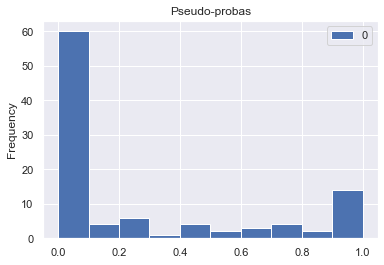

In [512]:
# repeat for train transformer applied to test.
class_weights = {0: 1., 1: 3.}
X = dat[cols].values
X_train, X_test, y_train, y_test = train_test_split(X, y.values, test_size=0.1, stratify=y.values)
X_train, _transformers = _transform(X_train, trans='quantile')
X_test = X_test if _transformers is None else _transformers[1].transform(_transformers[0].transform(X_test))

clf = fit_nn(X_train, y_train, network='dnn', verbose=0, batch_size=250, epochs=150, class_weight=class_weights)
y_pred = clf.predict(X_test)

print("<<DNN>> Train transformer..Balanced accuracy: {}, F1 score: {}, ROC AUC: {}".format(balanced_accuracy(y_test, np.round(y_pred[:,0])), 
                                                            fb_score(y_test, np.round(y_pred[:,0])),
                                                            metrics.roc_auc_score(y_test, y_pred[:,0])))
pd.DataFrame(y_pred[:, 0]).plot.hist(bins=10)
plt.title('Pseudo-probas')

<<CNN>> Train transformer..Balanced accuracy: 0.5515873015873015, F1 score: 0.2857142857142857, ROC AUC: 0.6741071428571428


Text(0.5, 1.0, 'Pseudo-probas')

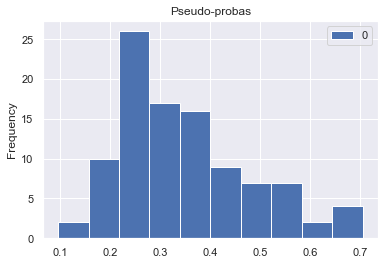

In [513]:
# repeat for train transformer applied to test.
cols= col_dict['ecg']+col_dict['celldyn']+inter_celldyn_cols
class_weights = {0: 1., 1: 3.}
X = dat[cols].values
X_train, X_test, y_train, y_test = train_test_split(X, y.values, test_size=0.1, stratify=y.values)
X_train, _transformers = _transform(X_train, trans='quantile')
X_test = X_test if _transformers is None else _transformers[1].transform(_transformers[0].transform(X_test))


clf = fit_nn(X_train, y_train, network='cnn', verbose=0, batch_size=132, epochs=100, class_weight=class_weights, convs_cnn=[(128,3,2,1), 
                                                                                                                       (64,3,2,1), 
                                                                                                                       (32,3,1,1)])
X_test = np.expand_dims(X_test, 2)
y_pred = clf.predict(X_test)

print("<<CNN>> Train transformer..Balanced accuracy: {}, F1 score: {}, ROC AUC: {}".format(balanced_accuracy(y_test, np.round(y_pred[:,0])), 
                                                            fb_score(y_test, np.round(y_pred[:,0])),
                                                            metrics.roc_auc_score(y_test, y_pred[:,0])))
pd.DataFrame(y_pred[:, 0]).plot.hist(bins=10)
plt.title('Pseudo-probas')

It seems that both the dense and the convolutional networks perform reasonably well on this problem,
again this can possibly be improved with parameter tuning but this is beyond the scope of this work.

### feature importances

In [514]:
if extensive_feature_importances:
    cols = col_dict['ecg']+col_dict['celldyn']+col_dict['pheno']+col_dict['history']+['tn_admission']+col_dict['hs']
    xgb_mod = XGB(n_estimators=300, max_depth=2)
    n_splits =10
    XGB_RES = pd.DataFrame(cross_validate(xgb_mod, dat[cols].values, y.values, 
                                                          scoring=scoring, 
                                                          cv=n_splits, return_train_score=True, return_estimator=True))
    importances = pd.DataFrame(data=XGB_RES.estimator[0].feature_importances_, index=cols, columns=['xgb_0'])

    for i in range(1, n_splits):
        importances['xgb_'+str(i)] = XGB_RES.estimator[i].feature_importances_

    #########################
    lgbm_mod = LGBM(n_estimators=300, max_depth=2)
    LGBM_RES = pd.DataFrame(cross_validate(lgbm_mod, dat[cols].values, y.values, 
                                                          scoring=scoring, 
                                                          cv=10, return_train_score=True, return_estimator=True))
    for i in range(0, n_splits):
        importances['lgbm_'+str(i)] = LGBM_RES.estimator[i].feature_importances_

    #########################

    et_mod = ExtraTreesClassifier(n_estimators=600, max_depth=2)
    ET_RES = pd.DataFrame(cross_validate(et_mod, dat[cols].values, y.values, 
                                                          scoring=scoring, 
                                                          cv=10, return_train_score=True, return_estimator=True))
    for i in range(0, n_splits):
        importances['et_'+str(i)] = ET_RES.estimator[i].feature_importances_

    #########################    
    importances_scaled = pd.DataFrame(data=MinMaxScaler().fit_transform(importances), columns=importances.columns, index=importances.index)


    xgb_cols = [_col for _col in importances.columns if 'xgb' in _col]
    lgbm_cols = [_col for _col in importances.columns if 'lgbm' in _col]
    et_cols = [_col for _col in importances.columns if 'et' in _col]

    importances_scaled.reset_index(inplace=True)
    importances_scaled['ds'] = importances_scaled['index'].map(group_dict)
    importances_scaled.index = importances_scaled['index']

    imp_agg = pd.DataFrame(data=importances_scaled[xgb_cols+['ds']].groupby('ds').sum().mean(axis=1), columns=['xgb'])
    imp_agg['lgbm'] = importances_scaled[lgbm_cols+['ds']].groupby('ds').sum().mean(axis=1)
    imp_agg['et'] = importances_scaled[et_cols+['ds']].groupby('ds').sum().mean(axis=1)

    top_ = dict()
    top_['lgbm'] = importances_scaled[lgbm_cols].mean(axis=1).sort_values(ascending=False)
    top_['xgb']  = importances_scaled[xgb_cols].mean(axis=1).sort_values(ascending=False)
    top_['et'] = importances_scaled[et_cols].mean(axis=1).sort_values(ascending=False)

    tp = ((pd.DataFrame(top_['lgbm'], columns=['lgbm'])).join(pd.DataFrame(top_['xgb'], columns=['xgb']), how='inner'))\
                                .join(pd.DataFrame(top_['et'], columns=['et']), how='inner')
    tp['mean'] = tp.apply(np.mean, axis=1)
    tp['group'] = tp.index.map(group_dict)
    tp.sort_values(by="mean", ascending=False, inplace=True)

    tp[:100].groupby('group')['mean'].agg(['sum', 'count']), tp[:20].groupby('group')['mean'].agg(['sum', 'count'])

    topf=dict()
    topf['lgbm'] = importances_scaled[lgbm_cols].mean(axis=1).sort_values(ascending=False)
    topf['xgb']  = importances_scaled[xgb_cols].mean(axis=1).sort_values(ascending=False)
    topf['et'] = importances_scaled[et_cols].mean(axis=1).sort_values(ascending=False)
    tp = ((pd.DataFrame(topf['lgbm'], columns=['lgbm'])).join(pd.DataFrame(topf['xgb'], columns=['xgb']), how='inner')).join(pd.DataFrame(topf['et'], columns=['et']), how='inner')
    tp['mean'] = tp.apply(np.mean, axis=1)
    tp['group'] = tp.index.map(group_dict)
    tp.sort_values(by="mean", ascending=False, inplace=True)

    features = pd.DataFrame(set(get_var_cols(col_dict)), columns=['feature_name'])
    features['group']=features['feature_name'].map(group_dict, na_action='ignore')
    features.set_index('feature_name', inplace=True)
    features = features.join(tp['mean'], how='inner')
    features.sort_values(by='mean', ascending=False, inplace=True)
    features.to_csv("/laupodteam/AIOS/Bram/data/HeartScore/features.csv", index=False)
    gc.collect()

# Final scoring 

We have the following setup's
* Celldyn 
* Celldyn, age, sex, BMI
* Celldyn, age, sex, BMI, ECG
* (Celldyn, age, sex, BMI, ECG, troponine) - (age, sex, BMI, ECG, troponine)
* reference: Celldyn, age, sex, BMI, ECG, troponine, history
* reference: Celldyn, age, sex, BMI, ECG, troponine, history + HS

**Deliverable**: comparison between datasets in terms of statistical distance between classes/importance of features.

For each setup we obtain the 

1. ROC curves
2. threshold v. recall/precision/F1/true recall
3. threshold v. FN/FP/recall/true recall

Models: XGB, LGBM, RF, ET, nuSVC, GAM, DNN, CNN, LR, LDA, we combine the models using a soft voting classifier.

Pre-processing: 
* feature combination within CELLDYN and the aggregated ECG features 
* feature selection using Anova, [mutual information](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_classif.html) and Kolgomorov-Smirnov and the first Wasserstein distance.

Follow-up:
* identifying promising samples for a celldyn-based predictor, using an auxiliary model
* iteratively add features using Hausdorff distance or some other set distance (perhaps more a mean distance based on the center of the Voronoi diagrams e.g. the K-means clusters)
* true multicollinearity remover using non-overlapping cliques and a similarity threshold, replacing multi-collinear variables with a combined feature
* identify cross-dataset features using ICA/PLS/CCA, e.g. meta-celldyn, meta-ecg features, ecg-celldyn features
* try other dimension reduction techniques, e.g. [BPDR](https://towardsdatascience.com/bpdr-a-new-dimensionality-reduction-technique-f570eea3fc65)
* try AutoML frameworks suchs as TPOT, AutoKeras, H2O and AutoSklearn.
* apply HDBSCAN/DictionaryLearning for clustering, see .e.g. this [blog](https://towardsdatascience.com/how-to-cluster-in-high-dimensions-4ef693bacc6)
* find optimal number of clusters, as done [here](https://towardsdatascience.com/spectral-graph-clustering-and-optimal-number-of-clusters-estimation-32704189afbe)
* try a combination of dataset-specific models
* create three target groups, NSTEMI, NSTEMI with no CV history, NSTEMI with CV history
* performance confidence calibration 
* add CNN/DNN to ensemble
* investigate effect of up-sampling positive targets/down-sampling negative targets
* get more data to identify and categorize the clusters
* use cross_validate and differential evolution (or some other blackbox optimiser) for hyperparameter optimisation
* make NN wrapper more generic so you can play with the architecture
* try supervised PCA for dimension reduction, and MDS/LLE
* identify skewed features and normalise using percentile normalisation:
```size = len(df.Helpful_Votes)-1
helpful_percentile_linearization = df.Helpful_Votes.rank(method=’min’).apply(lambda x: (x-1)/size)
helpful_percentile_linearization.describe()
```
* try autoencoder for dimension reduction
* Apply Deep Feature Synthesis: https://docs.featuretools.com/en/stable/automated_feature_engineering/afe.html
* dimension reduction per feature set
* Use different CalibratedClassifier ```import ml_insights as mli; clfc = mli.SplineCalibratedClassifierCV(clf, cv=3)```
* Perform performance optimisation per dataset, i.e. do not use one model parameterset for different datasets


In [516]:
all_results = []

--- ['pheno'] ---
Processing dataset: 0__withoutCelldyn


H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\

--- ['pheno', 'celldyn'] ---
Processing dataset: 0__withCelldyn


H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\

--- ['pheno', 'ecg'] ---
Processing dataset: 1__withoutCelldyn


H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\

--- ['pheno', 'ecg', 'celldyn'] ---
Processing dataset: 1__withCelldyn


H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\

--- ['pheno', 'ecg', 'tn_admission'] ---
Processing dataset: 2__withoutCelldyn


H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\

--- ['pheno', 'ecg', 'tn_admission', 'celldyn'] ---
Processing dataset: 2__withCelldyn


H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\

--- ['pheno', 'ecg', 'history', 'tn_admission'] ---
Processing dataset: 3__withoutCelldyn


H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\

--- ['pheno', 'ecg', 'history', 'tn_admission', 'celldyn'] ---
Processing dataset: 3__withCelldyn


H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\

--- ['pheno', 'ecg', 'history', 'tn_admission', 'inter_ecg'] ---
Processing dataset: 4__withoutCelldyn


H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\

--- ['pheno', 'ecg', 'history', 'tn_admission', 'celldyn', 'inter_ecg', 'inter_celldyn'] ---
Processing dataset: 4__withCelldyn


H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\

--- ['pheno', 'ecg', 'history', 'tn_admission', 'hs', 'inter_ecg'] ---
Processing dataset: 5__withoutCelldyn


H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\

--- ['pheno', 'ecg', 'history', 'tn_admission', 'hs', 'celldyn', 'inter_ecg', 'inter_celldyn'] ---
Processing dataset: 5__withCelldyn


H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\

--- ['pheno', 'ecg', 'history', 'tn_admission', 'hs', 'slope', 'inter_ecg'] ---
Processing dataset: 6__withoutCelldyn


H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\

--- ['pheno', 'ecg', 'history', 'tn_admission', 'hs', 'slope', 'celldyn', 'inter_ecg', 'inter_celldyn'] ---
Processing dataset: 6__withCelldyn


H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\

--- ['pheno'] ---
Processing dataset: 0__withoutCelldyn


H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\

--- ['pheno', 'celldyn'] ---
Processing dataset: 0__withCelldyn


H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\

--- ['pheno', 'ecg'] ---
Processing dataset: 1__withoutCelldyn


H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\

--- ['pheno', 'ecg', 'celldyn'] ---
Processing dataset: 1__withCelldyn


H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\

--- ['pheno', 'ecg', 'tn_admission'] ---
Processing dataset: 2__withoutCelldyn


H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\

--- ['pheno', 'ecg', 'tn_admission', 'celldyn'] ---
Processing dataset: 2__withCelldyn


H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\

--- ['pheno', 'ecg', 'history', 'tn_admission'] ---
Processing dataset: 3__withoutCelldyn


H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\

--- ['pheno', 'ecg', 'history', 'tn_admission', 'celldyn'] ---
Processing dataset: 3__withCelldyn


H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\

--- ['pheno', 'ecg', 'history', 'tn_admission', 'inter_ecg'] ---
Processing dataset: 4__withoutCelldyn


H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\

--- ['pheno', 'ecg', 'history', 'tn_admission', 'celldyn', 'inter_ecg', 'inter_celldyn'] ---
Processing dataset: 4__withCelldyn


H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\

--- ['pheno', 'ecg', 'history', 'tn_admission', 'hs', 'inter_ecg'] ---
Processing dataset: 5__withoutCelldyn


H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\

--- ['pheno', 'ecg', 'history', 'tn_admission', 'hs', 'celldyn', 'inter_ecg', 'inter_celldyn'] ---
Processing dataset: 5__withCelldyn


H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\

--- ['pheno', 'ecg', 'history', 'tn_admission', 'hs', 'slope', 'inter_ecg'] ---
Processing dataset: 6__withoutCelldyn


H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\

--- ['pheno', 'ecg', 'history', 'tn_admission', 'hs', 'slope', 'celldyn', 'inter_ecg', 'inter_celldyn'] ---
Processing dataset: 6__withCelldyn


H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: overflow encountered in long_scalars
H:\PythonVENV\Envs\base\

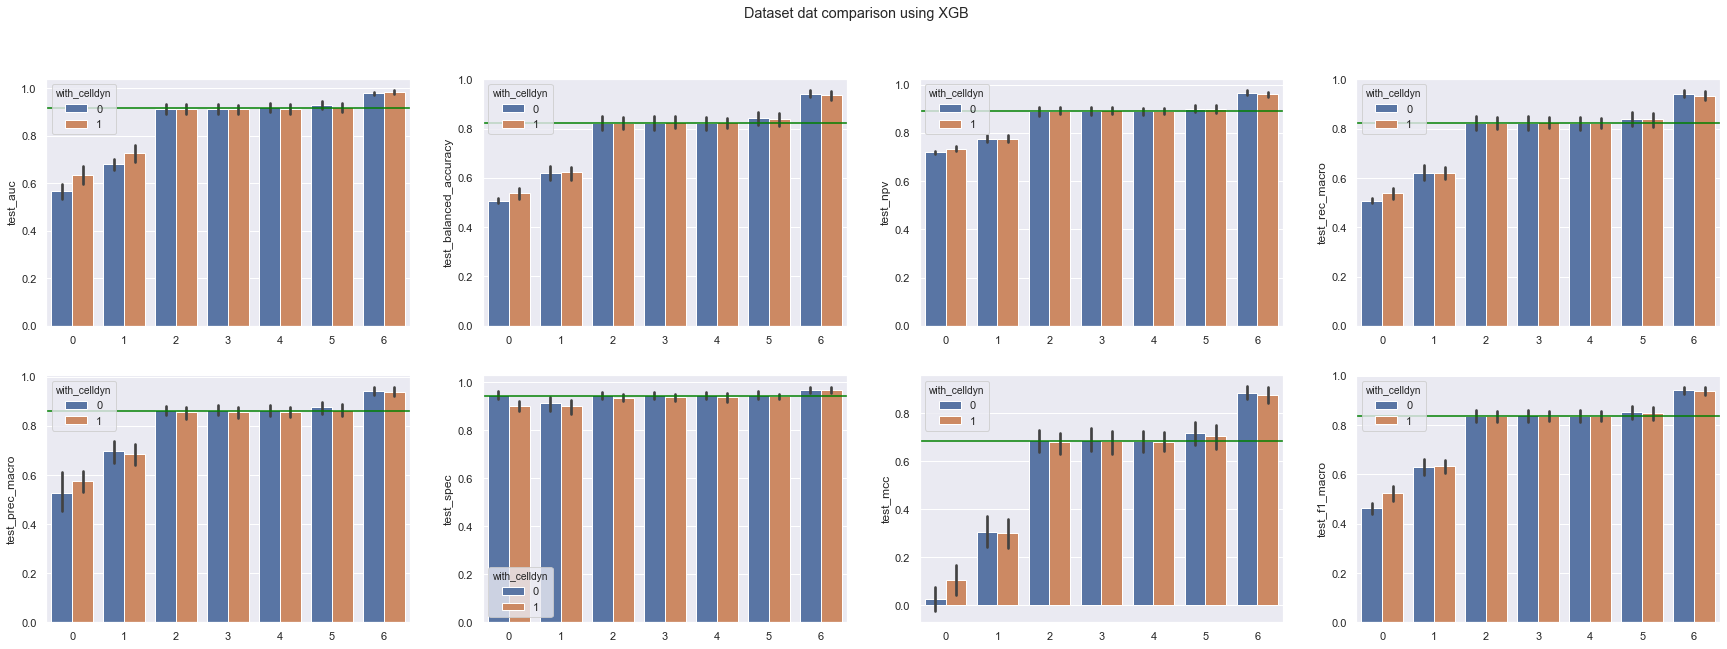

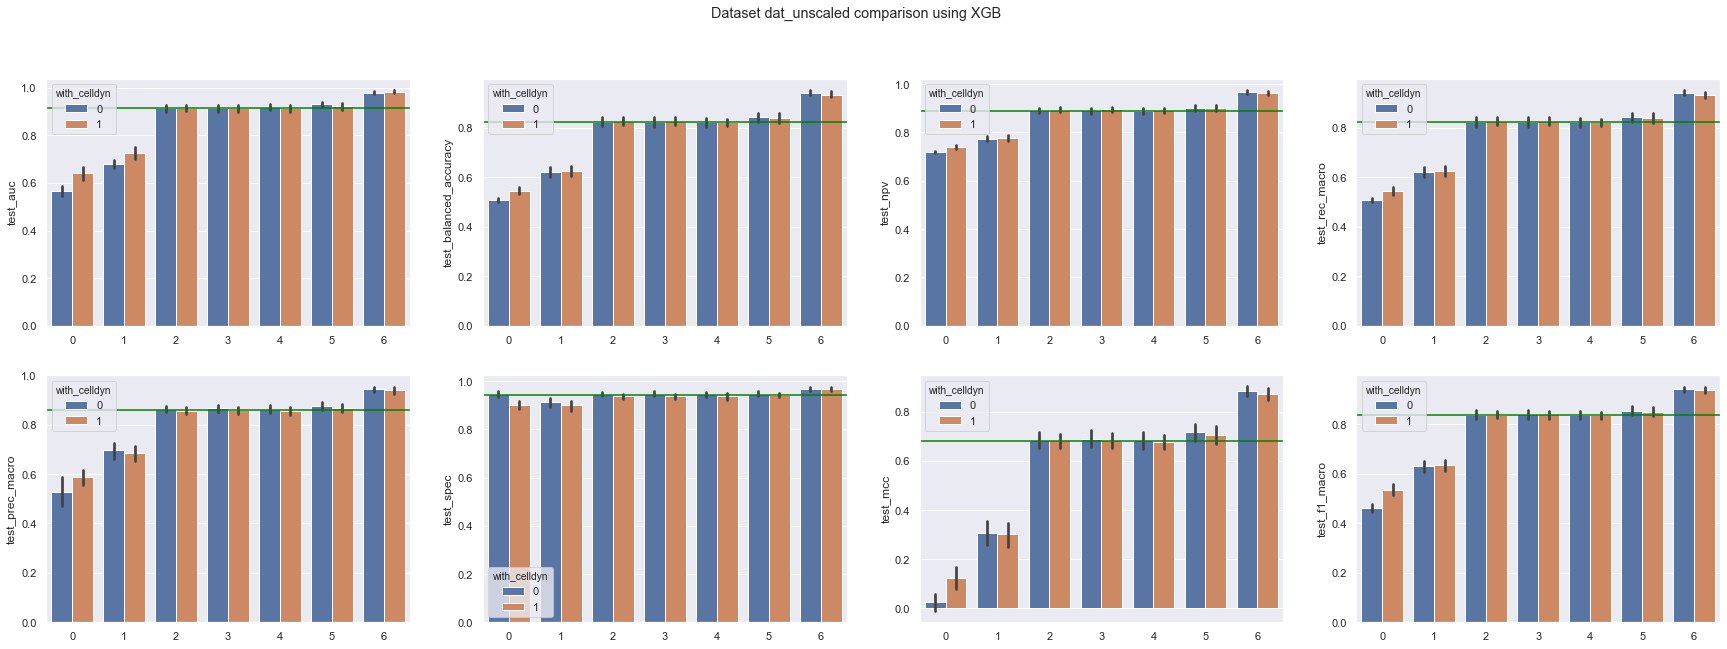

In [518]:
if make_simple_featureset_comparison:
    # use XGB with different datasets for a similar plot
    gc.collect()
    xgb_mod = XGB(n_estimators=250, n_jobs=8, max_depth=2)
    ds_scores = []
    ds_scores_tot = dict()
    num_folds = 10
    
    for _dat in [dat, dat_unscaled]:
        for dkey, fval in feature_set.items():
            for ckey, cols in fval.items():
                print("--- {} ---".format(cols))
                _cols = [__column for _key in cols for __column in col_dict[_key]]
                print("Processing dataset: {}".format(dkey+"_"+ckey))
                _ds_scores = pd.DataFrame(cross_validate(xgb_mod, _dat[_cols].values, y.values, 
                                                                      scoring=scoring, 
                                                                      cv=num_folds, return_train_score=True, 
                                                      return_estimator=False))
                _ds_scores['with_celldyn'] = 1 if ckey=='_withCelldyn' else 0
                _ds_scores['featureset'] = dkey
                ds_scores.append(_ds_scores)
                
        ds_scores_df = pd.concat(ds_scores)

        fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(30, 10))

        sns.barplot(data=ds_scores_df, x='featureset', y='test_auc', hue='with_celldyn', ax=ax[0,0])
        ax[0,0].axhline(ds_scores_df.loc[ds_scores_df['featureset']=='4', 'test_auc'].values.mean(), color='green')

        sns.barplot(data=ds_scores_df, x='featureset', y='test_balanced_accuracy', ax=ax[0,1], hue='with_celldyn')
        ax[0,1].axhline(ds_scores_df.loc[ds_scores_df['featureset']=='4', 'test_balanced_accuracy'].values.mean(), color='green')

        sns.barplot(data=ds_scores_df, x='featureset', y='test_npv', ax=ax[0,2], hue='with_celldyn')
        ax[0,2].axhline(ds_scores_df.loc[ds_scores_df['featureset']=='4', 'test_npv'].values.mean(), color='green')

        sns.barplot(data=ds_scores_df, x='featureset', y='test_rec_macro', ax=ax[0,3], hue='with_celldyn')
        ax[0,3].axhline(ds_scores_df.loc[ds_scores_df['featureset']=='4', 'test_rec_macro'].values.mean(), color='green')

        ax[0,0].set_xlabel('')
        ax[0,1].set_xlabel('')
        ax[0,2].set_xlabel('')
        ax[0,3].set_xlabel('')

        sns.barplot(data=ds_scores_df, x='featureset', y='test_prec_macro', hue='with_celldyn', ax=ax[1,0])
        ax[1,0].axhline(ds_scores_df.loc[ds_scores_df['featureset']=='4', 'test_prec_macro'].values.mean(), color='green')

        sns.barplot(data=ds_scores_df, x='featureset', y='test_spec', ax=ax[1,1], hue='with_celldyn')
        ax[1,1].axhline(ds_scores_df.loc[ds_scores_df['featureset']=='4', 'test_spec'].values.mean(), color='green')

        sns.barplot(data=ds_scores_df, x='featureset', y='test_mcc', ax=ax[1,2], hue='with_celldyn')
        ax[1,2].axhline(ds_scores_df.loc[ds_scores_df['featureset']=='4', 'test_mcc'].values.mean(), color='green')

        sns.barplot(data=ds_scores_df, x='featureset', y='test_f1_macro', ax=ax[1,3], hue='with_celldyn')
        ax[1,3].axhline(ds_scores_df.loc[ds_scores_df['featureset']=='4', 'test_f1_macro'].values.mean(), color='green')

        ax[1,0].set_xlabel('')
        ax[1,1].set_xlabel('')
        ax[1,2].set_xlabel('')
        ax[1,3].set_xlabel('')
        dat_name = retrieve_name(_dat)[0]
        fig.suptitle("Dataset {} comparison using XGB".format(dat_name))
        
        ds_scores_tot[dat_name] = ds_scores_df
        
        ds_scores_df.to_csv("/laupodteam/AIOS/Bram/data/HeartScore/xgb_compare_scores_data_"+dat_name+".csv", sep=";", index=False)



Sets 0 and 1 Ks_2sampResult(statistic=0.275, pvalue=0.09707484379785862)
Sets 2,3,4,5,6,7 Ks_2sampResult(statistic=0.14, pvalue=0.2819416298082479)


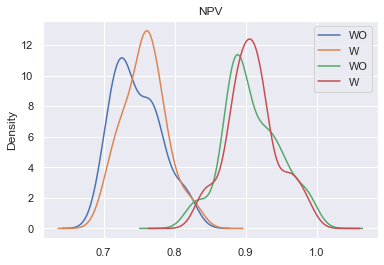

In [519]:
if make_simple_featureset_comparison:
    scores = ds_scores_tot['dat_unscaled']
    d1 = scores[(scores.featureset.isin(['0', '1'])) & (scores.with_celldyn==0)].test_npv
    d2 = scores[(scores.featureset.isin(['0', '1'])) & (scores.with_celldyn==1)].test_npv
    d1.plot.kde(label="WO")
    d2.plot.kde(label="W")
    print("Sets 0 and 1", ks2(d1,d2))

    d1 = scores[(scores.featureset.isin(['2', '3', '4', '5', '6'])) & (scores.with_celldyn==0)].test_npv
    d2 = scores[(scores.featureset.isin(['2', '3', '4', '5', '6'])) & (scores.with_celldyn==1)].test_npv
    d1.plot.kde(label="WO")
    d2.plot.kde(label="W")
    plt.legend()
    plt.title("NPV")
    print("Sets 2,3,4,5,6,7", ks2(d1,d2))

In [521]:
gc.collect()
class_weights = {0: 1., 1: 1.}

scaler= None @ {'ecg': QuantileTransformer(n_quantiles=3 3, output_distribution='normal'), 'celldyn': QuantileTransformer(n_quantiles=33, output_distribution='normal')} # StandardScaler(), MinMaxScaler(), RobustScaler() or None
dim_red = None # {'celldyn': UMAP(n_components=32), 'ecg': UMAP(n_components=64)} # {'ecg': PCA(n_components=32), 'celldyn': PCA(n_components=64)} # dict with dimension reduction per data group, or one dim red for all, or None, methods: PCA, NMF, UMAP

calibrated = False
pre_scaled = False
make_plots = False
upsample  = SMOTE # SMOTE, SVMSMOTE, ADASYN, BorderlineSMOTE
n_splits=10

sss = StratifiedShuffleSplit(n_splits=n_splits, test_size=0.1, random_state=323)
clfs = [('XGB1', XGB(n_estimators=300, max_depth=2, tree_method='approx', n_jobs=8)), # base_score=0.5, scale_pos_weight=1, tree_method(exact/approx/hist)
        ('XGB2', XGB(n_estimators=300, max_depth=3, tree_method='hist', n_jobs=8)),
        ('LGBM1', LGBM(n_estimators=300, max_depth=2, boosting='dart', n_jobs=8)),  # boosting(dart/gbdt/goss)
        ('LGBM2', LGBM(n_estimators=300, max_depth=3, boosting='gbdt', n_jobs=8)),
        ('CATB', CATB(n_estimators=300, max_depth=3, boosting_type='Ordered', thread_count=8, verbose=0)),
        ('NGB', NGBClassifier(n_estimators=300, verbose=0, Dist=Bernoulli))]
'''
        ('RF', RandomForestClassifier(n_estimators=400, max_depth=2, class_weight=class_weights, n_jobs=4)), 
        ('ET', ExtraTreesClassifier(n_estimators=500, max_depth=2, class_weight=class_weights, n_jobs=4)),
''' 

model_string ="_".join([_clf[0] for _clf in clfs])
model_weights  = [6, 4, 6, 4, 4, 5]


'''
loop to build X_train, X_test, y_train, y_test in case we have dimension reduction and/or scaling

'''


tdx = 0 
np.seterr(all='warn')
for dkey, fval in feature_set.items():
    print("+"*20, "Processing feature set:{}".format(dkey))
    for ckey, cols in fval.items():
        print("-"*40, "Processing {}".format(ckey))        
        _cols = [__column for _key in cols for __column in col_dict[_key]]
        if pre_scaled:
            X = dat[_cols].values
        else:
            X = dat_unscaled[_cols].values
        
        results = []
        # we loop through the split generator, get predictions, place the scores in the dictionary and add the y_pred.
        for idx, ind_tuple in enumerate(sss.split(X, y)):
            print(70*"-","Processing fold {} from {} folds".format(idx+1, n_splits))
            train_ind, test_ind = ind_tuple

            X_train, X_test = X[train_ind], X[test_ind]
            y_train, y_test = y[train_ind], y[test_ind]
            
            
            if scaler is not None:
                #print("Applying the scaler...")
                if isinstance(scaler, dict):        
                    for _imp_key, _scaler in scaler.items():
                        if (_scaler is not None) & (_imp_key in cols):
                            __cols = col_dict[_imp_key]
                            col_idcs = [dat_unscaled[_cols].columns.get_loc(c) for c in __cols if c in dat_unscaled[_cols].columns.tolist()]
                            X_train[:, col_idcs] = _scaler.fit_transform(X_train[:, col_idcs])
                            X_test[:, col_idcs] = _scaler.transform(X_test[:, col_idcs])
                else:   
                    if ('ecg' in cols) & ('celldyn' in cols):
                        __cols = col_dict['ecg']+col_dict['celldyn']
                        col_idcs = [dat_unscaled[_cols].columns.get_loc(c) for c in __cols if c in dat_unscaled[_cols].columns.tolist()]
                        X_train[:, col_idcs ] = _scaler.fit_transform(X_train[:, col_idcs])
                        X_test[:, col_idcs] = _scaler.transform(X_test[:, col_idcs])
            
            if upsample is not None:
                #print("Upsampling the minority class...")
                if 'SMOTE' in upsample.__name__:
                    sm = upsample(sampling_strategy='minority', random_state=321, k_neighbors=5)
                elif upsample.__name__ == 'ADASYN':
                    sm = upsample(sampling_strategy='minority', random_state=321)
                X_train, y_train= sm.fit_sample(X_train, y_train)
            
            if dim_red is not None:
                if isinstance(dim_red, str):
                    if dim_red == 'PCA':
                        reducer = PCA(n_components=dims)
                        reducer.fit(X_train)
                        X_train = reducer.transform(X_train)
                        X_test = reducer.transform(X_test)
                    elif dim_red == 'UMAP':
                        reducer = UMAP(n_components=dims)
                        reducer.fit(X_train, y_train)
                        X_train = reducer.transform(X_train)
                        X_test = reducer.transform(X_test)
                    elif dim_red == 'KPCA':
                        reducer = KernelPCA(kernel="rbf", gamma=15, n_components=1)
                        reducer.fit(X_train, y_train)
                        X_train = reducer.transform(X_train)
                        X_test = reducer.transform(X_test)
                elif isinstance(dim_red, dict):
                    # each key in the dict should be in the col_dict
                    sup_idcs = []
                    for k, reducer in dim_red.items():
                        if k in cols:
                            #print("Reducing dimensionality of {} data".format(k))
                            __cols = col_dict[k]
                            col_idcs = [dat_unscaled[_cols].columns.get_loc(c) for c in __cols if c in dat_unscaled[_cols].columns.tolist()]
                            sup_idcs.append(col_idcs)
                            reducer.fit(X_train[:, col_idcs], y_train)                            
                            X_train_red = reducer.transform(X_train[:, col_idcs])
                            X_test_red = reducer.transform(X_test[:, col_idcs])   
                            X_train = np.hstack((X_train, X_train_red))
                            X_test = np.hstack((X_test, X_test_red))
                    if len(sup_idcs)>0:
                        sup_idcs = np.hstack(sup_idcs)
                        X_train = np.delete(X_train, sup_idcs, axis=1)
                        X_test = np.delete(X_test, sup_idcs, axis=1)
                               
                else:
                    raise ValueError("dim_red should be a string or a dict..")
                
            # train model
            clf = VotingClassifier(clfs, voting='soft', weights=model_weights)
            if calibrated:
                clfc = CalibratedClassifierCV(clf, cv=3)
                clfc.fit(X_train, y_train)
                y_pred = clfc.predict_proba(X_test)
            else:
                clf.fit(X_train, y_train)
                y_pred = clf.predict_proba(X_test)
            results.append({'ypred': y_pred[:,1], 'ytest': y_test, 'dkey': dkey, 'ckey': ckey, 'models': model_string, 'split': idx})
            #print(70*"+","threshold 0.5\t=\tAUC: {}, NPV: {}, ACC: {}".format(metrics.roc_auc_score(y_test, y_pred[:, 1]), npv(y_test, y_pred[:, 1]), balanced_accuracy(y_test, y_pred[:, 1])))
            #print(70*"+","threshold 0.75\t=\tAUC: {}, NPV: {}, ACC: {}".format(metrics.roc_auc_score(y_test, y_pred[:, 1]), npv(y_test, y_pred[:, 1], thresh=0.75), balanced_accuracy(y_test, y_pred[:, 1], thresh=0.75)))
            
        all_results += results
        
        
        figax = plt.subplots(ncols=4, figsize=(30, 7)) if make_plots else None
            
        for idx, _res in enumerate(results):            
            try:
                metr, figax = get_accuracy_plots(_res['ytest'], _res['ypred'], figax=figax, make_plot=make_plots)
                metr['IDX'] = idx
                metr['model'] = model_string
                metr['featureset'] = dkey
                metr['with_celldyn'] = 1 if ckey=='_withCelldyn' else 0
            except Exception as e:
                print("The results must be pretty badddd :))): {}".format(e))
            accuracies = pd.concat([accuracies, metr]) if tdx>0 else metr
            tdx += 1
        if make_plots:
            figax[0].suptitle("Featureset:"+dkey+ckey)

++++++++++++++++++++ Processing feature set:0
---------------------------------------- Processing _withoutCelldyn
---------------------------------------------------------------------- Processing fold 1 from 10 folds
---------------------------------------------------------------------- Processing fold 2 from 10 folds
---------------------------------------------------------------------- Processing fold 3 from 10 folds
---------------------------------------------------------------------- Processing fold 4 from 10 folds
---------------------------------------------------------------------- Processing fold 5 from 10 folds
---------------------------------------------------------------------- Processing fold 6 from 10 folds
---------------------------------------------------------------------- Processing fold 7 from 10 folds
---------------------------------------------------------------------- Processing fold 8 from 10 folds
--------------------------------------------------------------

H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:299: RuntimeWarning: invalid value encountered in double_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:299: RuntimeWarning: invalid value encountered in double_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:299: RuntimeWarning: invalid value encountered in double_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:299: RuntimeWarning: invalid value encountered in double_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:299: RuntimeWarning: invalid value encountered in double_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:299: RuntimeWarning: invalid value encountered in double_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:299: RuntimeWarning: invalid value encountered in double_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:299: RuntimeWarning: invalid valu

---------------------------------------- Processing _withCelldyn
---------------------------------------------------------------------- Processing fold 1 from 10 folds
---------------------------------------------------------------------- Processing fold 2 from 10 folds
---------------------------------------------------------------------- Processing fold 3 from 10 folds
---------------------------------------------------------------------- Processing fold 4 from 10 folds
---------------------------------------------------------------------- Processing fold 5 from 10 folds
---------------------------------------------------------------------- Processing fold 6 from 10 folds
---------------------------------------------------------------------- Processing fold 7 from 10 folds
---------------------------------------------------------------------- Processing fold 8 from 10 folds
---------------------------------------------------------------------- Processing fold 9 from 10 folds
--------

H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:299: RuntimeWarning: invalid value encountered in double_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:299: RuntimeWarning: invalid value encountered in double_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:299: RuntimeWarning: invalid value encountered in double_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:299: RuntimeWarning: invalid value encountered in double_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:299: RuntimeWarning: invalid value encountered in double_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:299: RuntimeWarning: invalid value encountered in double_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:299: RuntimeWarning: invalid value encountered in double_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:299: RuntimeWarning: invalid valu

++++++++++++++++++++ Processing feature set:1
---------------------------------------- Processing _withoutCelldyn
---------------------------------------------------------------------- Processing fold 1 from 10 folds
---------------------------------------------------------------------- Processing fold 2 from 10 folds
---------------------------------------------------------------------- Processing fold 3 from 10 folds
---------------------------------------------------------------------- Processing fold 4 from 10 folds
---------------------------------------------------------------------- Processing fold 5 from 10 folds
---------------------------------------------------------------------- Processing fold 6 from 10 folds
---------------------------------------------------------------------- Processing fold 7 from 10 folds
---------------------------------------------------------------------- Processing fold 8 from 10 folds
--------------------------------------------------------------

H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:299: RuntimeWarning: invalid value encountered in double_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:299: RuntimeWarning: invalid value encountered in double_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:299: RuntimeWarning: invalid value encountered in double_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:299: RuntimeWarning: invalid value encountered in double_scalars


---------------------------------------- Processing _withCelldyn
---------------------------------------------------------------------- Processing fold 1 from 10 folds
---------------------------------------------------------------------- Processing fold 2 from 10 folds
---------------------------------------------------------------------- Processing fold 3 from 10 folds
---------------------------------------------------------------------- Processing fold 4 from 10 folds
---------------------------------------------------------------------- Processing fold 5 from 10 folds
---------------------------------------------------------------------- Processing fold 6 from 10 folds
---------------------------------------------------------------------- Processing fold 7 from 10 folds
---------------------------------------------------------------------- Processing fold 8 from 10 folds
---------------------------------------------------------------------- Processing fold 9 from 10 folds
--------

H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:299: RuntimeWarning: invalid value encountered in double_scalars
H:\PythonVENV\Envs\base\lib\site-packages\ipykernel_launcher.py:299: RuntimeWarning: invalid value encountered in double_scalars


++++++++++++++++++++ Processing feature set:2
---------------------------------------- Processing _withoutCelldyn
---------------------------------------------------------------------- Processing fold 1 from 10 folds
---------------------------------------------------------------------- Processing fold 2 from 10 folds
---------------------------------------------------------------------- Processing fold 3 from 10 folds
---------------------------------------------------------------------- Processing fold 4 from 10 folds
---------------------------------------------------------------------- Processing fold 5 from 10 folds
---------------------------------------------------------------------- Processing fold 6 from 10 folds
---------------------------------------------------------------------- Processing fold 7 from 10 folds
---------------------------------------------------------------------- Processing fold 8 from 10 folds
--------------------------------------------------------------

AUC W: 0.9733928571428571, WO: 0.9653125


Text(0.5, 1.0, 'ROC')

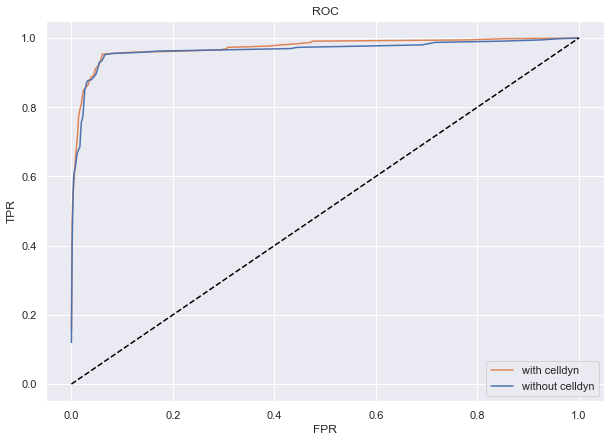

In [522]:
dkey = '6'
ytestW = []
ypredW = []

ytestWO = []
ypredWO = [] 
for _res in all_results:
    if (_res['dkey'] == dkey) & (_res['ckey']=='_withCelldyn'):
        ytestW.append(_res['ytest'])
        ypredW.append(_res['ypred'])
    elif (_res['dkey'] == dkey) & (_res['ckey']=='_withoutCelldyn'):
        ytestWO.append(_res['ytest'])
        ypredWO.append(_res['ypred']) 

TestW = pd.concat(ytestW)
PredW = np.hstack(ypredW)
TestWO = pd.concat(ytestWO)
PredWO = np.hstack(ypredWO)

print("AUC W: {}, WO: {}".format(metrics.roc_auc_score(TestW,PredW), metrics.roc_auc_score(TestWO, PredWO)))
fig, ax = plt.subplots(figsize=(10,7))
roc_curveW = pd.DataFrame(metrics.roc_curve(TestW, PredW)[:2]).transpose()
roc_curveW.columns = ['FPR', 'TPR']


roc_curveWO = pd.DataFrame(metrics.roc_curve(TestWO, PredWO)[:2]).transpose()
roc_curveWO.columns = ['FPR', 'TPR']

sns.lineplot(data=roc_curveW, x='FPR', y='TPR', ax=ax, label='with celldyn', color=(0.8666666666666667, 0.5176470588235295, 0.3215686274509804), ci=None)
sns.lineplot(data=roc_curveWO, x='FPR', y='TPR', ax=ax, label='without celldyn', color=(0.2980392156862745, 0.4470588235294118, 0.6901960784313725), ci=None)
ax.plot(np.array([0,1]), np.array([0,1]), ls="--", c="black")
ax.set_title("ROC")

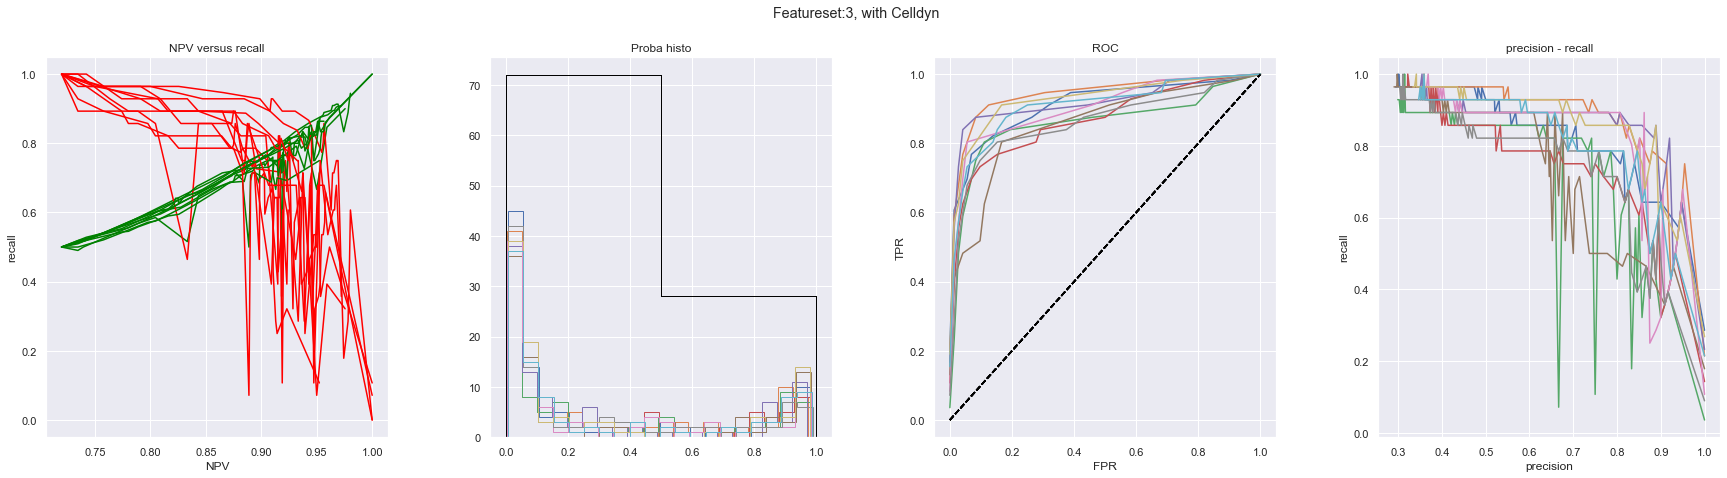

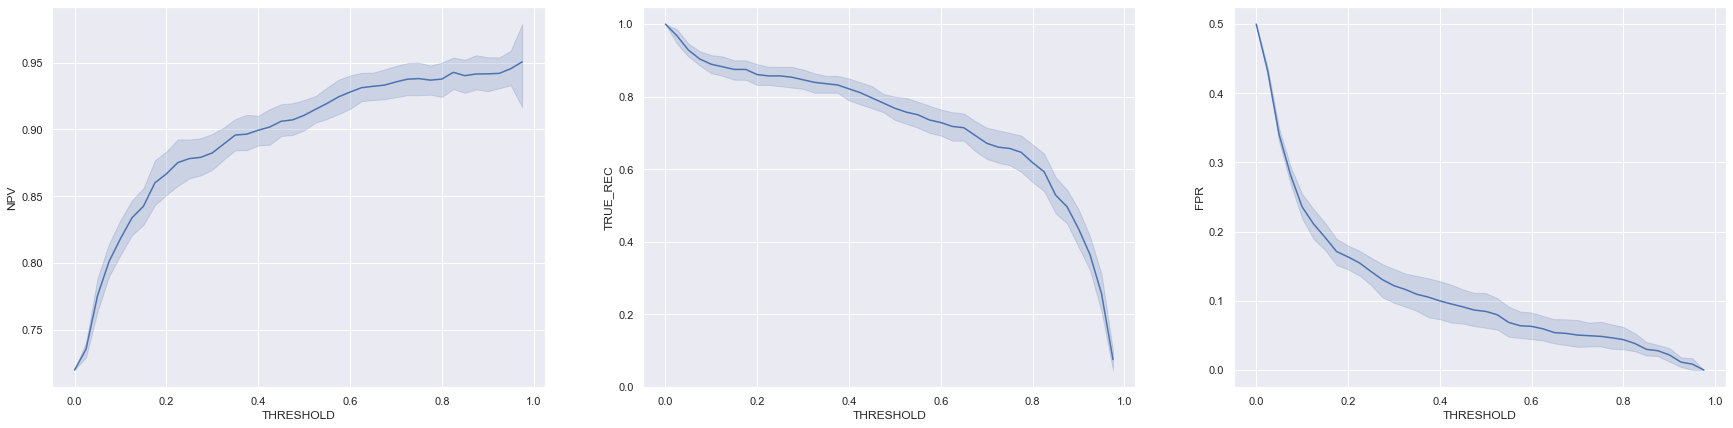

In [523]:
ds = "3"
withCelldyn = "_withoutCelldyn"
plots = True
cont_acc=False
#del accuracies_tmp
k = 0
if plots:
    figax = plt.subplots(ncols=4, figsize=(30, 7))
for idx, rd in enumerate(all_results):
    if (rd['dkey']==ds) & (rd['ckey']==withCelldyn):
        try:            
            metr, figax = get_accuracy_plots(rd['ytest'], rd['ypred'], figax=figax, make_plot=plots)
            metr['IDX'] = idx
            metr['model'] = rd['models']
            metr['featureset'] = rd['dkey']
            metr['with_celldyn'] = 1 if rd['ckey']=='_withCelldyn' else 0            
        except Exception as e:
            print("The results must be pretty badddd :))): {}".format(e))
        accuracies_tmp = pd.concat([accuracies_tmp, metr]) if (k>0) or (cont_acc==True) else metr
        k += 1
figax[0].suptitle("Featureset:"+ds+", with Celldyn")

fig, ax = plt.subplots(ncols=3, figsize=(30, 7))
sns.lineplot(data=accuracies_tmp, x='THRESHOLD', y="NPV", ax=ax[0])
sns.lineplot(data=accuracies_tmp, x='THRESHOLD', y="TRUE_REC", ax=ax[1])
sns.lineplot(data=accuracies_tmp, x='THRESHOLD', y="FPR", ax=ax[2])

In [524]:
accuracies['SPEC'] = 1-accuracies['FPR']
#accuracies['NPV'].replace(to_replace=0, value=np.nan, inplace=True)
#accuracies['FPR'].replace(to_replace=0, value=np.nan, inplace=True)
#accuracies['REC'].replace(to_replace=0, value=np.nan, inplace=True)
#accuracies['TRUE_REC'].replace(to_replace=0, value=np.nan, inplace=True)

out_df=prep_accs(accuracies)
out_df.sort_values(by=["featureset", "threshold_minimum"], inplace=True)
out_df.drop(['THRESHOLD', 'IDX'], axis=1, inplace=True)
out_df.to_csv("/laupodteam/AIOS/Bram/data/HeartScore/acc_ensemble1.csv", sep=";", index=False)
accuracies.to_csv("/laupodteam/AIOS/Bram/data/HeartScore/raw_accuracies_ensemble1.csv", sep=";", index=False)

Text(0.5, 0.98, 'Over all featuresets, per threshold')

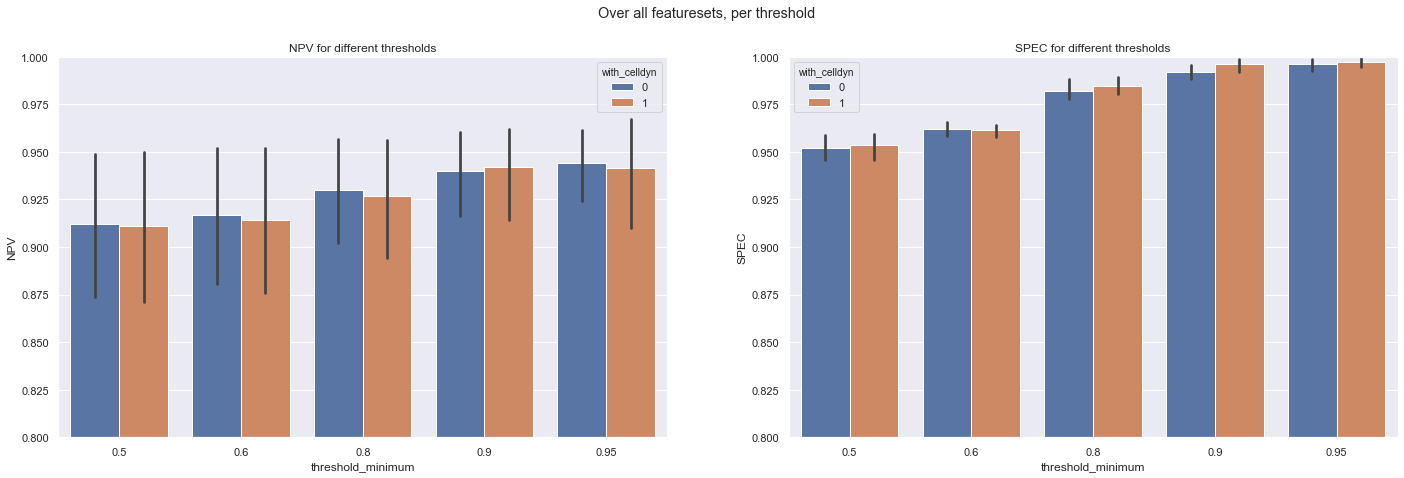

In [525]:
fig, ax = plt.subplots(ncols=2, figsize=(24,7))
sns.barplot(data=out_df, x='threshold_minimum', y='NPV', hue='with_celldyn', ax=ax[0])
sns.barplot(data=out_df, x='threshold_minimum', y='SPEC', hue='with_celldyn', ax=ax[1])
ax[0].set_ylim(0.80,1.0)
ax[1].set_ylim(0.80,1.0)
ax[0].set_title("NPV for different thresholds")
ax[1].set_title("SPEC for different thresholds")
fig.suptitle("Over all featuresets, per threshold")

Text(0.5, 0.98, 'Over all thresholds, per feature set')

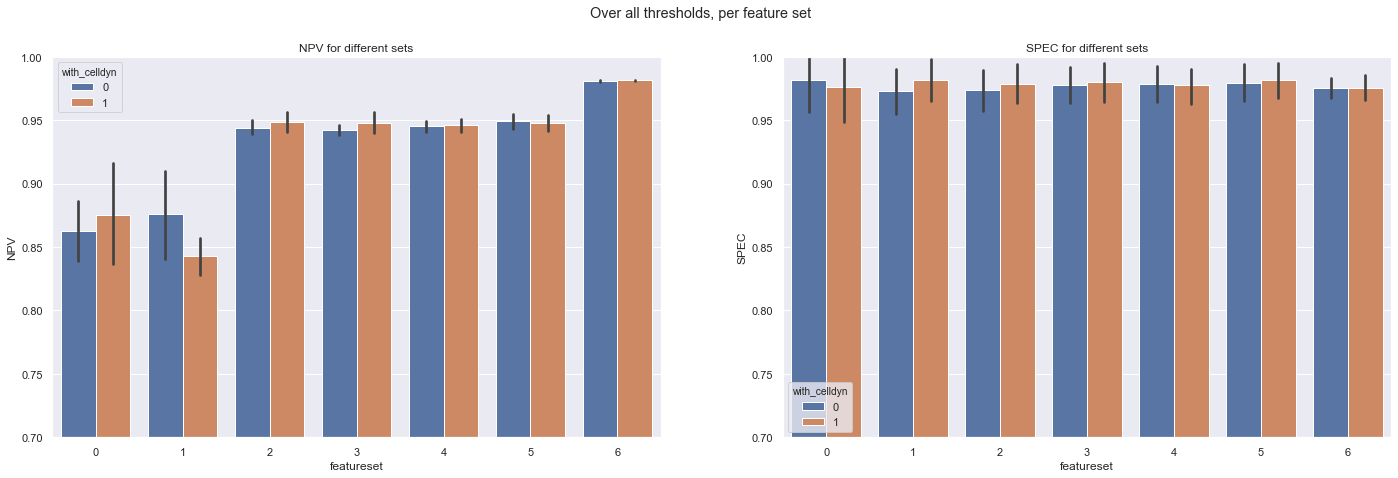

In [526]:
fig, ax = plt.subplots(ncols=2, figsize=(24,7))
sns.barplot(data=out_df, x='featureset', y='NPV', hue='with_celldyn', ax=ax[0])
sns.barplot(data=out_df, x='featureset', y='SPEC', hue='with_celldyn', ax=ax[1])
ax[0].set_title("NPV for different sets")
ax[1].set_title("SPEC for different sets")
ax[0].set_ylim(0.7,1.0)
ax[1].set_ylim(0.7,1.0)
fig.suptitle("Over all thresholds, per feature set")

Text(0.5, 1.0, 'Performance metrics with/without CELLDYN, set: 0')

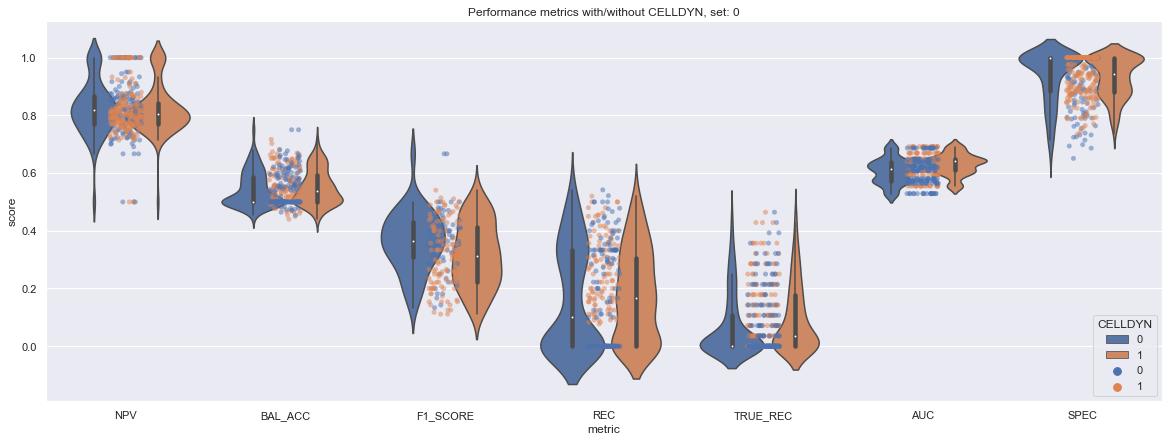

In [527]:
setString='0'
order_dict = {'NPV': 1, 'BAL_ACC': 2 ,'F1_SCORE' : 3, 'REC' : 4, 'TRUE_REC' : 5, 'FPR' : 6, 'AUC' : 7}# just to change the order so that NPV is first
accuracies_melted = pd.melt(accuracies[(accuracies.THRESHOLD>0.5) & (accuracies.featureset.isin(setString.split(",")))],
                            value_vars=['BAL_ACC' ,'F1_SCORE', 'NPV', 'REC', 'TRUE_REC', 'SPEC', 'AUC'], 
                            id_vars=['with_celldyn', 'IDX'], 
                            var_name='metric', 
                            value_name='score')
accuracies_melted['order'] =accuracies_melted['metric'].map(order_dict)
accuracies_melted.sort_values(by='order', inplace=True)

fig, ax = plt.subplots(figsize=(20,7))
sns.violinplot(data=accuracies_melted, x='metric', y='score', hue='with_celldyn', k_depth="tukey", ax=ax) 
sns.stripplot(data=accuracies_melted, x='metric', y='score', hue='with_celldyn', alpha=0.5, ax=ax)
#ax.set_xticklabels(order_dict.keys())

plt.legend(title='CELLDYN', loc=4)
plt.title("Performance metrics with/without CELLDYN, set: "+setString)
#ax.axhline(0.95, color='black')

H:\PythonVENV\Envs\base\lib\site-packages\scipy\stats\kde.py:255: RuntimeWarning: underflow encountered in exp
  result += self.weights[i]*exp(-energy)
H:\PythonVENV\Envs\base\lib\site-packages\scipy\stats\kde.py:255: RuntimeWarning: underflow encountered in multiply
  result += self.weights[i]*exp(-energy)


Text(0.5, 0.98, 'Comparison of scores between featuresets, with/without celldyn, sets 1,2,3,4')

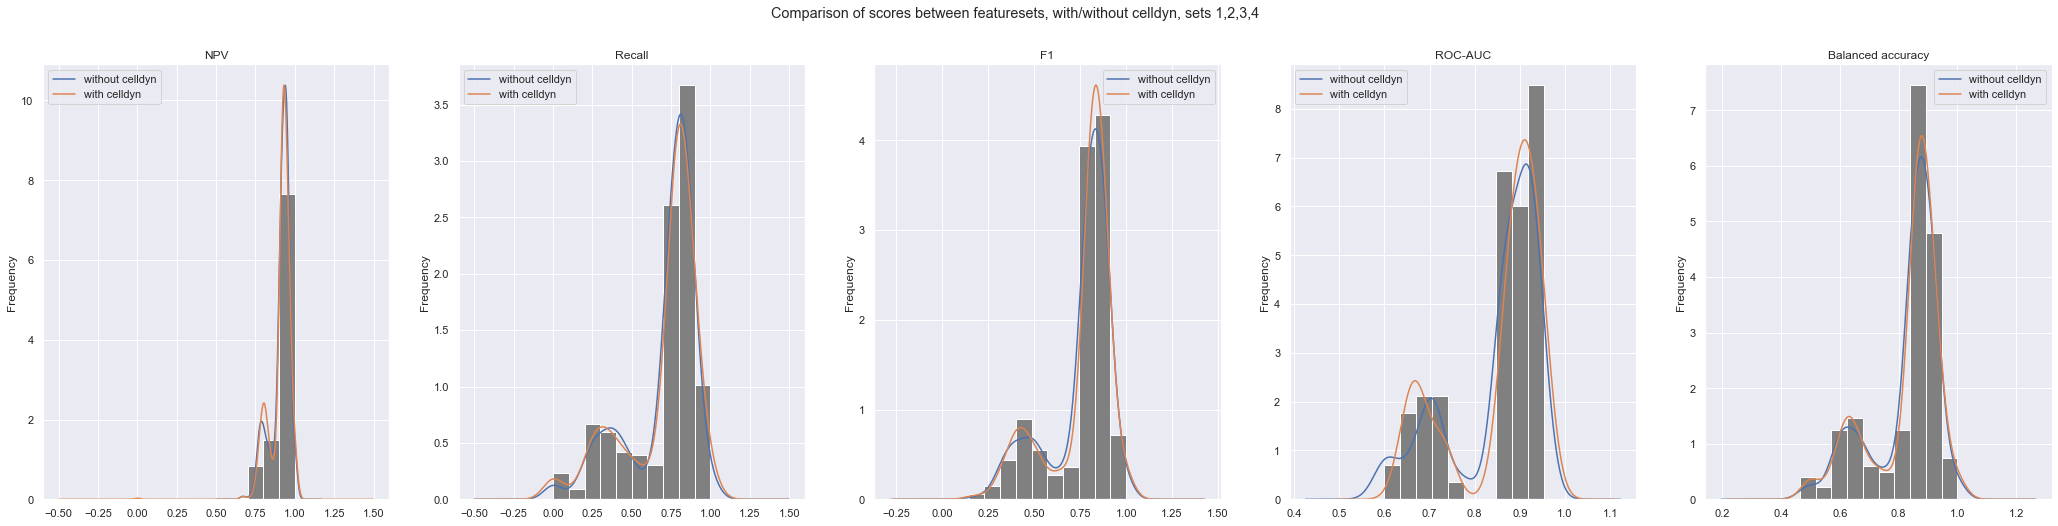

In [528]:
fig, ax = plt.subplots(ncols=5, figsize=(36, 8))
setString='1,2,3,4'
accuracies[(accuracies.with_celldyn==0) & (accuracies.THRESHOLD>0.50) & (accuracies.featureset.isin(setString.split(",")))].NPV.plot.kde(label='without celldyn', ax=ax[0])
accuracies[(accuracies.with_celldyn==1) & (accuracies.THRESHOLD>0.50) & (accuracies.featureset.isin(setString.split(",")))].NPV.plot.kde(label='with celldyn', ax=ax[0])
accuracies[(accuracies.THRESHOLD>0.50) & (accuracies.featureset.isin(setString.split(",")))].NPV.plot.hist(color='grey', label='', density=True, ax=ax[0])
ax[0].legend()
ax[0].set_title('NPV')

accuracies[(accuracies.with_celldyn==0) & (accuracies.THRESHOLD>0.50) & (accuracies.featureset.isin(setString.split(",")))].REC.plot.kde(label='without celldyn', ax=ax[1])
accuracies[(accuracies.with_celldyn==1) & (accuracies.THRESHOLD>0.50) & (accuracies.featureset.isin(setString.split(",")))].REC.plot.kde(label='with celldyn', ax=ax[1])
accuracies[(accuracies.THRESHOLD>0.50) & (accuracies.featureset.isin(setString.split(",")))].REC.plot.hist(color='grey', label='', density=True, ax=ax[1])
ax[1].legend()
ax[1].set_title('Recall')

accuracies[(accuracies.with_celldyn==0) & (accuracies.THRESHOLD>0.50) & (accuracies.featureset.isin(setString.split(",")))].F1_SCORE.plot.kde(label='without celldyn', ax=ax[2])
accuracies[(accuracies.with_celldyn==1) & (accuracies.THRESHOLD>0.50) & (accuracies.featureset.isin(setString.split(",")))].F1_SCORE.plot.kde(label='with celldyn', ax=ax[2])
accuracies[(accuracies.THRESHOLD>0.50) & (accuracies.featureset.isin(setString.split(",")))].F1_SCORE.plot.hist(color='grey', label='', density=True, ax=ax[2])

ax[2].legend()
ax[2].set_title('F1')

accuracies[(accuracies.with_celldyn==0) & (accuracies.THRESHOLD>0.50) & (accuracies.featureset.isin(setString.split(",")))].AUC.plot.kde(label='without celldyn', ax=ax[3])
accuracies[(accuracies.with_celldyn==1) & (accuracies.THRESHOLD>0.50) & (accuracies.featureset.isin(setString.split(",")))].AUC.plot.kde(label='with celldyn', ax=ax[3])
accuracies[(accuracies.THRESHOLD>0.50) & (accuracies.featureset.isin(setString.split(",")))].AUC.plot.hist(color='grey', label='', density=True, ax=ax[3])
ax[3].legend()
ax[3].set_title('ROC-AUC')

accuracies[(accuracies.with_celldyn==0) & (accuracies.THRESHOLD>0.50) & (accuracies.featureset.isin(setString.split(",")))].BAL_ACC.plot.kde(label='without celldyn', ax=ax[4])
accuracies[(accuracies.with_celldyn==1) & (accuracies.THRESHOLD>0.50) & (accuracies.featureset.isin(setString.split(",")))].BAL_ACC.plot.kde(label='with celldyn', ax=ax[4])
accuracies[(accuracies.THRESHOLD>0.50) & (accuracies.featureset.isin(setString.split(",")))].BAL_ACC.plot.hist(color='grey', label='', density=True, ax=ax[4])
ax[4].legend()
ax[4].set_title('Balanced accuracy')

fig.suptitle("Comparison of scores between featuresets, with/without celldyn, sets "+setString)

In [529]:
thres=0.5
csets = ["1", "2", "3", "4"]
d1 = accuracies[(accuracies.featureset.isin(csets)) & (accuracies.with_celldyn==0) & (accuracies.THRESHOLD>thres)].NPV
d2 = accuracies[(accuracies.featureset.isin(csets)) & (accuracies.with_celldyn==1) & (accuracies.THRESHOLD>thres)].NPV
r1 = accuracies[(accuracies.featureset.isin(csets)) & (accuracies.with_celldyn==0) & (accuracies.THRESHOLD>thres)].TRUE_REC
r2 = accuracies[(accuracies.featureset.isin(csets)) & (accuracies.with_celldyn==1) & (accuracies.THRESHOLD>thres)].TRUE_REC
print(thres, d1.mean(), d2.mean(), r1.mean(), r2.mean(), ks2(d1,d2)[1])

thres=0.6
d1 = accuracies[(accuracies.featureset.isin(csets)) & (accuracies.with_celldyn==0) & (accuracies.THRESHOLD>thres)].NPV
d2 = accuracies[(accuracies.featureset.isin(csets)) & (accuracies.with_celldyn==1) & (accuracies.THRESHOLD>thres)].NPV
r1 = accuracies[(accuracies.featureset.isin(csets)) & (accuracies.with_celldyn==0) & (accuracies.THRESHOLD>thres)].TRUE_REC
r2 = accuracies[(accuracies.featureset.isin(csets)) & (accuracies.with_celldyn==1) & (accuracies.THRESHOLD>thres)].TRUE_REC
print(thres, d1.mean(), d2.mean(), r1.mean(), r2.mean(), ks2(d1,d2)[1])

thres=0.7
d1 = accuracies[(accuracies.featureset.isin(csets)) & (accuracies.with_celldyn==0) & (accuracies.THRESHOLD>thres)].NPV
d2 = accuracies[(accuracies.featureset.isin(csets)) & (accuracies.with_celldyn==1) & (accuracies.THRESHOLD>thres)].NPV
r1 = accuracies[(accuracies.featureset.isin(csets)) & (accuracies.with_celldyn==0) & (accuracies.THRESHOLD>thres)].TRUE_REC
r2 = accuracies[(accuracies.featureset.isin(csets)) & (accuracies.with_celldyn==1) & (accuracies.THRESHOLD>thres)].TRUE_REC
print(thres, d1.mean(), d2.mean(), r1.mean(), r2.mean(), ks2(d1,d2)[1])

thres=0.8
d1 = accuracies[(accuracies.featureset.isin(csets)) & (accuracies.with_celldyn==0) & (accuracies.THRESHOLD>thres)].NPV
d2 = accuracies[(accuracies.featureset.isin(csets)) & (accuracies.with_celldyn==1) & (accuracies.THRESHOLD>thres)].NPV
r1 = accuracies[(accuracies.featureset.isin(csets)) & (accuracies.with_celldyn==0) & (accuracies.THRESHOLD>thres)].TRUE_REC
r2 = accuracies[(accuracies.featureset.isin(csets)) & (accuracies.with_celldyn==1) & (accuracies.THRESHOLD>thres)].TRUE_REC
print(thres, d1.mean(), d2.mean(),  r1.mean(), r2.mean(), ks2(d1,d2)[1])

thres=0.9
d1 = accuracies[(accuracies.featureset.isin(csets)) & (accuracies.with_celldyn==0) & (accuracies.THRESHOLD>thres)].NPV
d2 = accuracies[(accuracies.featureset.isin(csets)) & (accuracies.with_celldyn==1) & (accuracies.THRESHOLD>thres)].NPV
r1 = accuracies[(accuracies.featureset.isin(csets)) & (accuracies.with_celldyn==0) & (accuracies.THRESHOLD>thres)].TRUE_REC
r2 = accuracies[(accuracies.featureset.isin(csets)) & (accuracies.with_celldyn==1) & (accuracies.THRESHOLD>thres)].TRUE_REC
print(thres, d1.mean(), d2.mean(),  r1.mean(), r2.mean(), ks2(d1,d2)[1])

thres=0.95
d1 = accuracies[(accuracies.featureset.isin(csets)) & (accuracies.with_celldyn==0) & (accuracies.THRESHOLD>thres)].NPV
d2 = accuracies[(accuracies.featureset.isin(csets)) & (accuracies.with_celldyn==1) & (accuracies.THRESHOLD>thres)].NPV
r1 = accuracies[(accuracies.featureset.isin(csets)) & (accuracies.with_celldyn==0) & (accuracies.THRESHOLD>thres)].TRUE_REC
r2 = accuracies[(accuracies.featureset.isin(csets)) & (accuracies.with_celldyn==1) & (accuracies.THRESHOLD>thres)].TRUE_REC
print(thres, d1.mean(), d2.mean(),  r1.mean(), r2.mean(), ks2(d1,d2)[1])

0.5 0.910776364914719 0.9094263052309697 0.4795112781954887 0.5059680451127819 0.04961384585029881
0.6 0.915413662322932 0.9124020228260115 0.4479352678571429 0.47276785714285713 0.09710291282992185
0.7 0.9210642838829781 0.9165441457944721 0.39866071428571426 0.4181547619047619 0.26963878458388796
0.8 0.9294533588337297 0.9232374322850664 0.30497448979591835 0.3252551020408163 0.25541286258739365
0.9 0.942229772215153 0.9346145220269123 0.1732142857142857 0.1949404761904762 0.5879759185183517
0.95 0.9462019762004863 0.9376249954162252 0.12232142857142855 0.13794642857142855 0.9793613278485205


++++++++++++++++++++ Processing feature set:0
---------------------------------------- Processing _withoutCelldyn
------------------------------ Processing fold 1 from 10 folds
Less then 10 dimensions, we are using a simple logistic regression for this one
Less then 10 dimensions, we are using a simple logistic regression for this one
------------------------------ Processing fold 2 from 10 folds
Less then 10 dimensions, we are using a simple logistic regression for this one
Less then 10 dimensions, we are using a simple logistic regression for this one
------------------------------ Processing fold 3 from 10 folds
Less then 10 dimensions, we are using a simple logistic regression for this one
Less then 10 dimensions, we are using a simple logistic regression for this one
------------------------------ Processing fold 4 from 10 folds
Less then 10 dimensions, we are using a simple logistic regression for this one
Less then 10 dimensions, we are using a simple logistic regression for thi

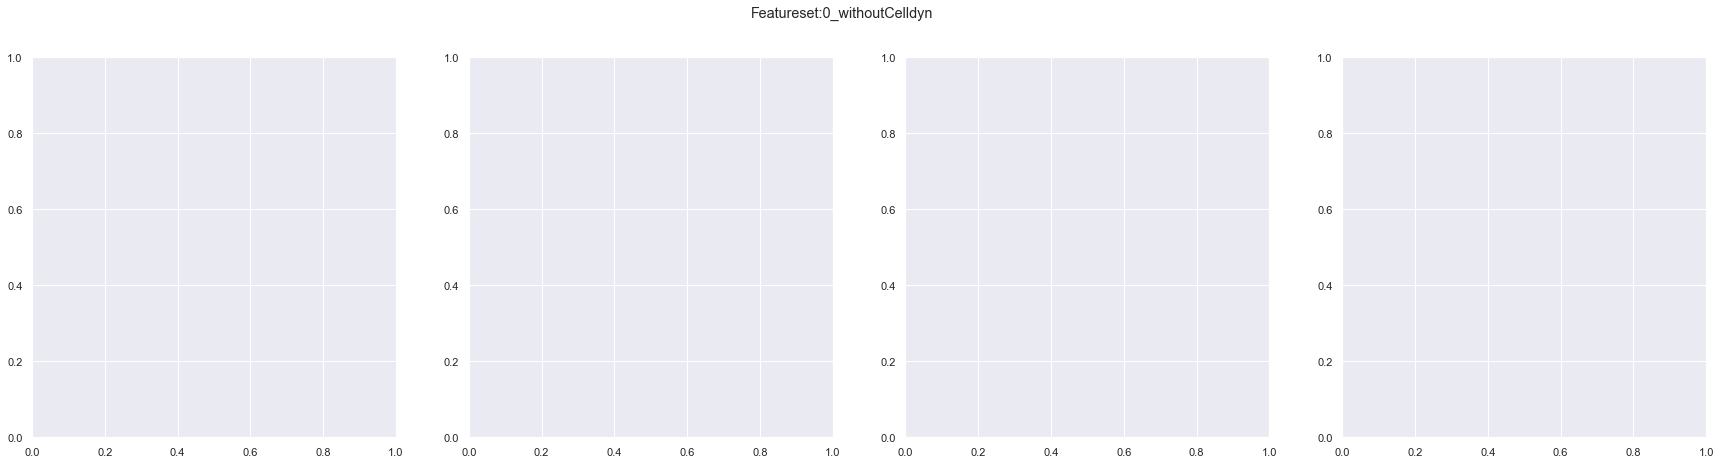

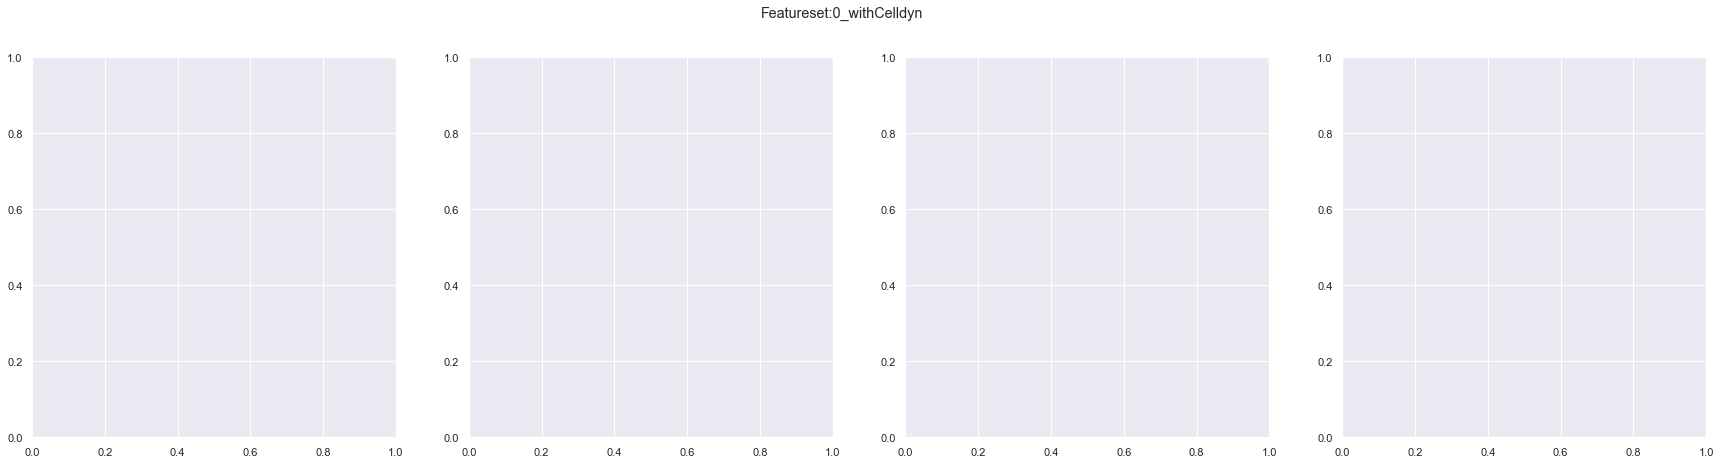

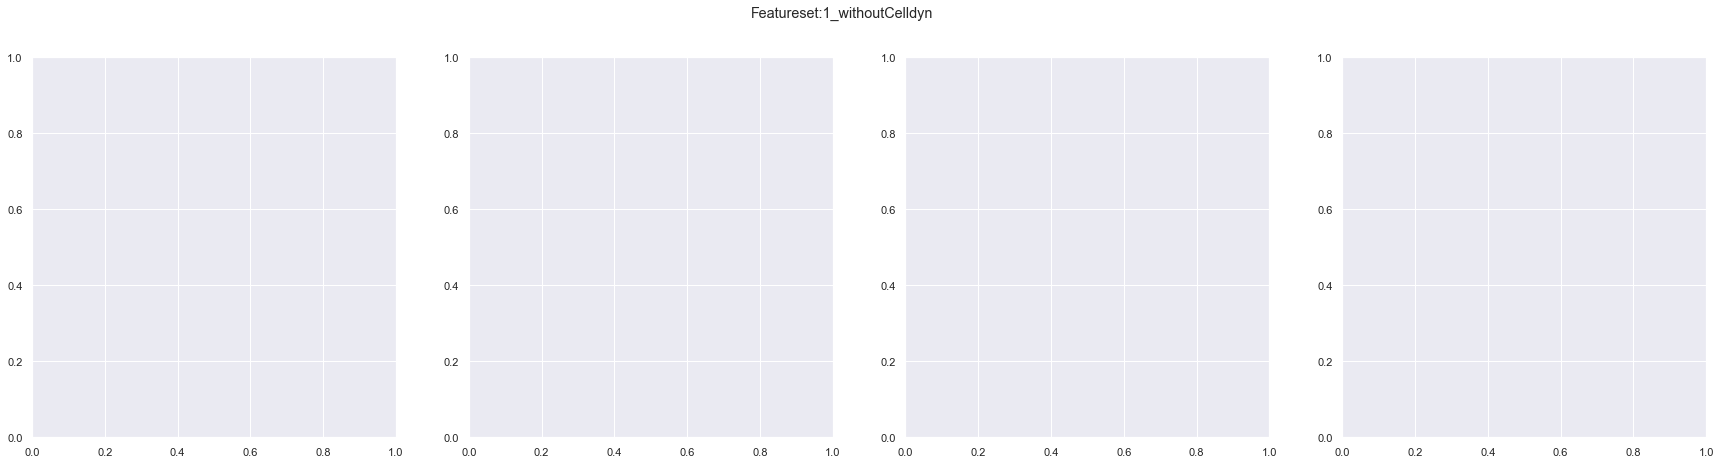

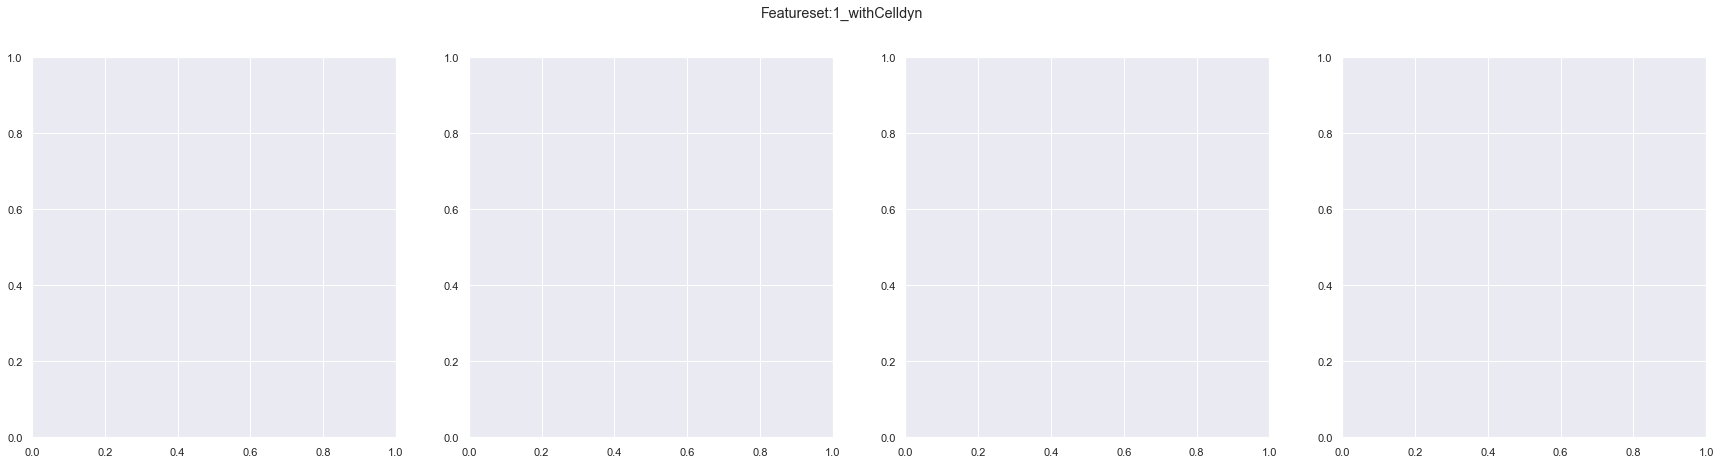

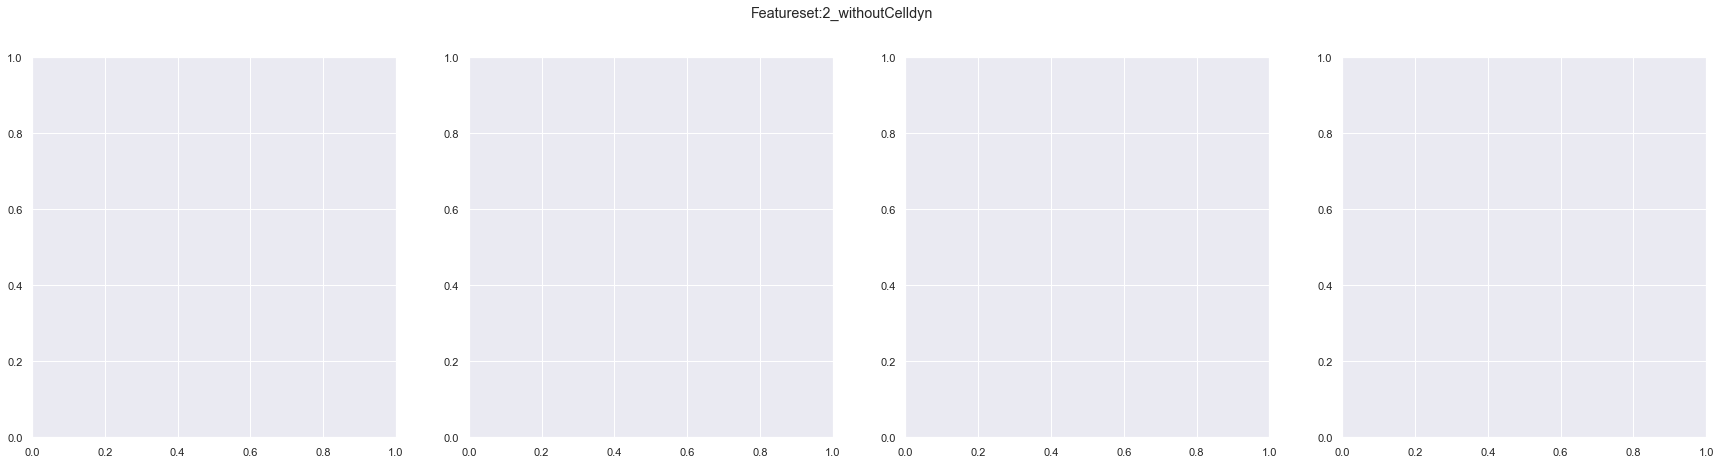

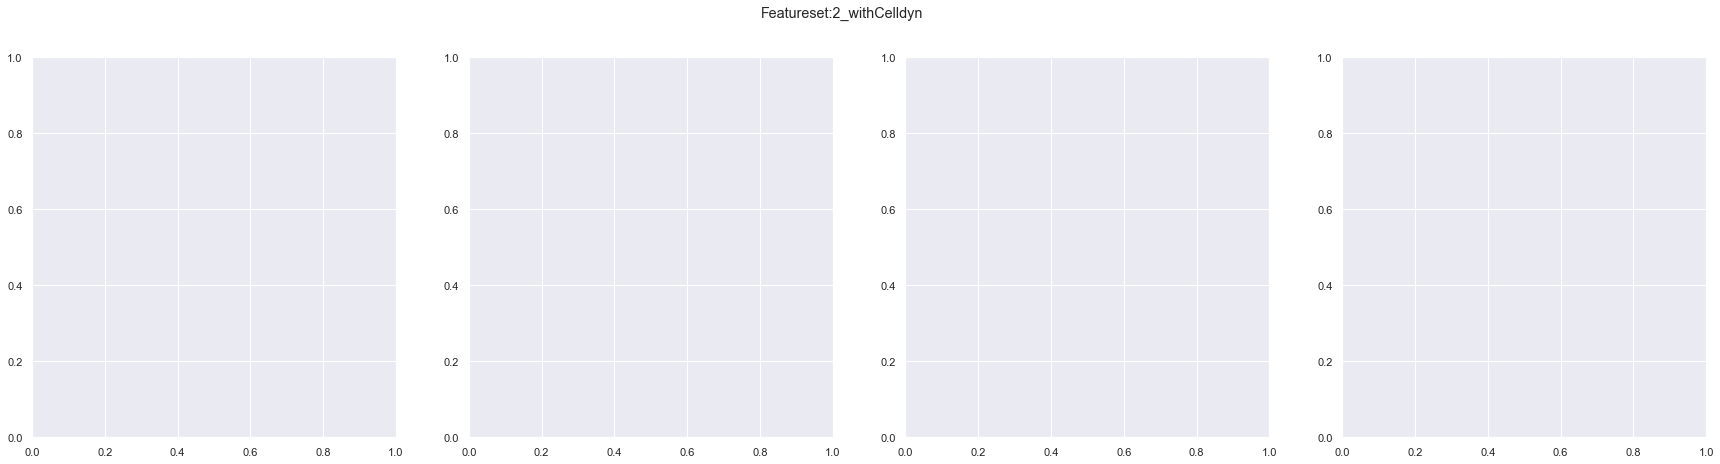

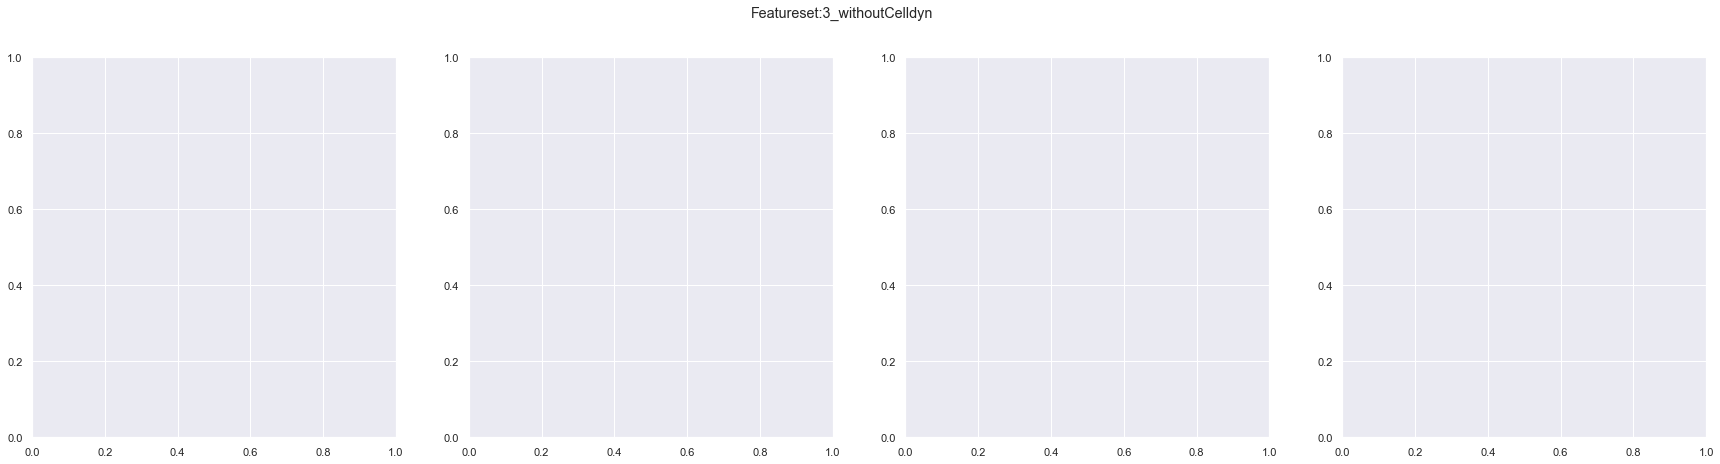

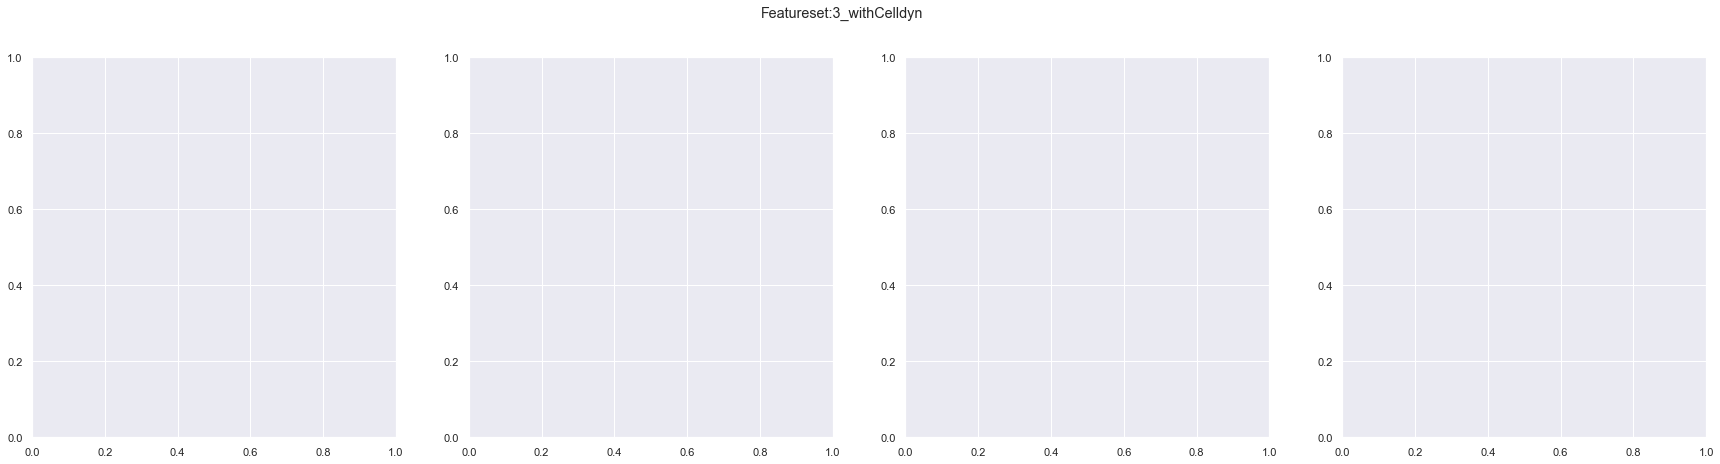

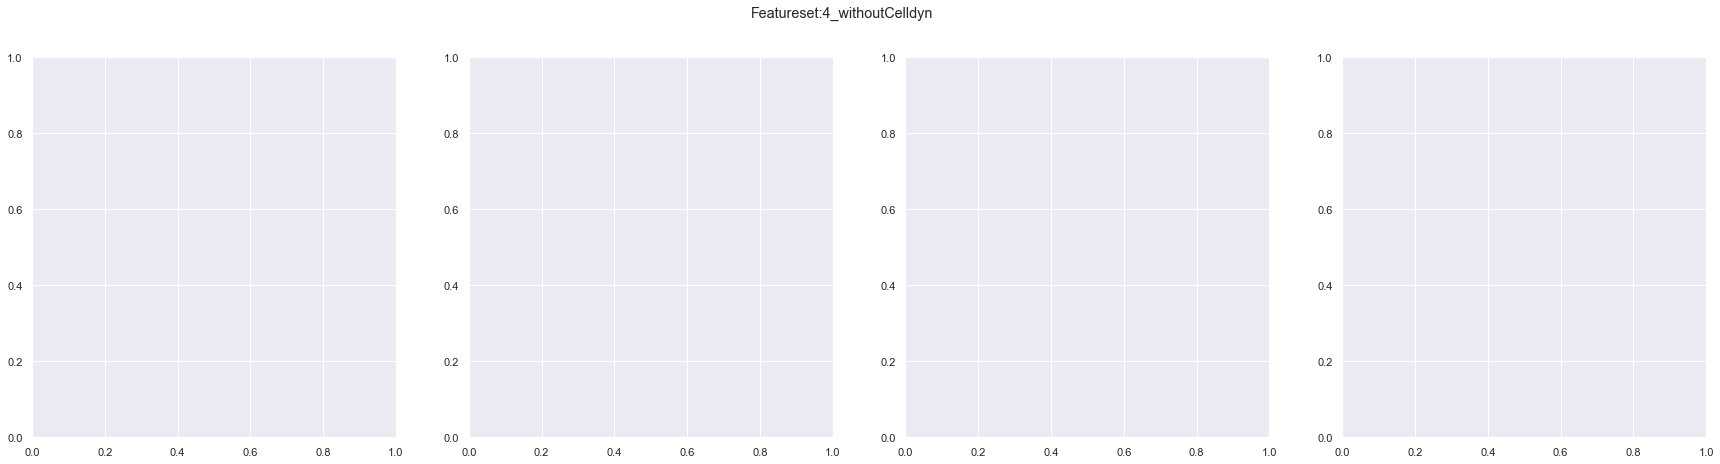

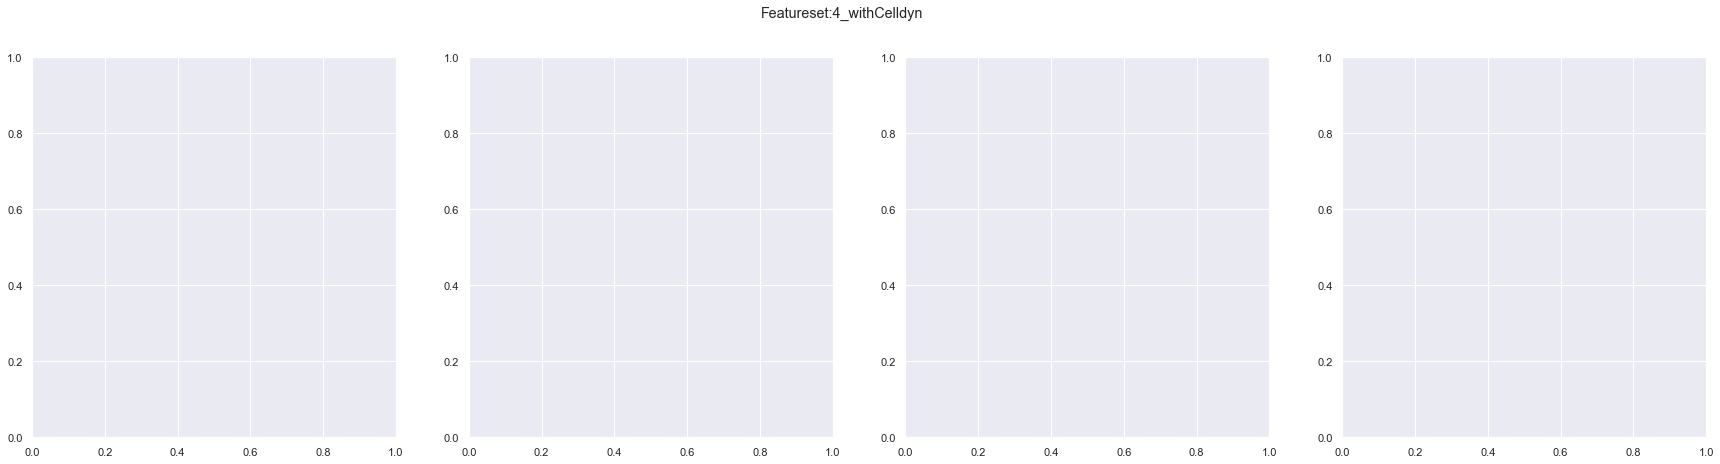

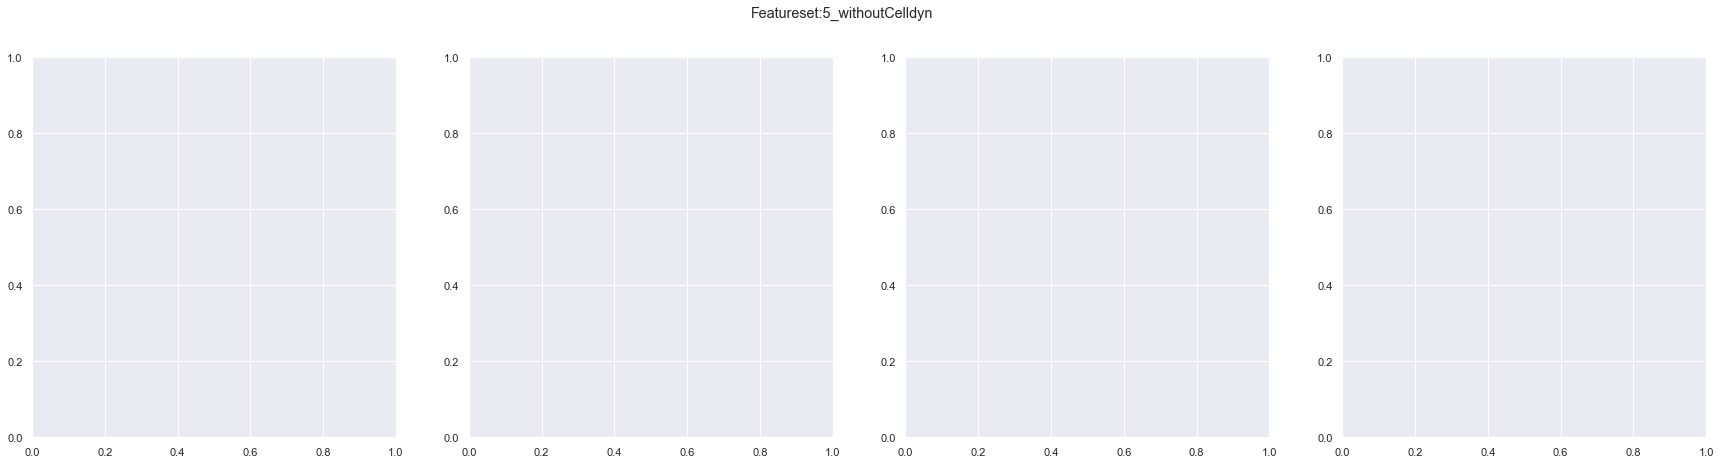

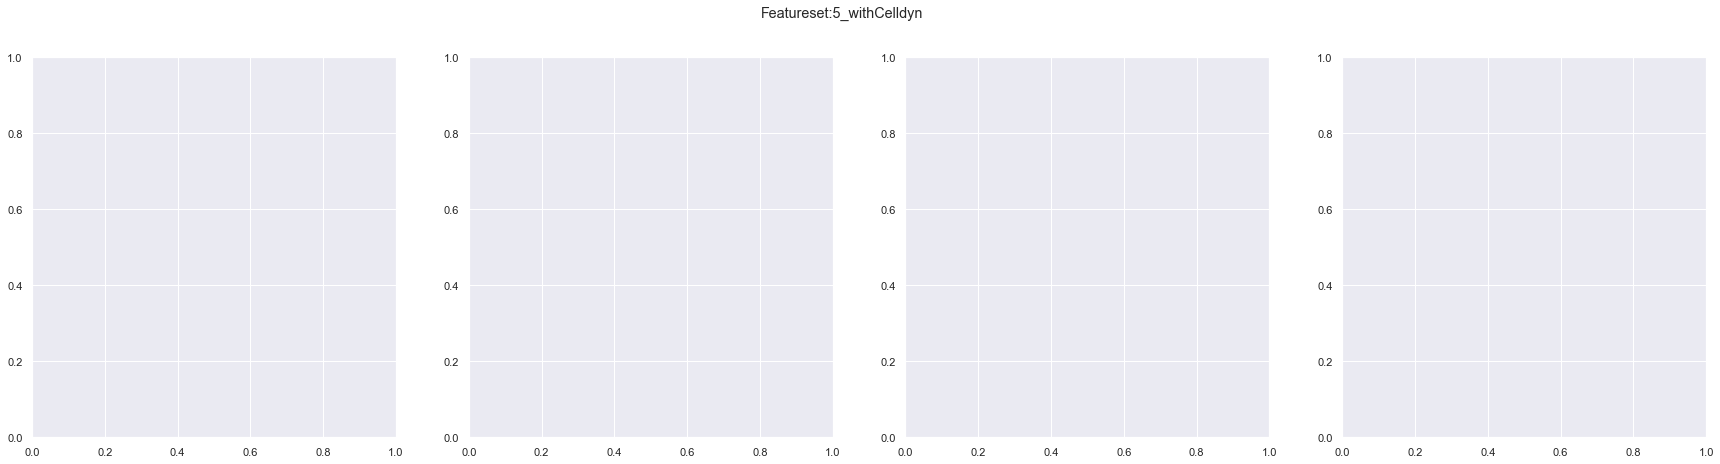

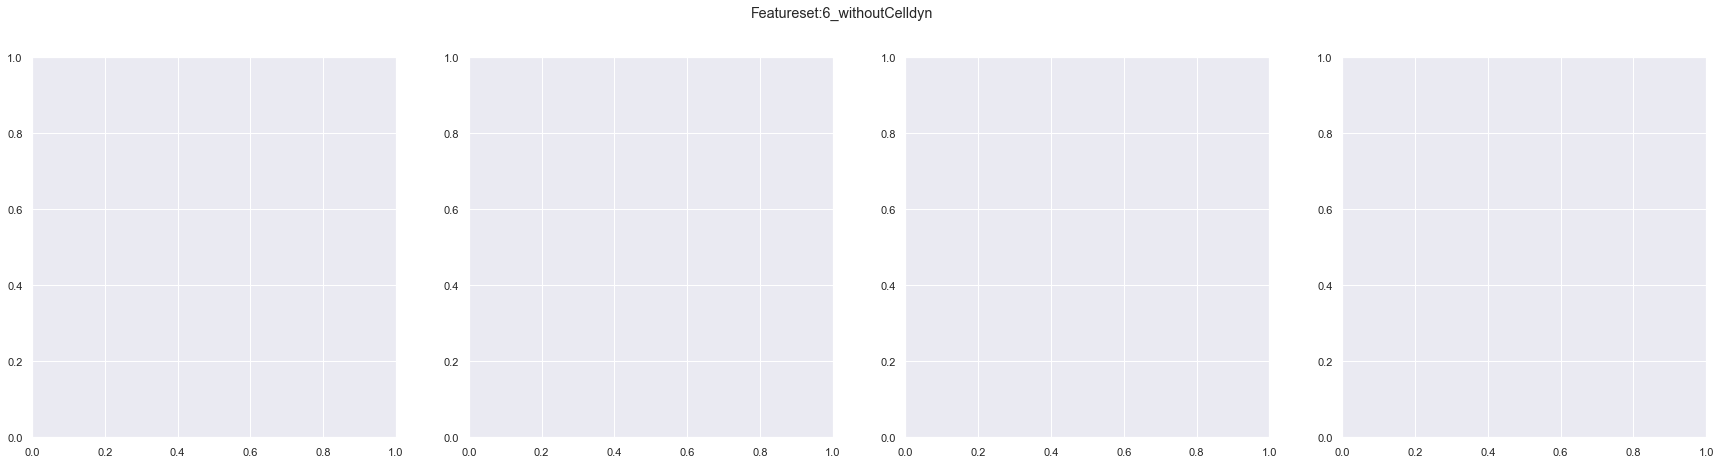

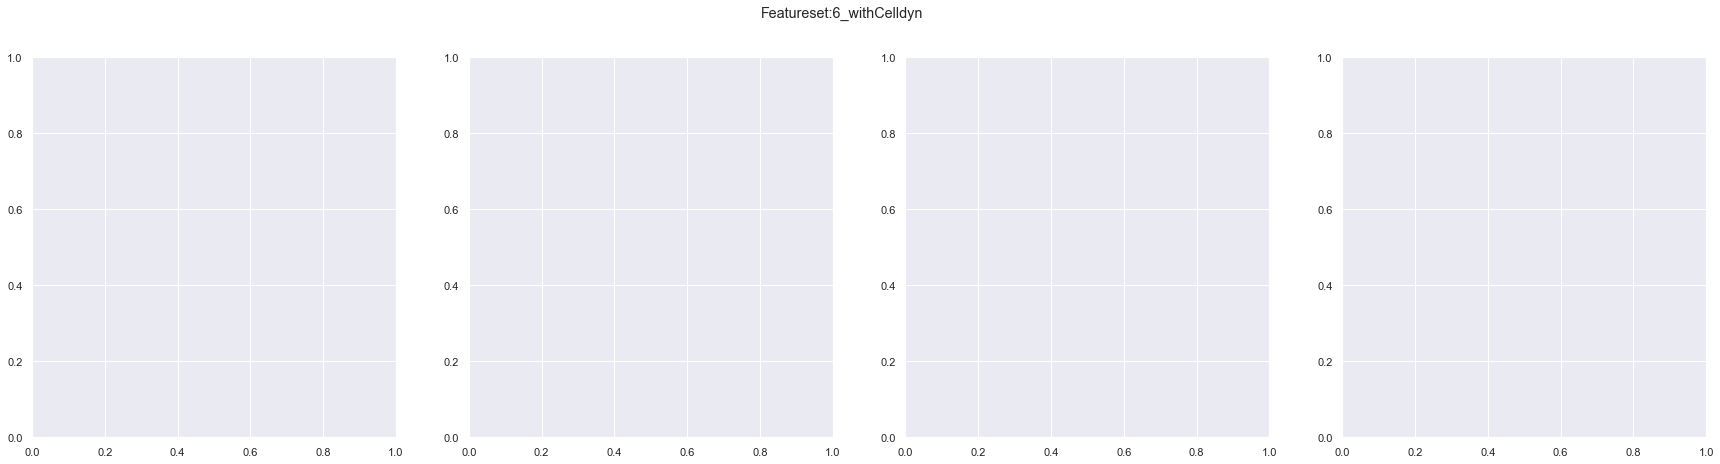

In [530]:
class_weights = {0: 1., 1: 2.}
dim_red = None
n_splits = 10
pre_scaled = False
upsample = None #, SVMSMOTE, ADASYN, BorderlineSMOTE

sss = StratifiedShuffleSplit(n_splits=n_splits, test_size=0.1, random_state=323)
clfs = [('dnn1', {'batch_size': 100, 'epochs' : 100, 'layers': [(128,0.05), (64,0.05), (48,0.05), (32,0.1)]}), 
        ('dnn2', {'batch_size': 100, 'epochs' : 150, 'layers': [(128,0.05), (96,0.05), (64,0.05), (32,0.1)]})]
model_weights = [1, 2]
transform = 'quantile'
n_quantiles=250 
distr='uniform'
reducer='PCA'
n_comp=128
min_dim = 10

tdx = 0 
np.seterr(all='warn')
for dkey, fval in feature_set.items():
    print("+"*20, "Processing feature set:{}".format(dkey))
    for ckey, cols in fval.items():
        print("-"*40, "Processing {}".format(ckey))        
        _cols = [__column for _key in cols for __column in col_dict[_key]]
        if pre_scaled:
            X = dat[_cols].values
        else:
            X = dat_unscaled[_cols].values
        
        results = []
        # we loop through the split generator, get predictions, place the scores in the dictionary and add the y_pred.
        for idx, ind_tuple in enumerate(sss.split(X, y)):
            print(30*"-","Processing fold {} from {} folds".format(idx+1, n_splits))

            train_ind, test_ind = ind_tuple

            # get train/test
            X_train, X_test = X[train_ind], X[test_ind]
            y_train, y_test = y[train_ind], y[test_ind]
            _n_comp = n_comp if X_train.shape[1]>n_comp else X_train.shape[1]
            X_train, _transformers = _transform(X_train, trans=transform, n_quantiles=n_quantiles, distr=distr, reducer=reducer, n_comp=_n_comp)
            X_test = X_test if _transformers is None else _transformers[1].transform(_transformers[0].transform(X_test))

            # up-sample positive targets/down-sample negative targets
            if upsample is not None:
                sm = upsample(sampling_strategy='minority', random_state=321, k_neighbors=5)
                X_train, y_train= sm.fit_sample(X_train, y_train)

            # train model
            for idx, _mtup in enumerate(clfs):
                if X_train.shape[1]>min_dim:
                    is_nn_classifier = True
                    clf = fit_nn(X_train, y_train, 
                                 network=_mtup[0], 
                                 verbose=0, 
                                 batch_size=_mtup[1]['batch_size'],
                                 epochs=_mtup[1]['epochs'], 
                                 class_weight=class_weights,
                                 convs_dnn=_mtup[1]['layers'])
                else:
                    print("Less then {} dimensions, we are using a simple logistic regression for this one".format(min_dim))
                    is_nn_classifier = False
                    clf = LogisticRegression(max_iter=500) # LogisticRegression(max_iter=500)
                    clf.fit(X_train, y_train)
                
                if is_nn_classifier:                    
                    _X_test = np.expand_dims(X_test, 2) if _mtup[0]=='cnn' else X_test
                    _y_pred = model_weights[idx]*clf.predict(_X_test)[:,0]/sum(model_weights) if idx==0 else _y_pred+model_weights[idx]*clf.predict(_X_test)[:,0]/sum(model_weights)
                else:
                    _y_pred = clf.predict_proba(X_test)[:,1] 
            if is_nn_classifier:
                model_string ="_".join([_clf[0] for _clf in clfs])
            else:
                model_string = str(clf.__class__)
            
            # get/store accuracy and store y_test/y_pred for ROC curves
            results.append({'ypred': _y_pred, 'ytest': y_test, 'dkey': dkey, 'ckey': ckey, 'models': model_string, 'split': idx})
            #print(70*"+","threshold 0.5\t=\tAUC: {}, NPV: {}, ACC: {}".format(metrics.roc_auc_score(y_test, y_pred[:, 1]), npv(y_test, y_pred[:, 1]), balanced_accuracy(y_test, y_pred[:, 1])))
            #print(70*"+","threshold 0.75\t=\tAUC: {}, NPV: {}, ACC: {}".format(metrics.roc_auc_score(y_test, y_pred[:, 1]), npv(y_test, y_pred[:, 1], thresh=0.75), balanced_accuracy(y_test, y_pred[:, 1], thresh=0.75)))
                      
        all_results += results
        
        figax = plt.subplots(ncols=4, figsize=(30, 7))
        for idx, _res in enumerate(results):            
            try:
                metr, figax = get_accuracy_plots(_res['ytest'], _res['ypred'], make_plots=False, figax=figax)
                metr['IDX'] = idx
                metr['model'] = "_".join([_clf[0] for _clf in clfs])
                metr['featureset'] = dkey
                metr['with_celldyn'] = 1 if ckey=='_withCelldyn' else 0
            except Exception as e:
                print("The results must be pretty badddd :))): {}".format(e))
            accuracies_nn = pd.concat([accuracies_nn, metr]) if tdx>0 else metr
            tdx += 1
        figax[0].suptitle("Featureset:"+dkey+ckey)

ValueError: min() arg is an empty sequence

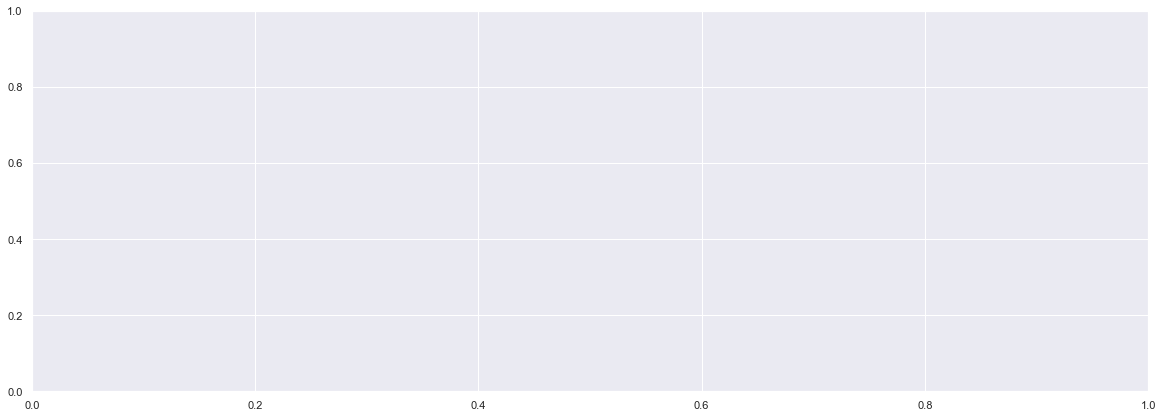

In [531]:
setString='1'
accuracies_melted = pd.melt(accuracies_nn[(accuracies_nn.THRESHOLD>0.50) & (accuracies_nn.featureset.isin(setString.split(",")))],
                            value_vars=['BAL_ACC' ,'F1_SCORE', 'NPV', 'REC', 'TRUE_REC', 'FPR', 'AUC'], 
                            id_vars=['with_celldyn', 'IDX'], 
                            var_name='metric', 
                            value_name='score')

fig, ax = plt.subplots(figsize=(20,7))
sns.violinplot(data=accuracies_melted, x='metric', y='score', hue='with_celldyn', k_depth="tukey", ax=ax)
sns.stripplot(data=accuracies_melted, x='metric', y='score', hue='with_celldyn', alpha=0.5, ax=ax)

plt.legend(title='CELLDYN', loc=4)
plt.title("Performance metrics with/without CELLDYN, set: "+setString)
ax.axhline(0.95, color='green')

In [ ]:
fig, ax = plt.subplots(ncols=5, figsize=(36, 8))
setString='2,3,4,5'
accuracies_nn[(accuracies_nn.with_celldyn==0) & (accuracies_nn.THRESHOLD>0.50) & (accuracies_nn.featureset.isin(setString.split(",")))].NPV.plot.kde(label='without celldyn', ax=ax[0])
accuracies_nn[(accuracies_nn.with_celldyn==1) & (accuracies_nn.THRESHOLD>0.50) & (accuracies_nn.featureset.isin(setString.split(",")))].NPV.plot.kde(label='with celldyn', ax=ax[0])
accuracies_nn[(accuracies_nn.THRESHOLD>0.50) & (accuracies_nn.featureset.isin(setString.split(",")))].NPV.plot.hist(color='grey', label='', density=True, ax=ax[0])
ax[0].legend()
ax[0].set_title('NPV')

accuracies_nn[(accuracies_nn.with_celldyn==0) & (accuracies_nn.THRESHOLD>0.50) & (accuracies_nn.featureset.isin(setString.split(",")))].REC.plot.kde(label='without celldyn', ax=ax[1])
accuracies_nn[(accuracies_nn.with_celldyn==1) & (accuracies_nn.THRESHOLD>0.50) & (accuracies_nn.featureset.isin(setString.split(",")))].REC.plot.kde(label='with celldyn', ax=ax[1])
accuracies_nn[(accuracies_nn.THRESHOLD>0.50) & (accuracies_nn.featureset.isin(setString.split(",")))].REC.plot.hist(color='grey', label='', density=True, ax=ax[1])
ax[1].legend()
ax[1].set_title('Recall')

accuracies_nn[(accuracies_nn.with_celldyn==0) & (accuracies_nn.THRESHOLD>0.50) & (accuracies_nn.featureset.isin(setString.split(",")))].F1_SCORE.plot.kde(label='without celldyn', ax=ax[2])
accuracies_nn[(accuracies_nn.with_celldyn==1) & (accuracies_nn.THRESHOLD>0.50) & (accuracies_nn.featureset.isin(setString.split(",")))].F1_SCORE.plot.kde(label='with celldyn', ax=ax[2])
accuracies_nn[(accuracies_nn.THRESHOLD>0.50) & (accuracies_nn.featureset.isin(setString.split(",")))].F1_SCORE.plot.hist(color='grey', label='', density=True, ax=ax[2])

ax[2].legend()
ax[2].set_title('F1')

accuracies_nn[(accuracies_nn.with_celldyn==0) & (accuracies_nn.THRESHOLD>0.50) & (accuracies_nn.featureset.isin(setString.split(",")))].AUC.plot.kde(label='without celldyn', ax=ax[3])
accuracies_nn[(accuracies_nn.with_celldyn==1) & (accuracies_nn.THRESHOLD>0.50) & (accuracies_nn.featureset.isin(setString.split(",")))].AUC.plot.kde(label='with celldyn', ax=ax[3])
accuracies_nn[(accuracies_nn.THRESHOLD>0.50) & (accuracies_nn.featureset.isin(setString.split(",")))].AUC.plot.hist(color='grey', label='', density=True, ax=ax[3])
ax[3].legend()
ax[3].set_title('ROC-AUC')

accuracies_nn[(accuracies_nn.with_celldyn==0) & (accuracies_nn.THRESHOLD>0.50) & (accuracies_nn.featureset.isin(setString.split(",")))].BAL_ACC.plot.kde(label='without celldyn', ax=ax[4])
accuracies_nn[(accuracies_nn.with_celldyn==1) & (accuracies_nn.THRESHOLD>0.50) & (accuracies_nn.featureset.isin(setString.split(",")))].BAL_ACC.plot.kde(label='with celldyn', ax=ax[4])
accuracies_nn[(accuracies_nn.THRESHOLD>0.50) & (accuracies_nn.featureset.isin(setString.split(",")))].BAL_ACC.plot.hist(color='grey', label='', density=True, ax=ax[4])
ax[4].legend()
ax[4].set_title('Balanced accuracy')

fig.suptitle("Comparison of scores between featuresets, with/without celldyn, sets "+setString)

In [ ]:
# stat distance 
d1 = accuracies_nn[accuracies_nn.with_celldyn==0].NPV
d2 = accuracies_nn[accuracies_nn.with_celldyn==1].NPV
print("Means: with CELLDYN {}, without CELLDYN {}".format(d1.mean(), d2.mean()))
ks2(d1,d2)

In [ ]:
# store to disk
allres = pd.DataFrame(all_results)
allres_f = "allres_2020-01-29"
allres.to_hdf("/laupodteam/AIOS/Bram/data/HeartScore/Results/"+allres_f+".hdf")

In [ ]:
# use cross_validate and differential evolution for hyperparameter optimisation

In [ ]:
# Perform calibration
# https://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html#sklearn.calibration.CalibratedClassifierCV


In [ ]:
# AutoKeras
# 

# AutoGluon
# https://autogluon.mxnet.io/tutorials/tabular_prediction/tabular-quickstart.html


## Investigation of features using SHAP/LIME

## Feature combinations using RuleFit

In [ ]:
cols = col_dict['pheno']+col_dict['ecg']+col_dict['celldyn']+col_dict['troponine']+col_dict['hs']+col_dict['history']+inter_celldyn_cols+inter_ecg_cols
X = dat[cols].values
gb = GradientBoostingClassifier(n_estimators=300)  #XGBRegressor(n_estimators=10, objective ='reg:squarederror', max_depth=3) # XGBRegressor
clf = RuleFit(tree_generator=gb, rfmode='class')
clf.fit(X, y.values, feature_names=cols)



## ROC and threshold-recall/precision dependencies

Unnecessary denied NSTEMIs **v.** unnecessary signaled NSTEMIs **v.** total recall

## Accuracy clustering: identifying promising samples for celldyn predictor

In [ ]:
dat_unscaled.tn_slope2.plot.kde(figsize=(14,10))
dat_unscaled[['tn_peak', 'tn_peak24', 'tn_admission']].apply(lambda x: x[1]-x[0], axis=1).plot.kde() 

In [ ]:
dat_unscaled[:1]

In [ ]:
dat_unscaled[dat_unscaled.tn_slope2>10][['tn_slope2', 'tn_admission', 'tn_peak', 'tn_peak24']]

# Unsupervised clustering assisted supervised clustering

## Unsupervised model division for a model per cluster approach

## Unsupervised clustering and inclusion of cluster labels for classification